# Compare KS and PSPA

## Setup

In [ ]:
#| output: False
!pip install git+https://github.com/sky1ove/katlas.git -q

In [ ]:
from katlas.core import *
from katlas.plot import *

from fastbook import *
import seaborn as sns
from scipy.stats import spearmanr, pearsonr

import os
from PIL import Image
from tqdm import tqdm

In [ ]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("ticks")

## Load data

In [ ]:
df = Data.get_ks_dataset()

## Get overlap kinase between KS and PSPA

In [ ]:
# normalized PSPA data
norm = Data.get_stack_norm()
raw = Data.get_stack_raw()

In [ ]:
#get overlap and count
overlap_cnt = df[df.kinase_paper.isin(raw.kinase)].kinase_paper.value_counts()

In [ ]:
overlap_cnt

PKACA     1740
ERK2      1380
CDK1      1325
IKKB      1297
ERK1      1160
          ... 
IRE1         1
CK1A2        1
HUNK         1
CAMK1G       1
DRAK1        1
Name: kinase_paper, Length: 286, dtype: int64

In [ ]:
overlap_cnt = overlap_cnt[overlap_cnt>100]

In [ ]:
overlap_cnt

PKACA    1740
ERK2     1380
CDK1     1325
IKKB     1297
ERK1     1160
         ... 
HIPK3     110
CDK8      107
BUB1      106
MEKK3     104
GRK1      101
Name: kinase_paper, Length: 202, dtype: int64

In [ ]:
# PSPA data
raw = raw.set_index('kinase')
norm = norm.set_index('kinase')

## Plot

In [ ]:
sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_context('notebook')
sns.set_style("ticks")

In [ ]:
# aa_order = [i for i in 'PGACSTVILMFYWHKRQNDEsty']
aa_order_paper = [i for i in 'PGACSTVILMFYWHKRQNDEsty']
# position = [i for i in range(-7,8)]
position_paper = [-5,-4,-3,-2,-1,1,2,3,4]

### One example of dataset-driven vs. raw PSPA

  0%|          | 0/202 [00:00<?, ?it/s]

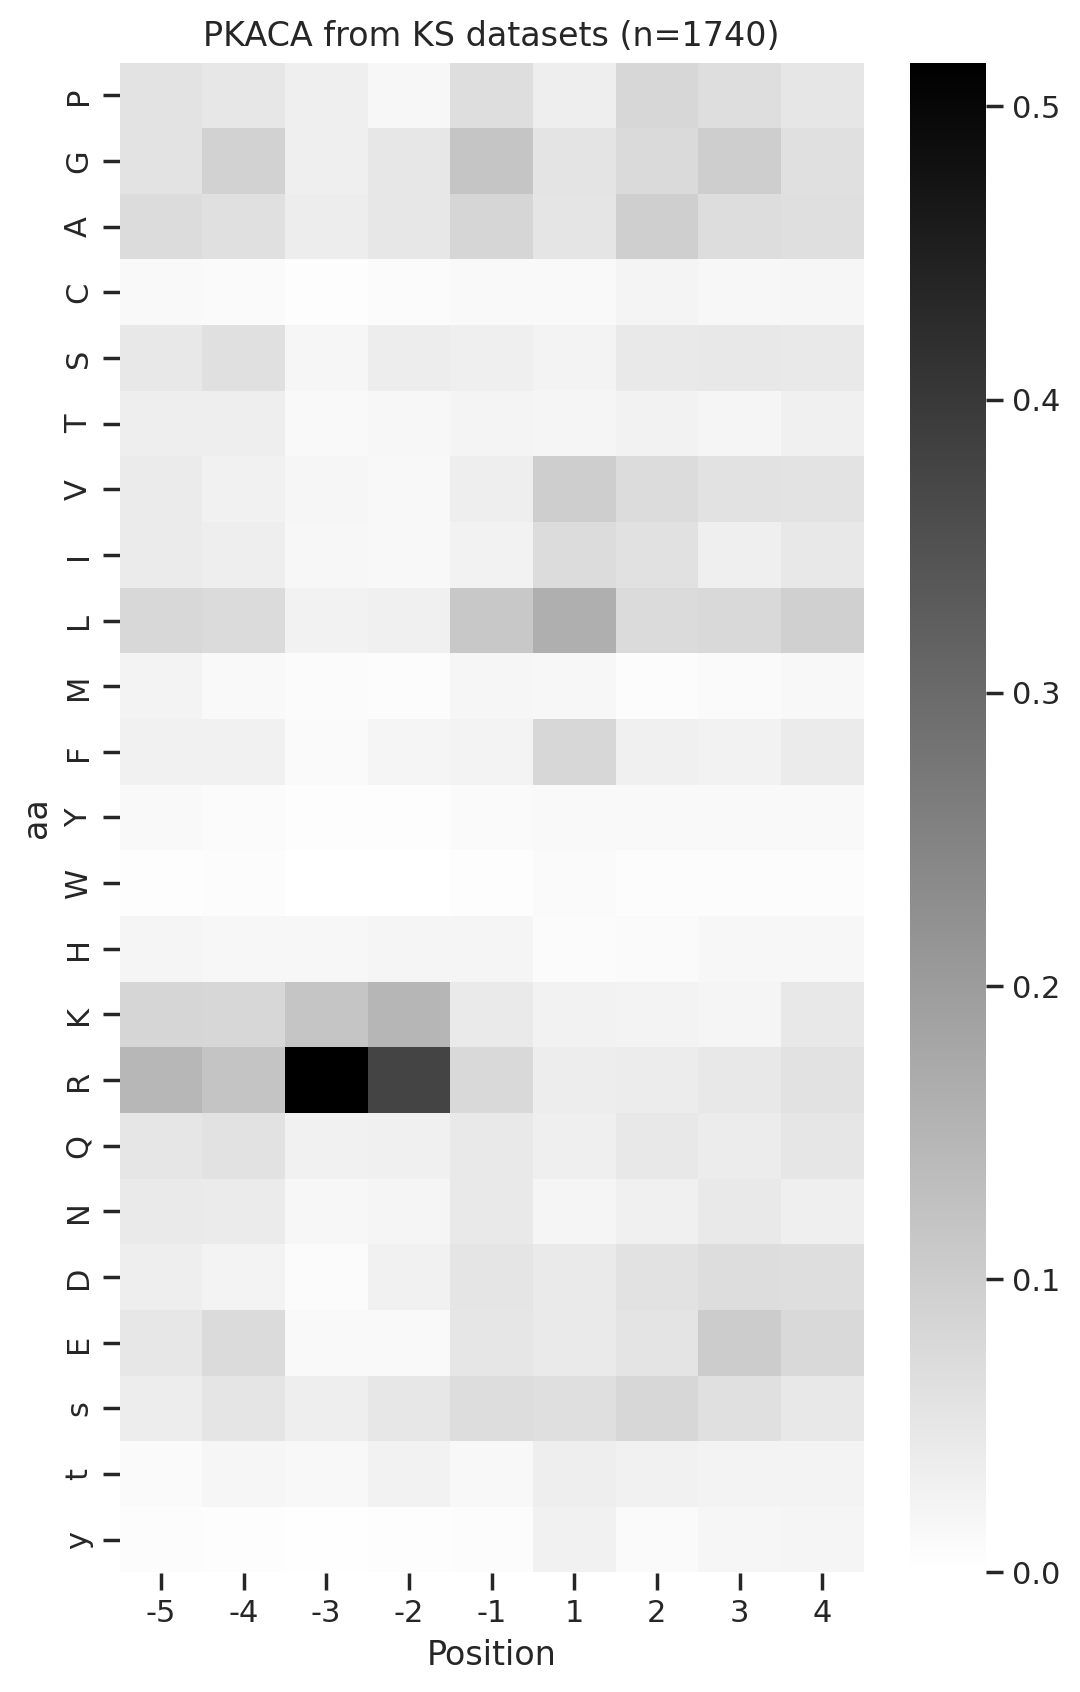

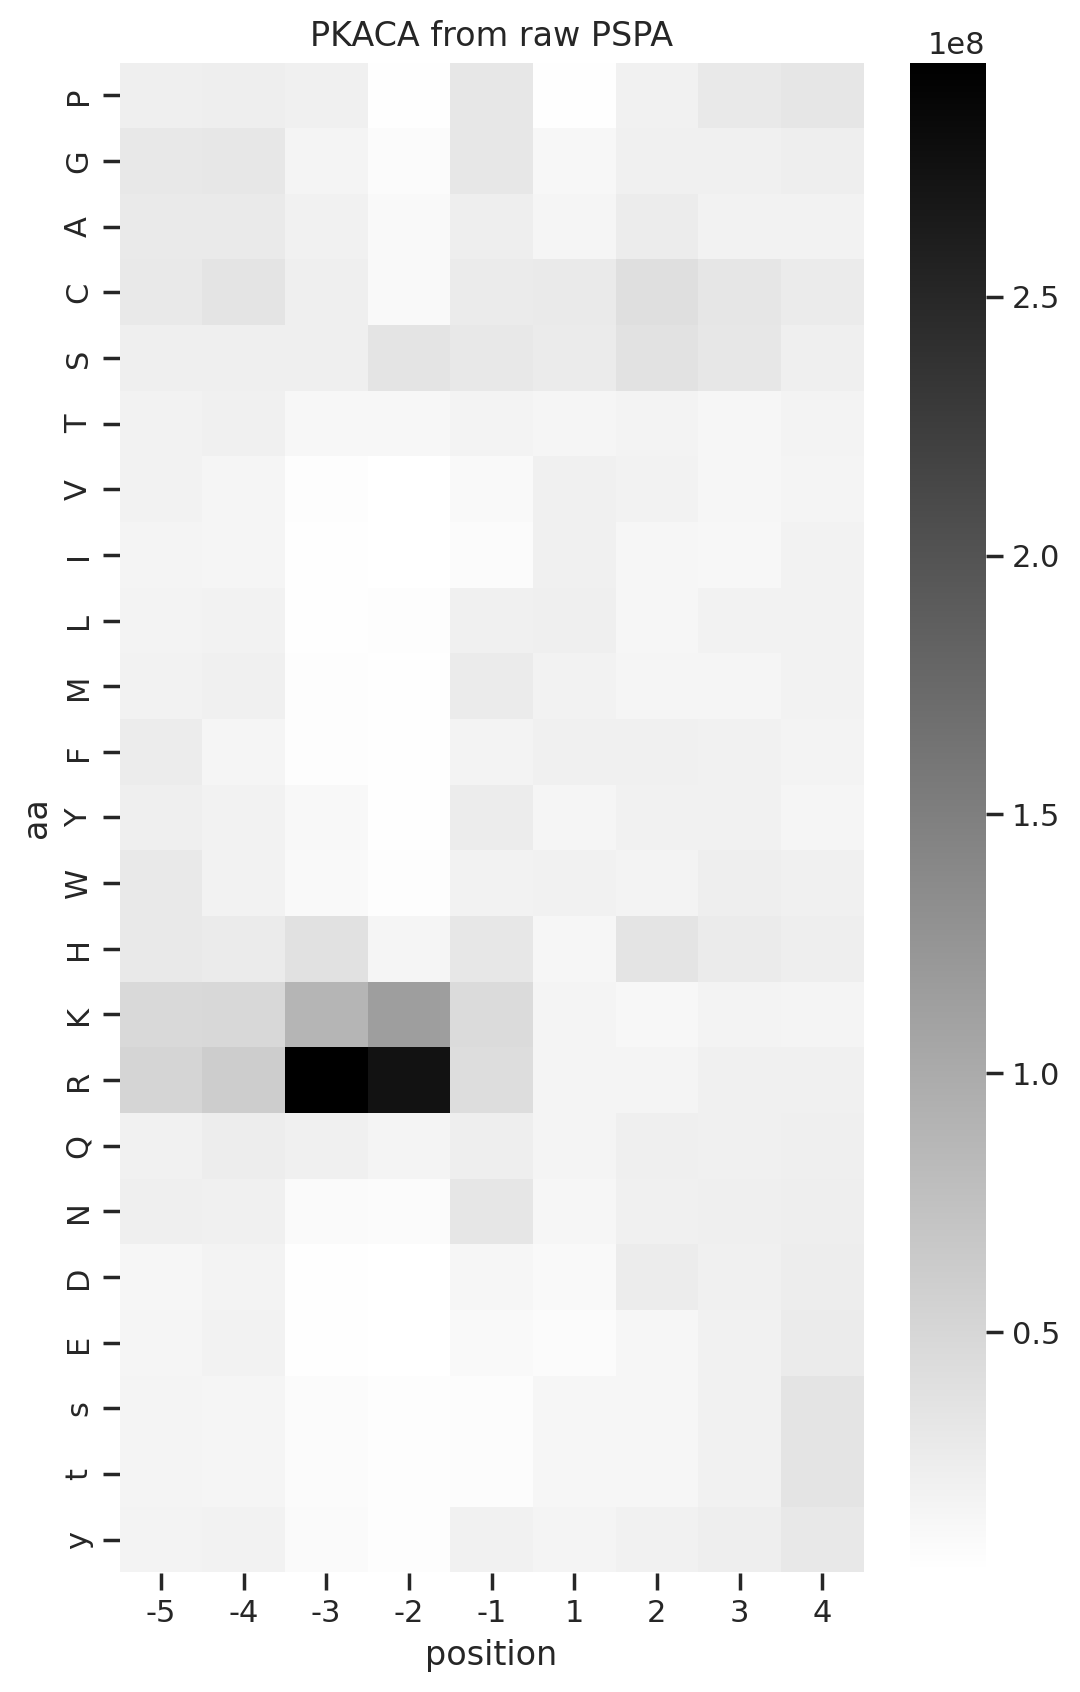

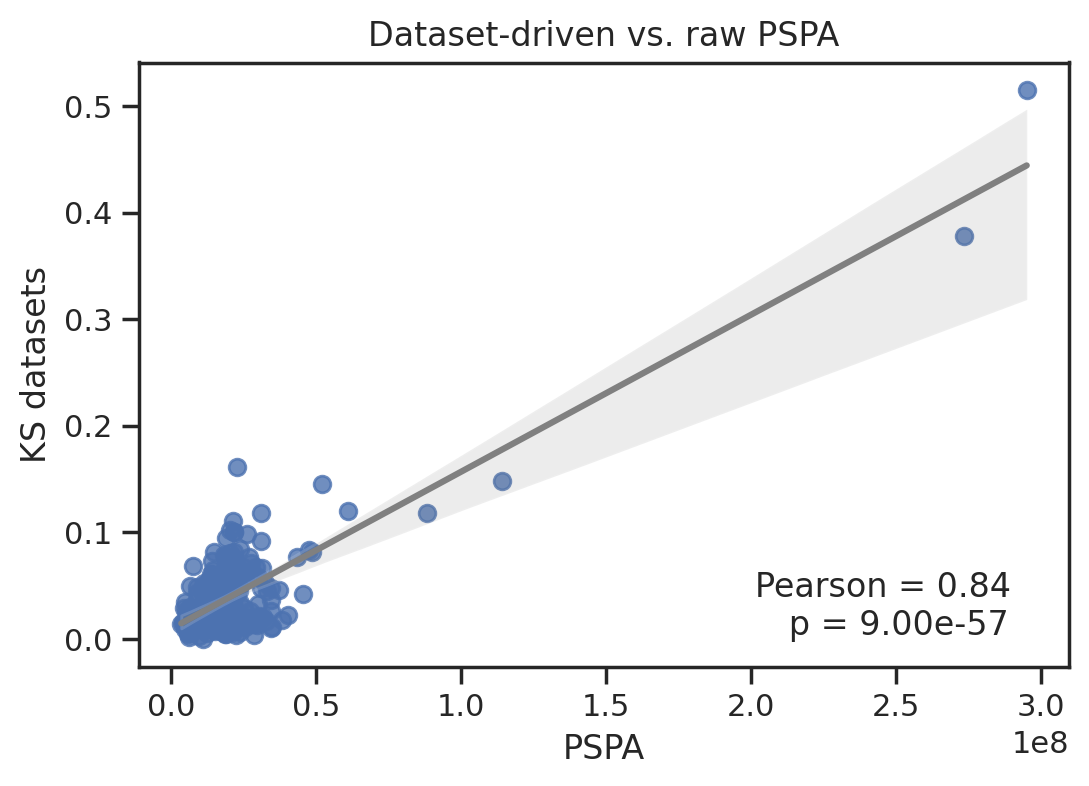

  0%|          | 0/202 [00:00<?, ?it/s]


In [ ]:
for k in tqdm(overlap_cnt.index,total=len(overlap_cnt)):
    df_k = df.query(f'kinase_paper=="{k}"').reset_index()
    paper,full = get_freq(df_k)
    raw_k = get_one_kinase(raw,k,drop_s=False).T.reindex(index=aa_order_paper,columns=position_paper).round(3)
    
    plot_heatmap(paper,f'{k} from KS datasets (n={overlap_cnt[k]})')
    # plt.savefig(f'corr/KS/{k}.png',bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close()

    plot_heatmap(raw_k,f'{k} from raw PSPA')
    # plt.savefig(f'corr/PSPA/{k}.png',bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close()

    # plt.figure(figsize=(7,3))
    plot_corr(y = paper.unstack().values, #dataset driven
              x = raw_k.unstack().values, # PSPA
              ylabel='KS datasets',
              xlabel='PSPA')
    plt.title('Dataset-driven vs. raw PSPA')
    # plt.savefig(f'corr/pear/{k}.png',bbox_inches='tight', pad_inches=0.2)
    plt.show()
    plt.close()
    
    break

### Dataset-driven vs. normalized

Generate all of other figures and save them

In [ ]:
for k in tqdm(overlap_cnt.index,total=len(overlap_cnt)):
    df_k = df.query(f'kinase_paper=="{k}"').reset_index()
    paper,full = get_freq(df_k)
    raw_k = get_one_kinase(norm,k,drop_s=False).T.reindex(index=aa_order_paper,columns=position_paper).round(3)
    
    plot_heatmap(paper,f'{k} from KS datasets (n={overlap_cnt[k]})')
    plt.savefig(f'corr/KS/{k}.png',bbox_inches='tight', pad_inches=0.05)
    # plt.show()
    plt.close()

    plot_heatmap(raw_k,f'{k} from PSPA')
    plt.savefig(f'corr/PSPA/{k}.png',bbox_inches='tight', pad_inches=0.05)
    # plt.show()
    plt.close()

    plot_corr(y = paper.unstack().values, #dataset driven
              x = raw_k.unstack().values, # PSPA
              ylabel='KS datasets',
              xlabel='PSPA')
    plt.title(k)
    plt.savefig(f'corr/pear/{k}.png',bbox_inches='tight', pad_inches=0.2)
    # plt.show()
    plt.close()
    
    # break

100%|██████████| 202/202 [04:22<00:00,  1.30s/it]


Combine the figures: correlation on top, and two heatmaps on the bottom

In [ ]:
def combine_images_custom_layout(image_paths, output_path):
    images = [Image.open(image_path).convert('RGBA') for image_path in image_paths]
    
    # Calculate total width and height for the new image
    total_width = max(images[0].width, images[1].width + images[2].width)
    total_height = images[0].height + max(images[1].height, images[2].height)
    
    # Create a new image with calculated dimensions
    combined_image = Image.new('RGBA', (total_width, total_height))
    
    # Paste the first image at the top-center
    x_offset = (total_width - images[0].width) // 2
    combined_image.paste(images[0], (x_offset, 0), images[0])
    
    # Paste the second image at the bottom-left
    combined_image.paste(images[1], (0, images[0].height), images[1])
    
    # Paste the third image at the bottom-right
    combined_image.paste(images[2], (images[1].width, images[0].height), images[2])
    
    # Save the result
    combined_image.save(output_path)

In [ ]:
folders = ["corr/pear",'corr/KS','corr/PSPA']

for k in tqdm(overlap_cnt.index,total=len(overlap_cnt)):
    filename = f"{k}.png"
    image_paths = [os.path.join(folder, filename) for folder in folders]
    output_path = f"corr/combine/{k}.png"
    combine_images_custom_layout(image_paths, output_path)
    # break

100%|██████████| 202/202 [01:29<00:00,  2.27it/s]


## Plot comparison

In [ ]:
norm = Data.get_stack_norm().set_index('kinase')
raw = Data.get_stack_raw().set_index('kinase')

***Correlation with raw PSPA***

In [ ]:
data = []
for k in overlap_cnt.index:
    df_k = df.query(f'kinase_paper=="{k}"').reset_index()
    cnt = df_k.shape[0]
    
    paper,full = get_freq(df_k)
    raw_k = get_one_kinase(raw,k,drop_s=False).T.reindex(index=aa_order_paper,columns=position_paper).round(3)
    
    full_corr,_ = pearsonr(raw_k.unstack().values,paper.unstack().values)
    
    data.append([k,full_corr,cnt])
    

In [ ]:
corr_raw = pd.DataFrame(data,columns= ['kinase','corr_with_raw','count_combined'])

***Correlation with normalized PSPA***

In [ ]:
data = []
for k in overlap_cnt.index:
    df_k = df.query(f'kinase_paper=="{k}"').reset_index()
    cnt = df_k.shape[0]
    
    paper,full = get_freq(df_k)
    norm_k = get_one_kinase(norm,k,drop_s=False).T.reindex(index=aa_order_paper,columns=position_paper).round(3)
    
    full_corr,_ = pearsonr(norm_k.unstack().values,paper.unstack().values)
    
    data.append([k,full_corr])
    

In [ ]:
corr_norm = pd.DataFrame(data,columns= ['kinase','corr_with_norm',
                                ])

***Merge with specificity***

In [ ]:
corr = corr_raw.merge(corr_norm)

In [ ]:
m = pd.read_csv('raw/specificity_pspa.csv')

In [ ]:
corr= corr.merge(m).rename(columns={'max':'specificity'})

In [ ]:
corr

,kinase,corr_with_raw,count_combined,corr_with_norm,specificity
0,PKACA,0.841689,1740,0.833835,0.476953
1,ERK2,0.751987,1380,0.827213,0.510499
2,CDK1,0.864848,1325,0.879297,0.569784
3,IKKB,0.149388,1297,0.280318,0.157279
4,ERK1,0.830827,1160,0.878767,0.567533
...,...,...,...,...,...
197,HIPK3,0.620166,110,0.679037,0.399684
198,CDK8,0.305177,107,0.384925,0.542519
199,BUB1,0.154635,106,0.179524,0.240232
200,MEKK3,-0.093351,104,0.022305,0.127274


In [ ]:
corr.query('kinase == "CK1A"')

,kinase,corr_with_raw,count_combined,corr_with_norm,specificity
116,CK1A,0.228787,341,0.236014,0.79104


***Pearson vs. Specificity***

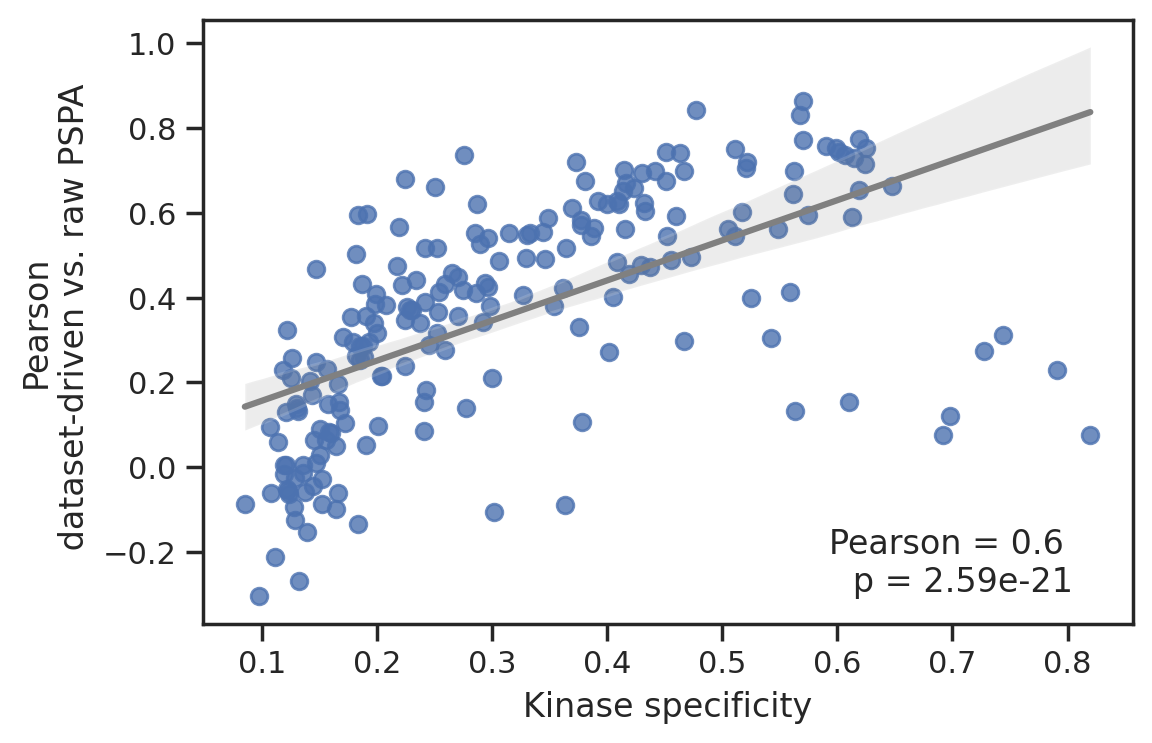

In [ ]:
plot_corr(x=corr.specificity.values,
          y=corr.corr_with_raw.values)
plt.ylabel('Pearson\n dataset-driven vs. raw PSPA')
plt.xlabel('Kinase specificity');

In [ ]:
info = Data.get_kinase_info_full().query('pseudo==0')

corr2 = corr.merge(info)

color = load_pickle('raw/kinase_color.pkl')

In [ ]:
# corr2['change_corr_norm-raw'] = corr2['corr_with_norm'] - corr2['corr_with_raw']

# cols = corr2.columns[:15].tolist()+['change_corr_norm-raw']

# corr2[cols].to_csv('supp/Fig3CGHI.csv',index=False)

Text(24.888888888888903, 0.5, 'Pearson')

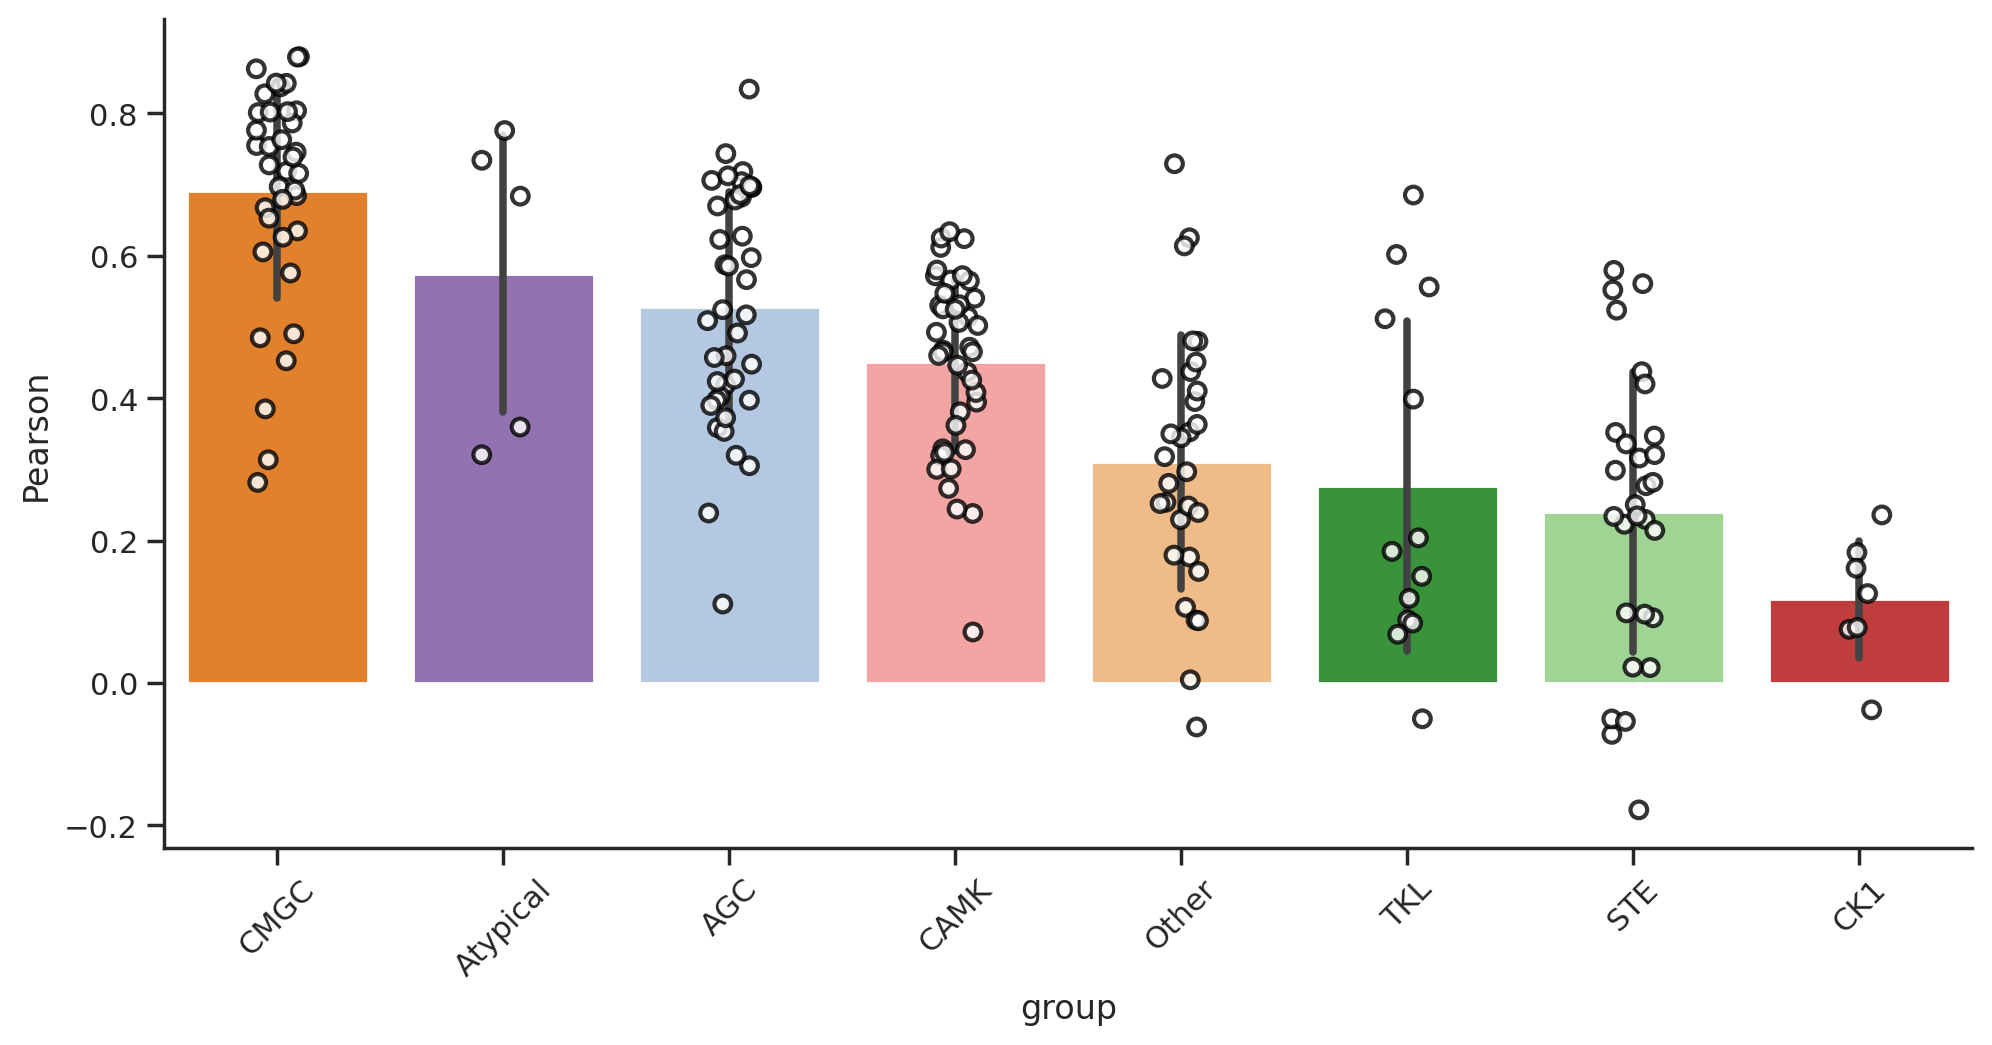

In [ ]:
plot_bar(corr2,'corr_with_norm','group',aspect=2,palette=color)
plt.ylabel('Pearson')

Text(0.5, 1.0, 'Distribution of Pearson score')

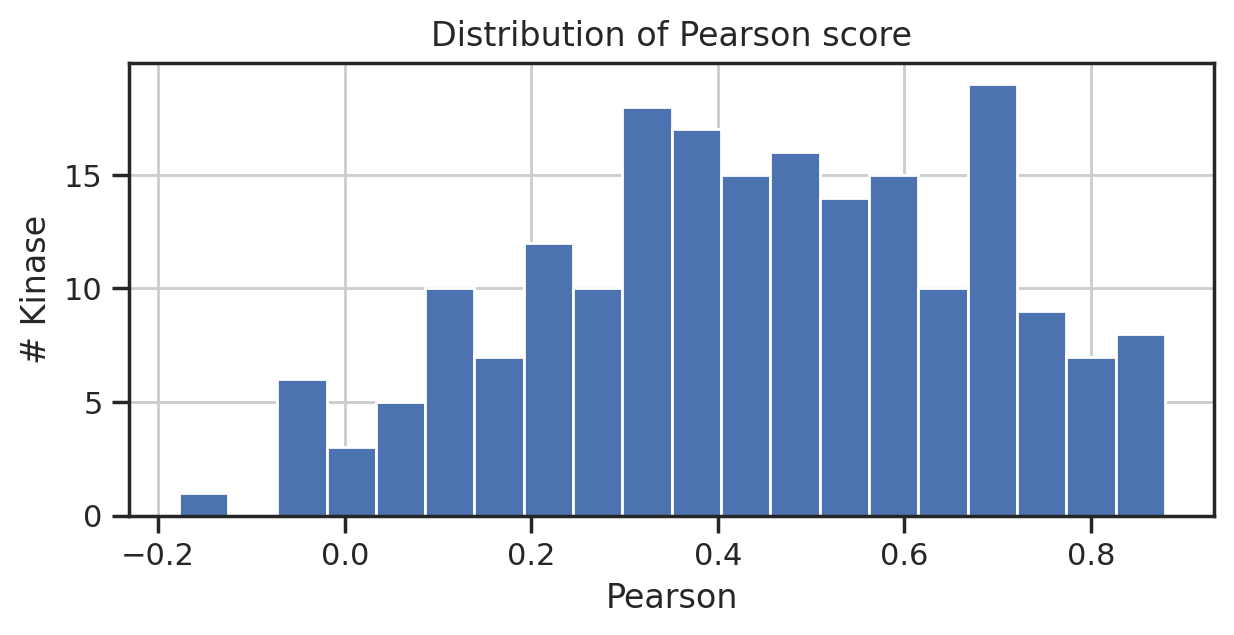

In [ ]:
plt.figure(figsize=(7,3))
corr.corr_with_norm.hist(bins=20)
plt.xlabel('Pearson')
plt.ylabel('# Kinase')
plt.title('Distribution of Pearson score')

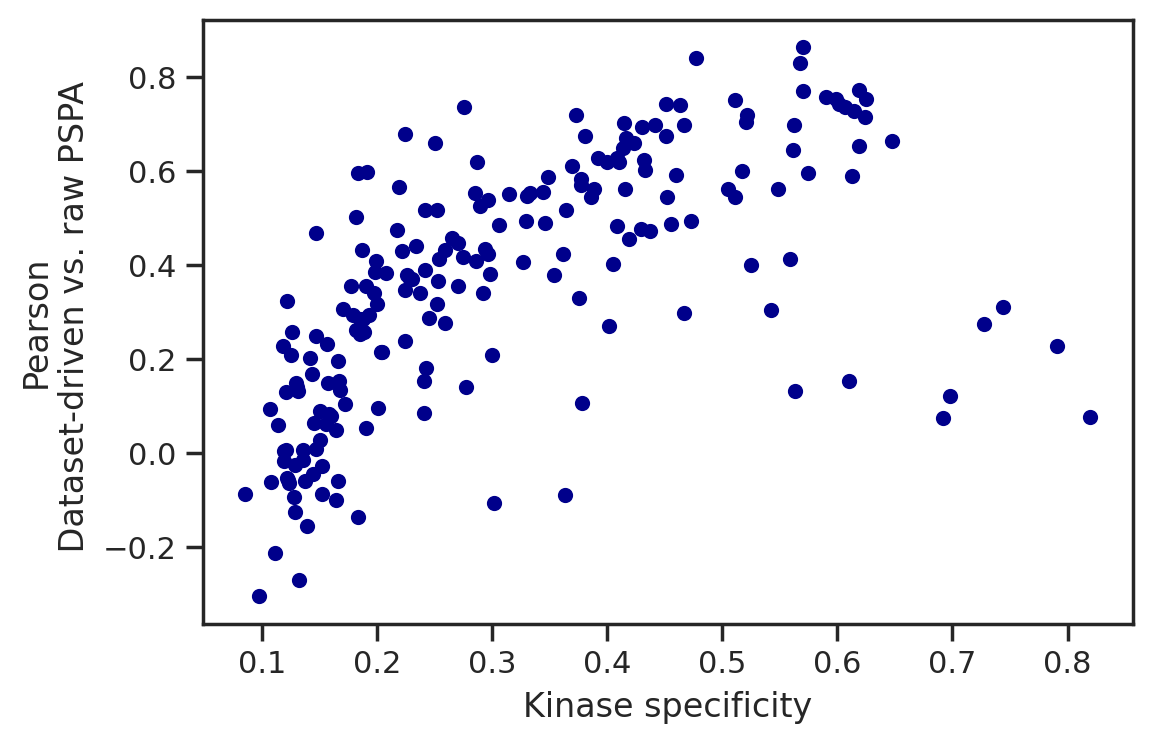

In [ ]:
corr.plot.scatter(y='corr_with_raw',x='specificity',c='darkblue')
plt.ylabel('Pearson\n Dataset-driven vs. raw PSPA')
plt.xlabel('Kinase specificity');
# plt.title('Dataset-driven vs. raw PSPA')

***Examples of outliers***

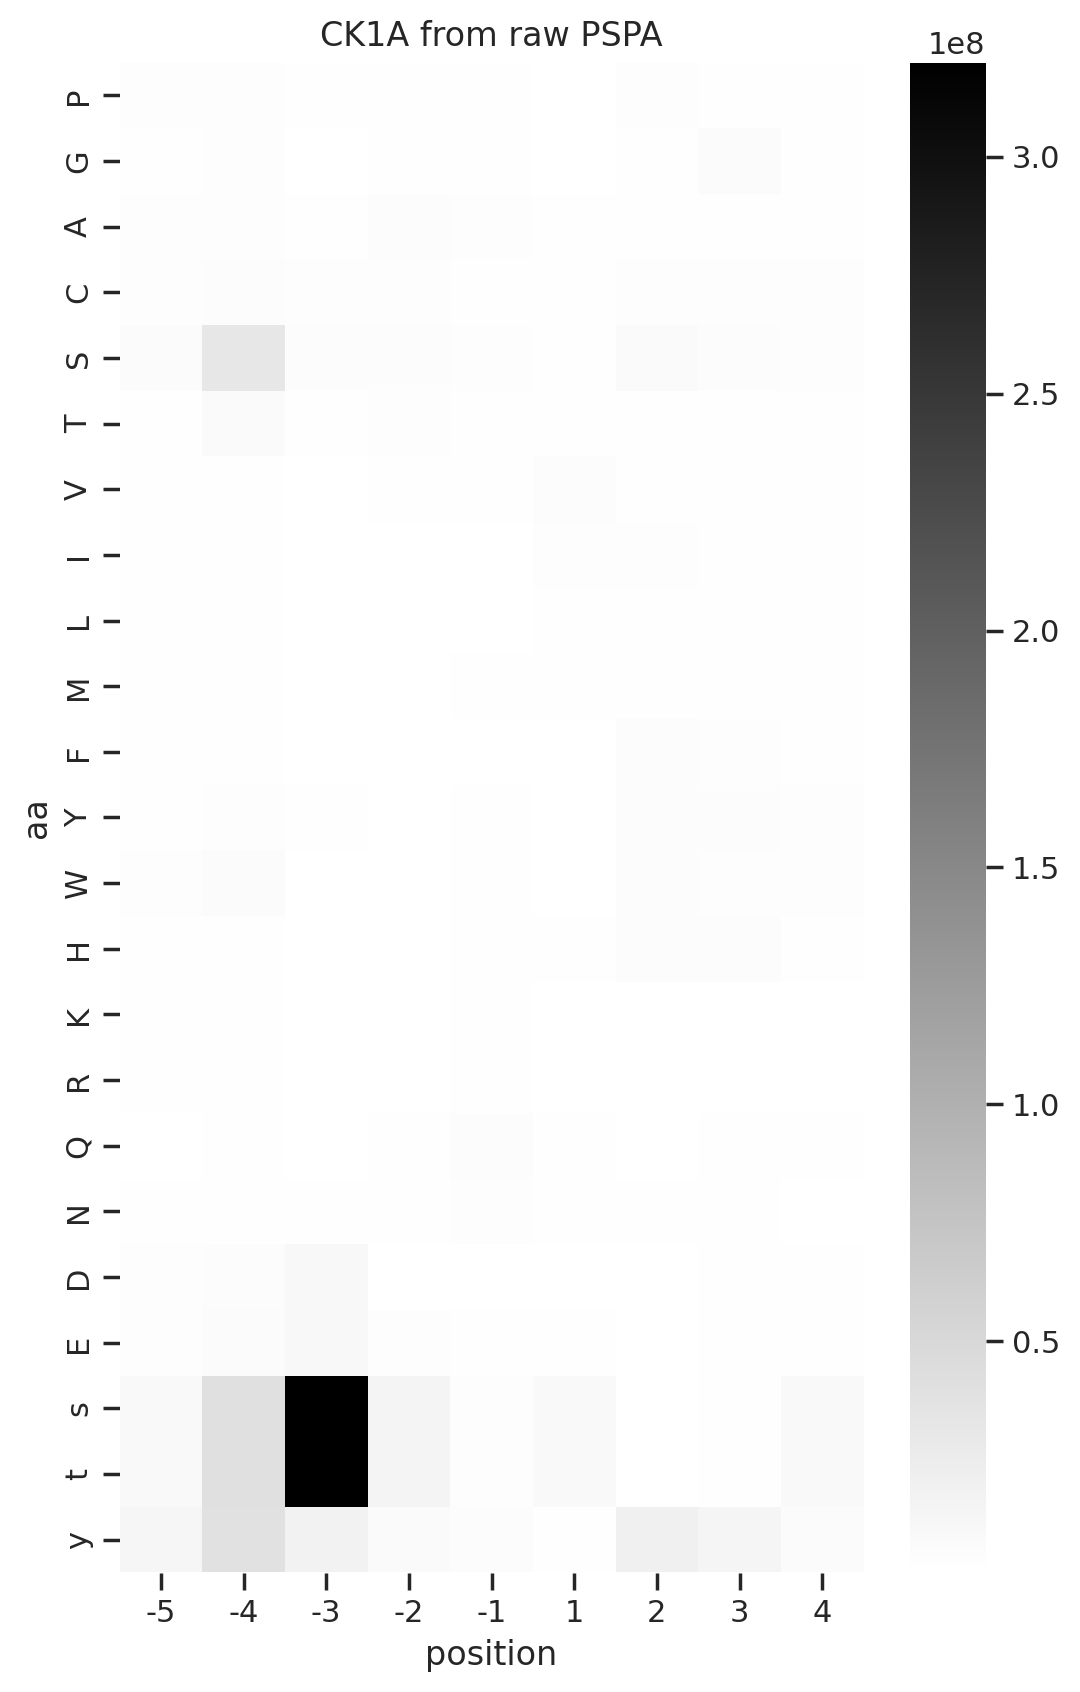

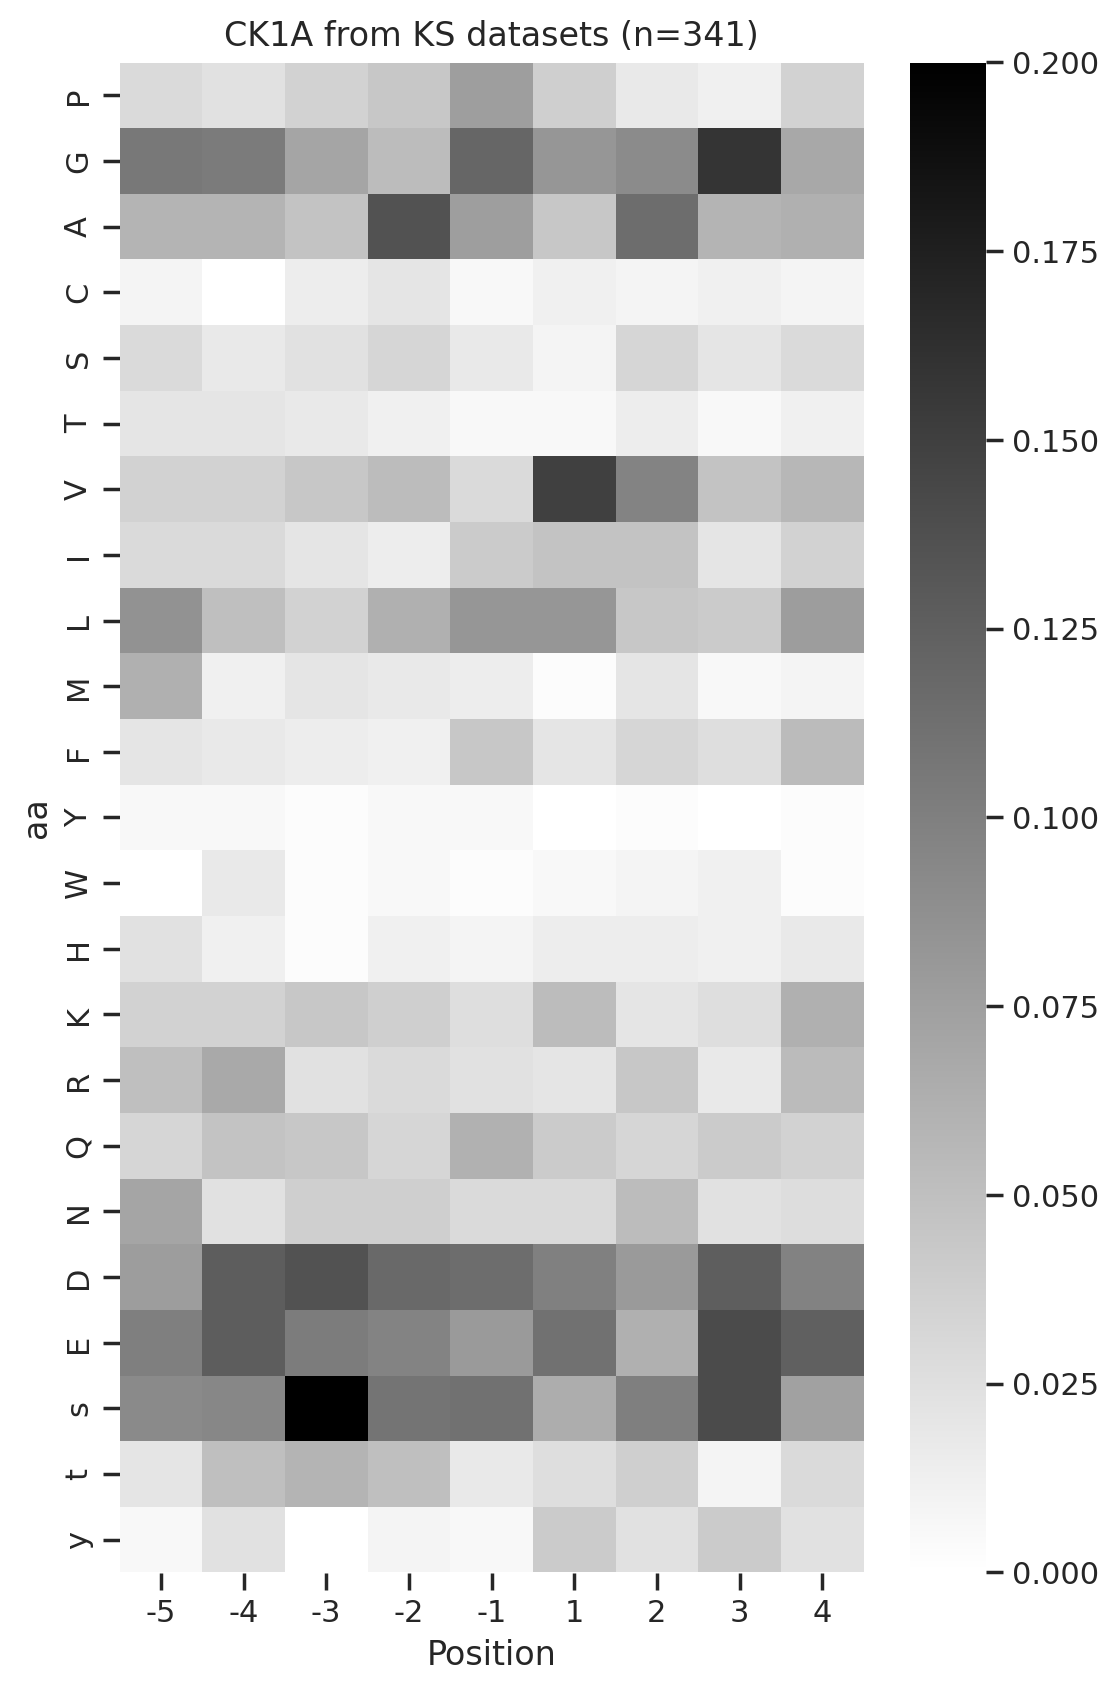

In [ ]:
# Examples of data
k = 'CK1A'
df_k=df.query(f'kinase_paper == "{k}"')
paper, full = get_freq(df_k)

raw_k = get_one_kinase(raw,k,drop_s=False).T
raw_k = raw_k.reindex(index=aa_order_paper)

plot_heatmap(raw_k,f'{k} from raw PSPA')
plot_heatmap(paper,f'{k} from KS datasets (n={len(df_k)})')

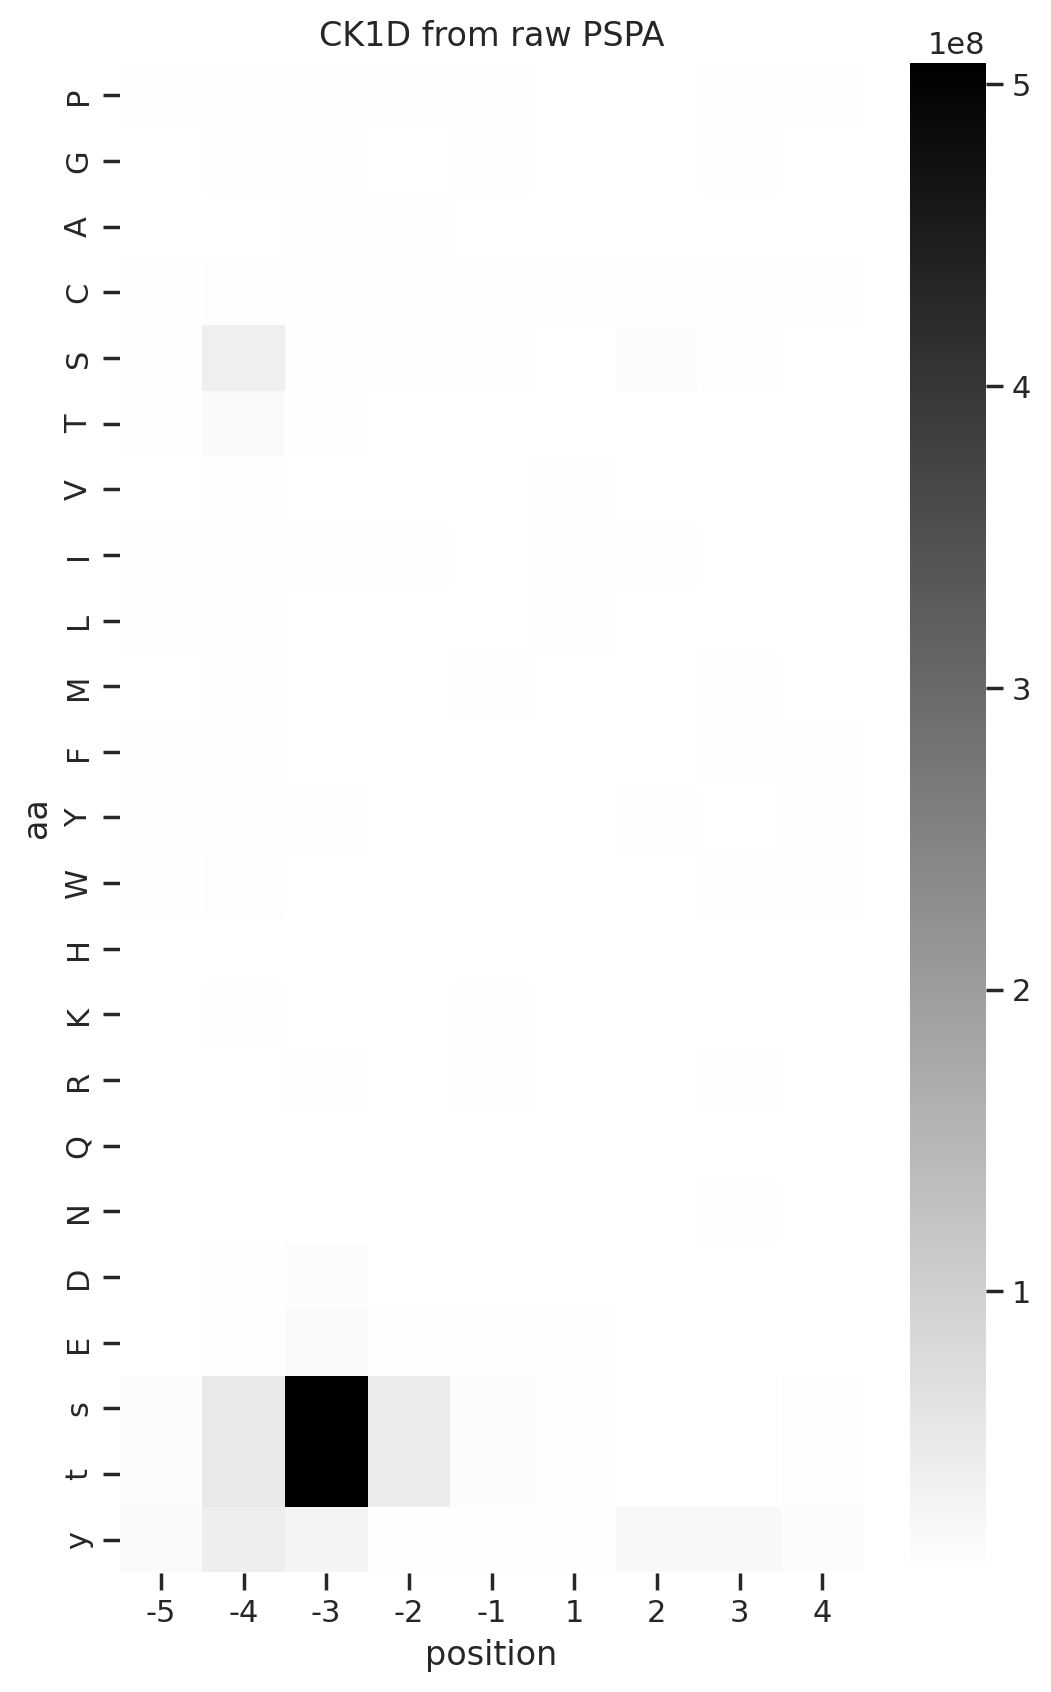

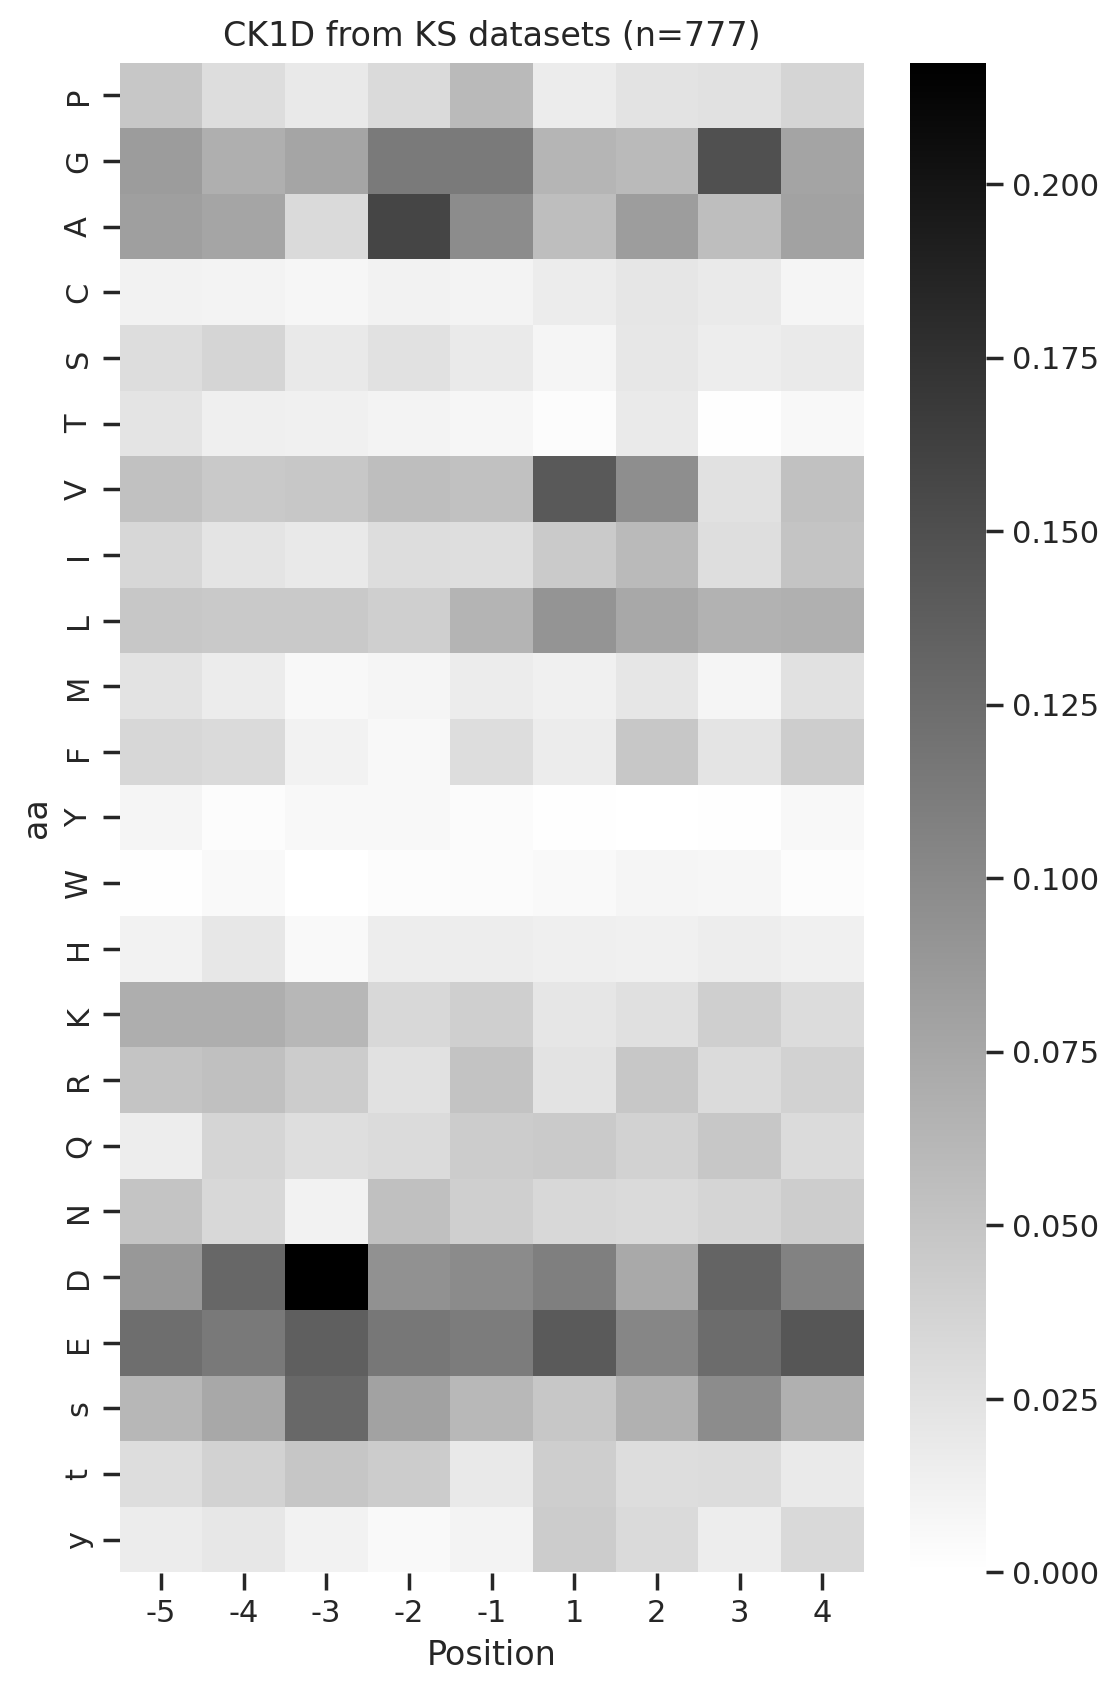

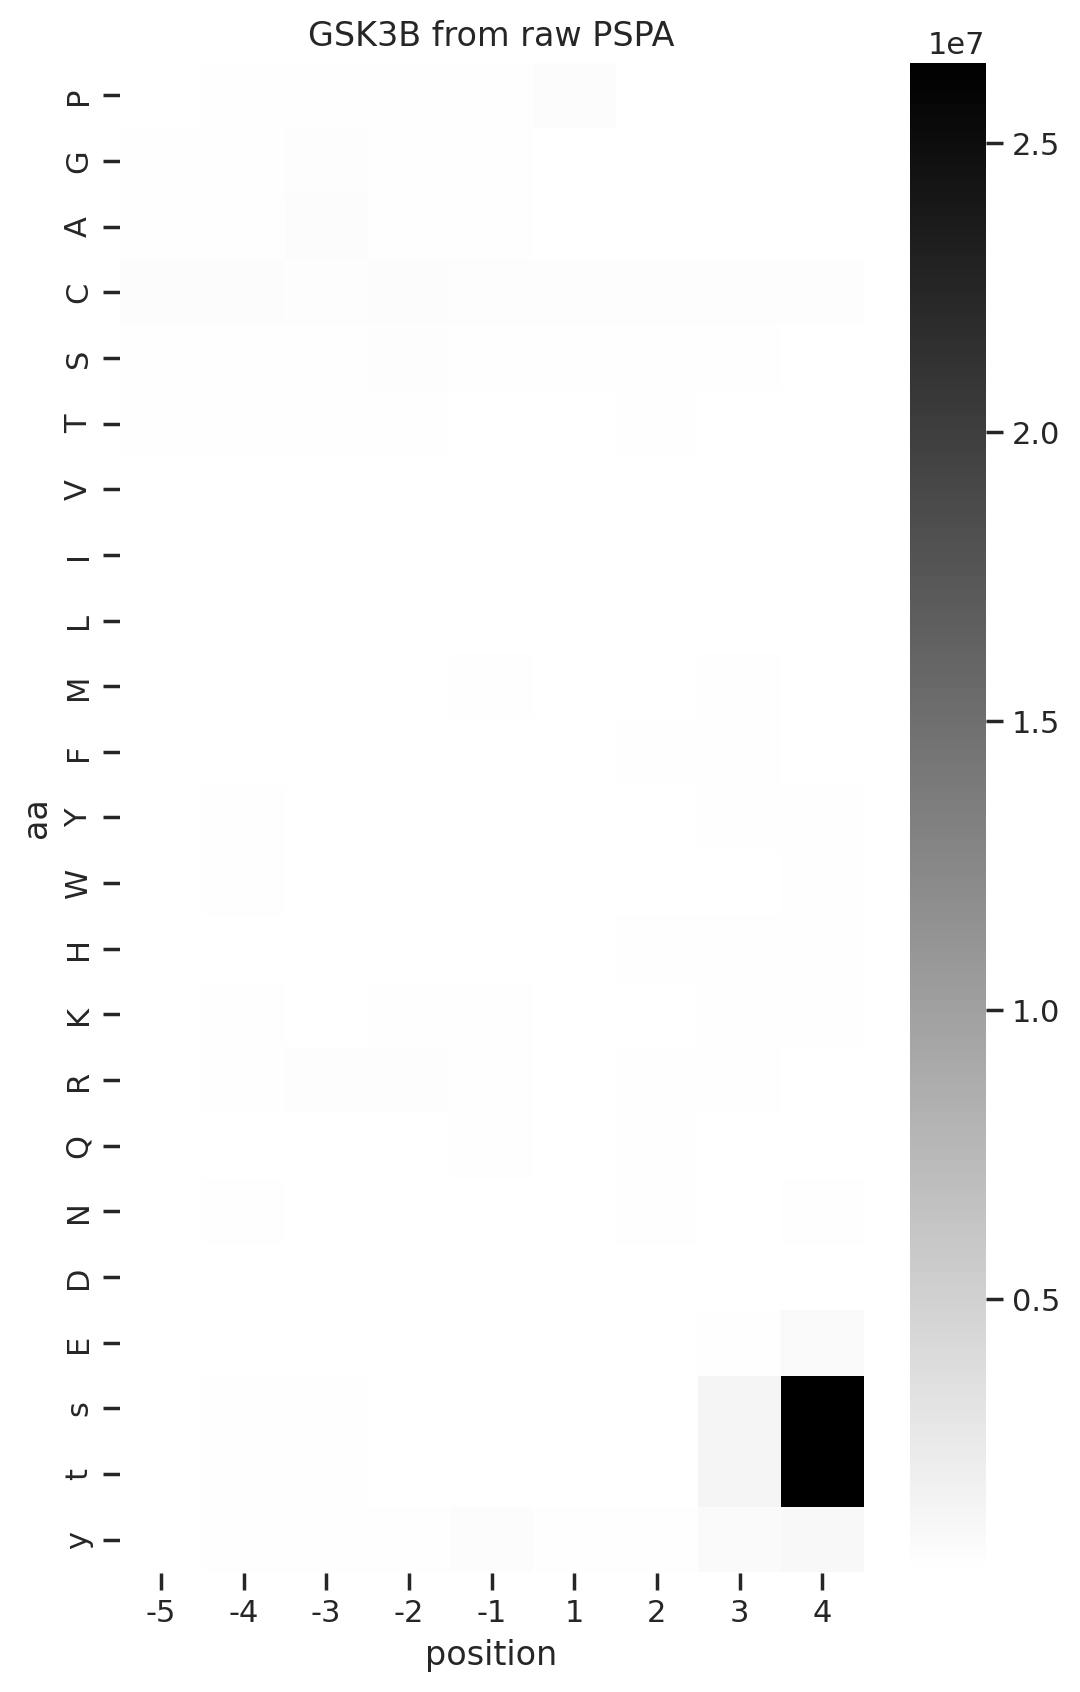

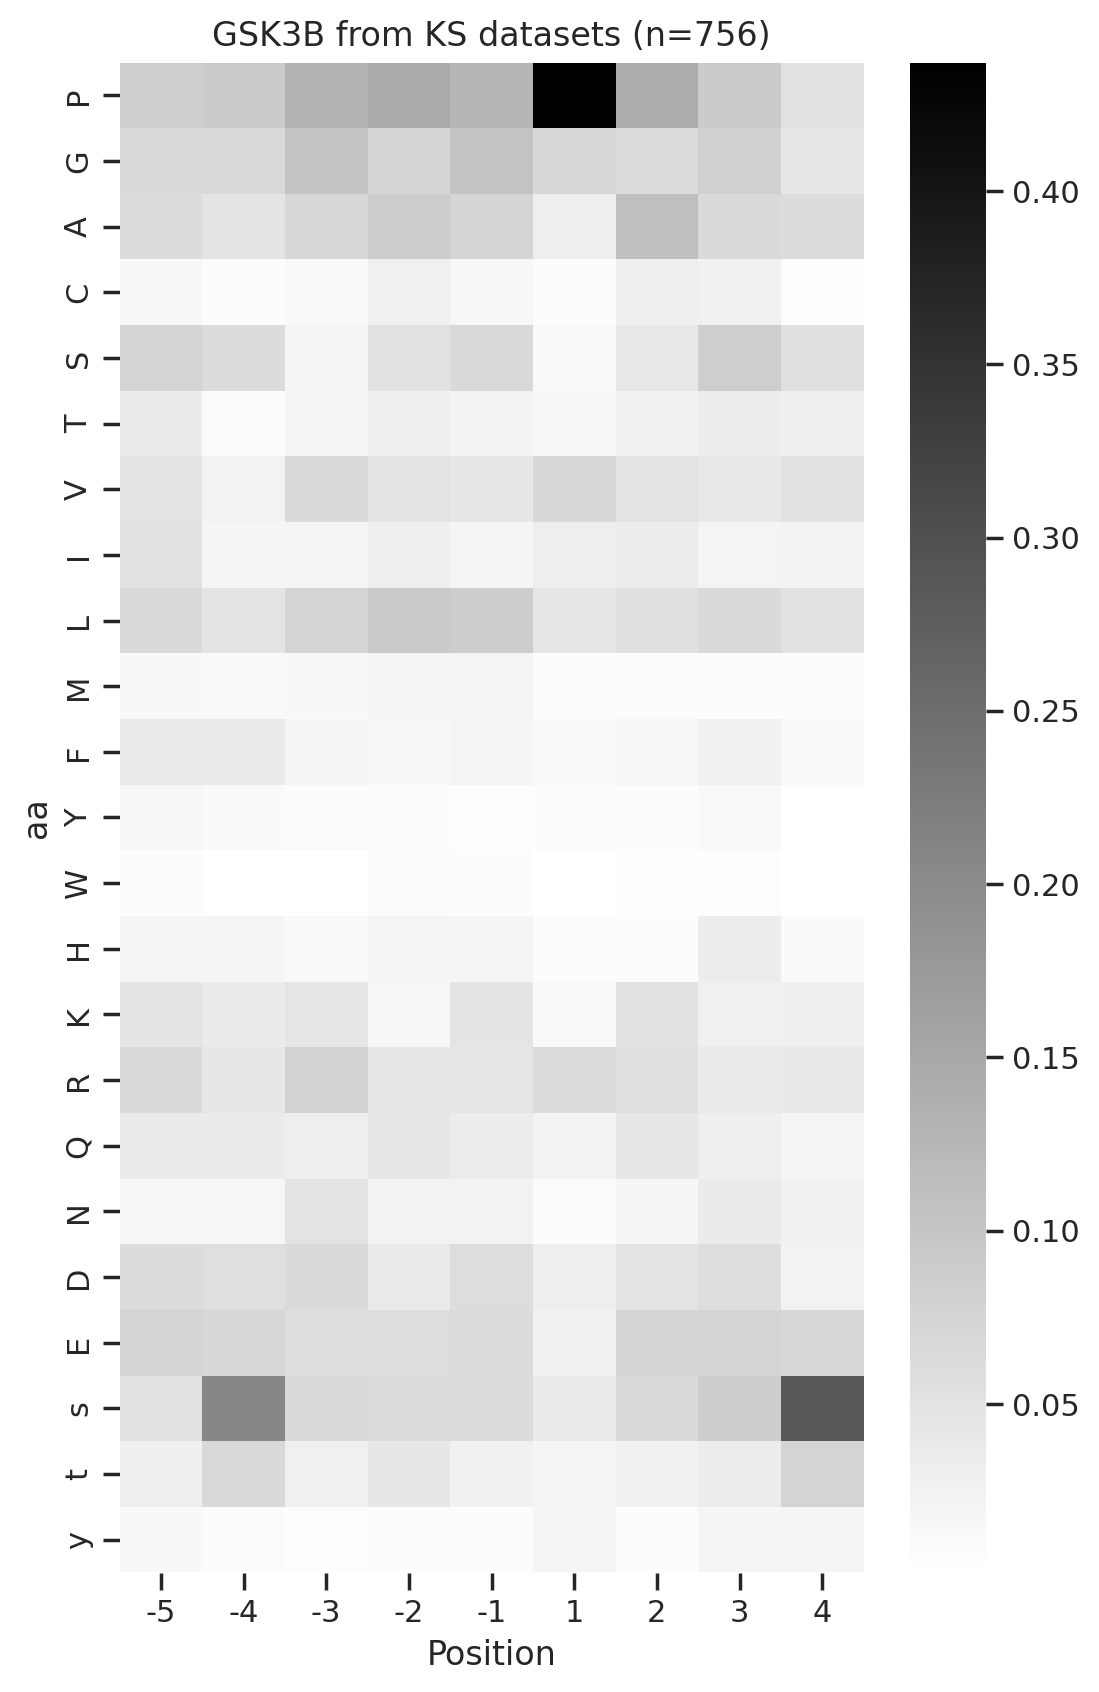

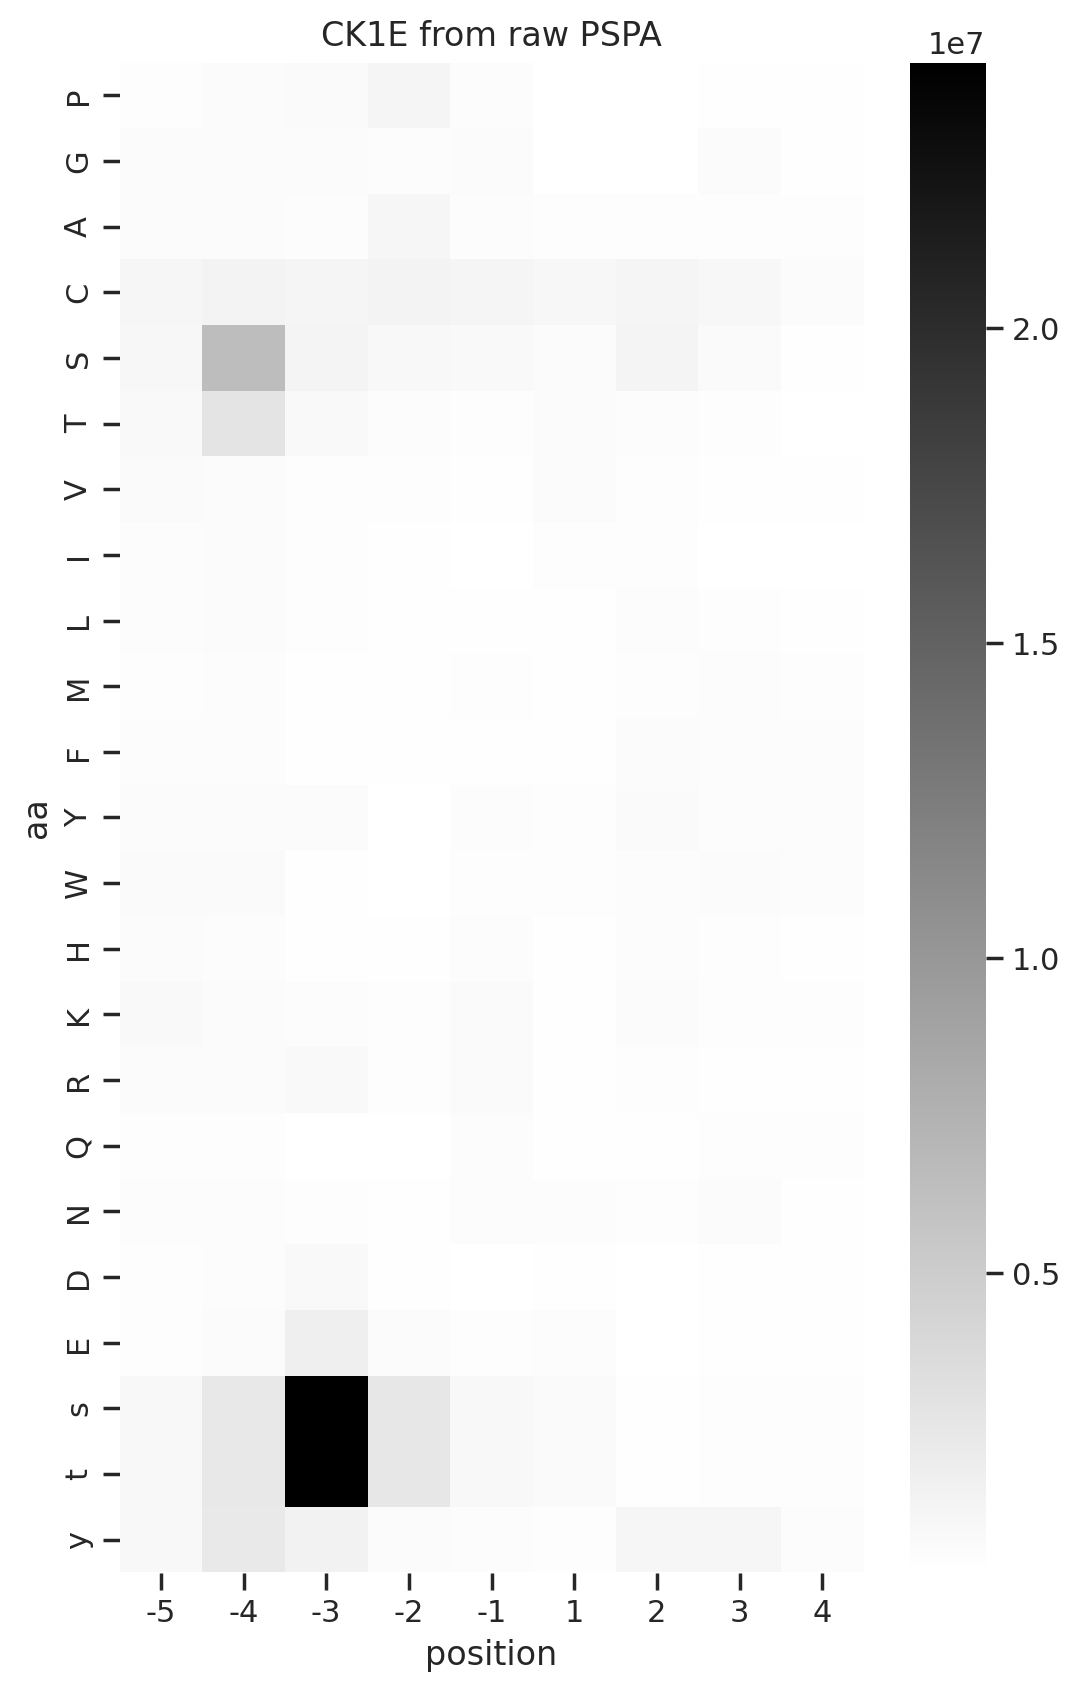

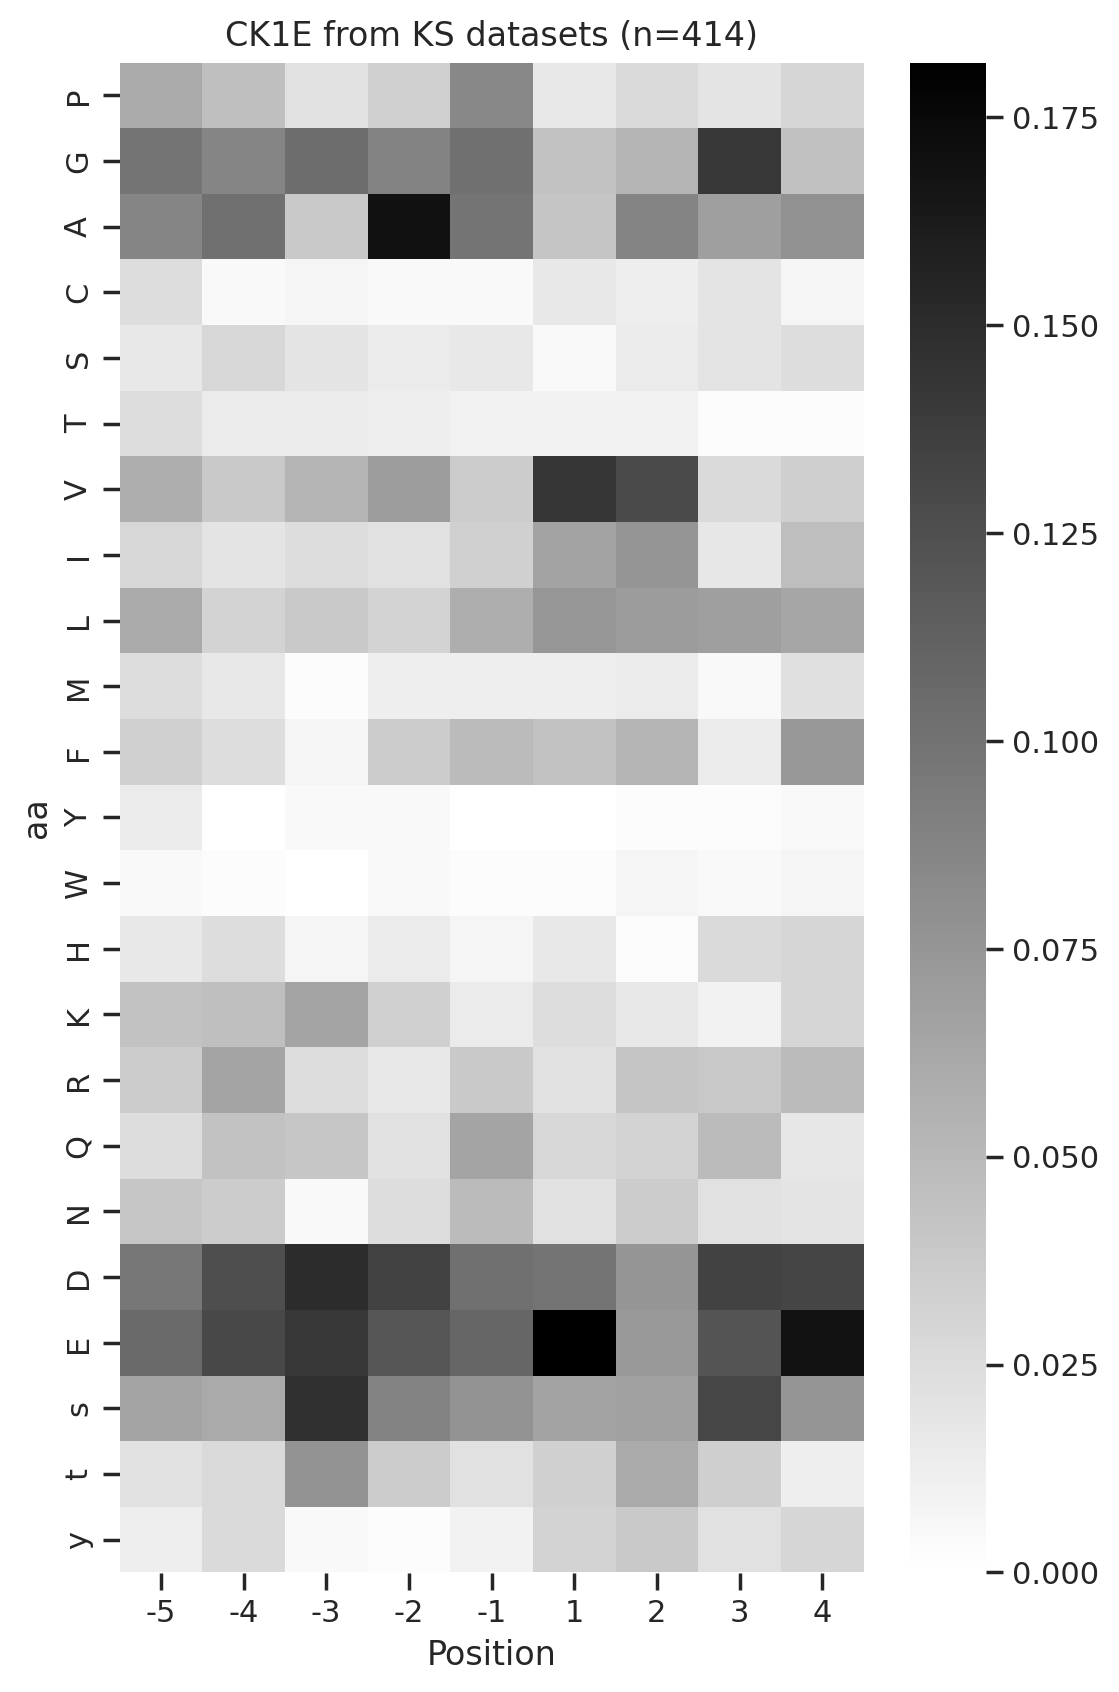

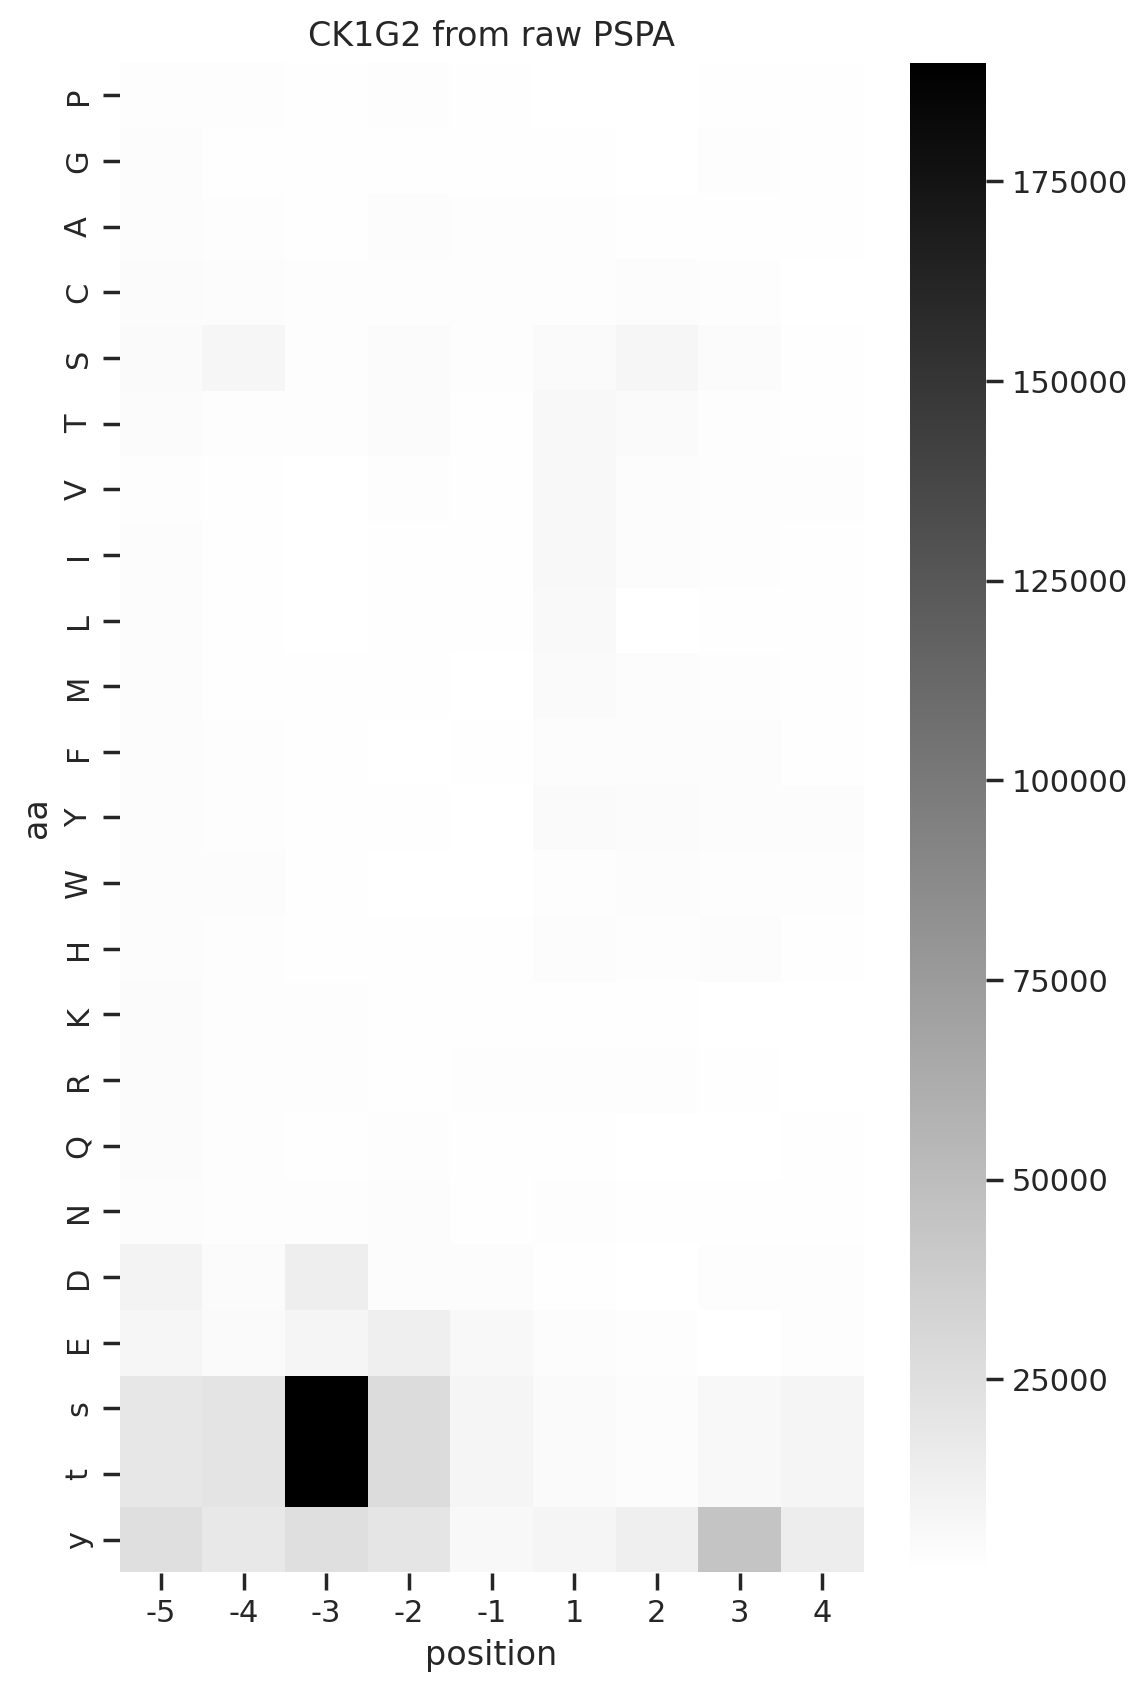

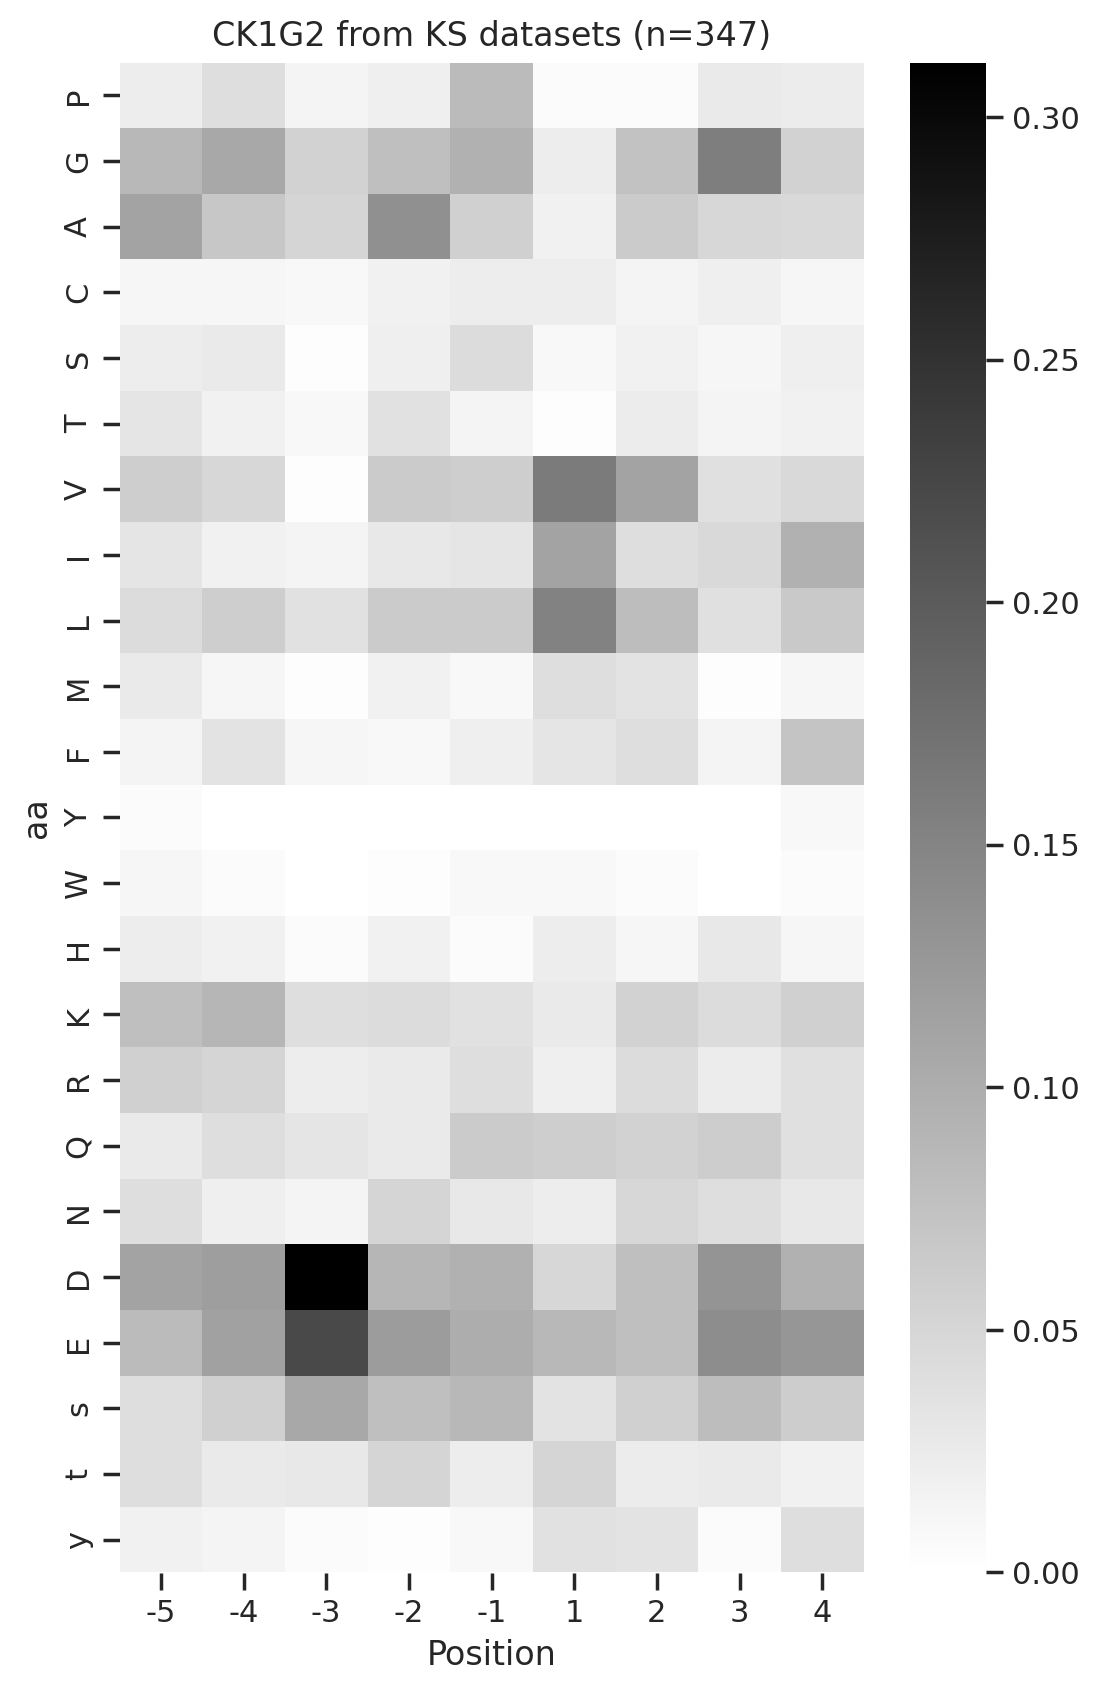

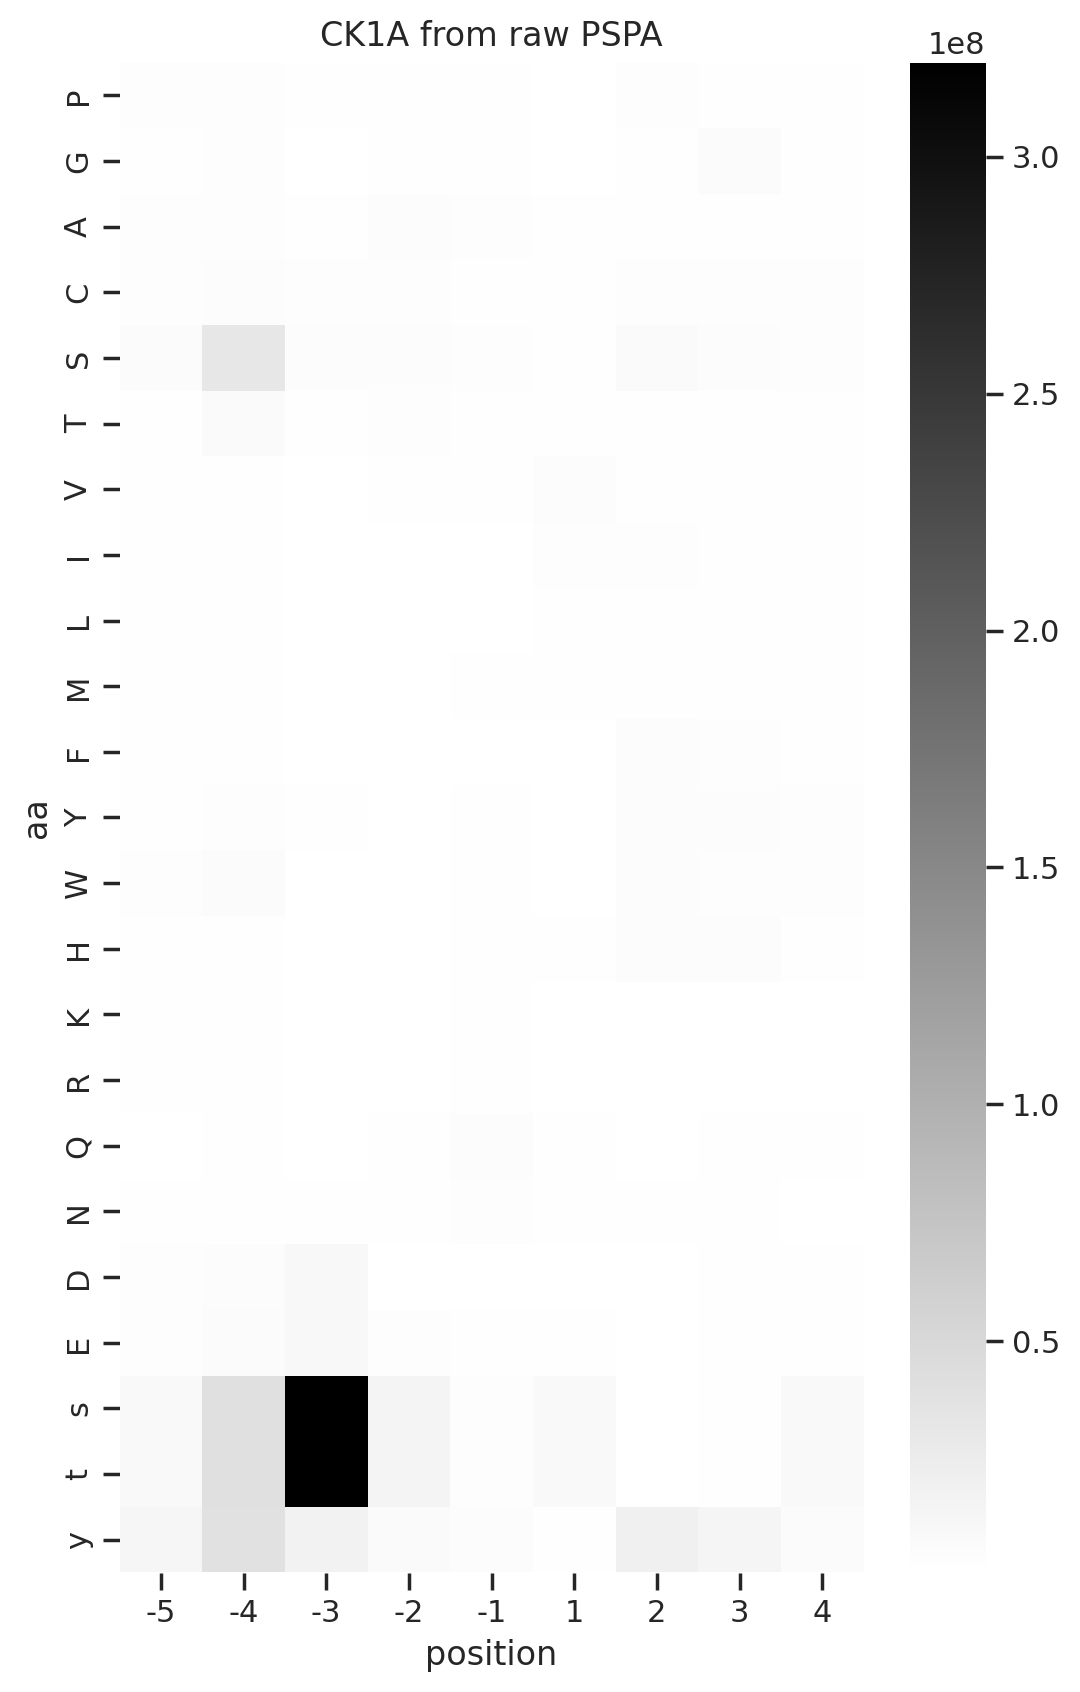

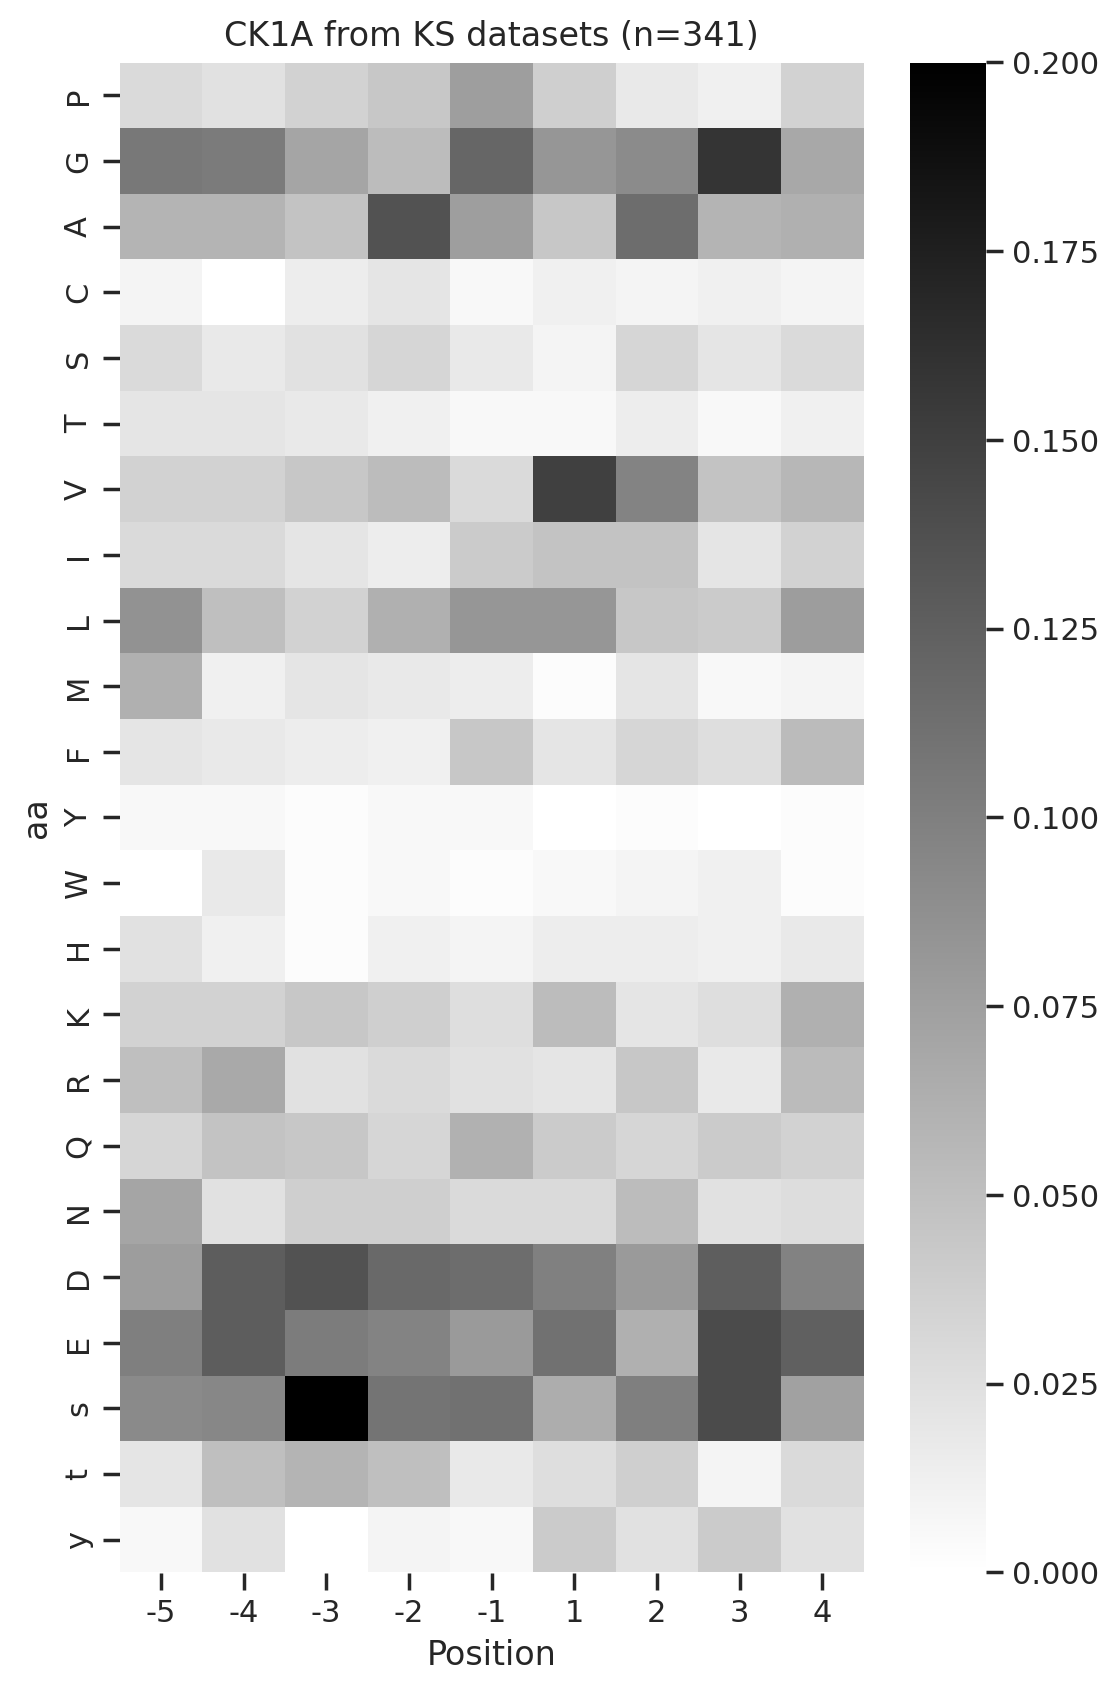

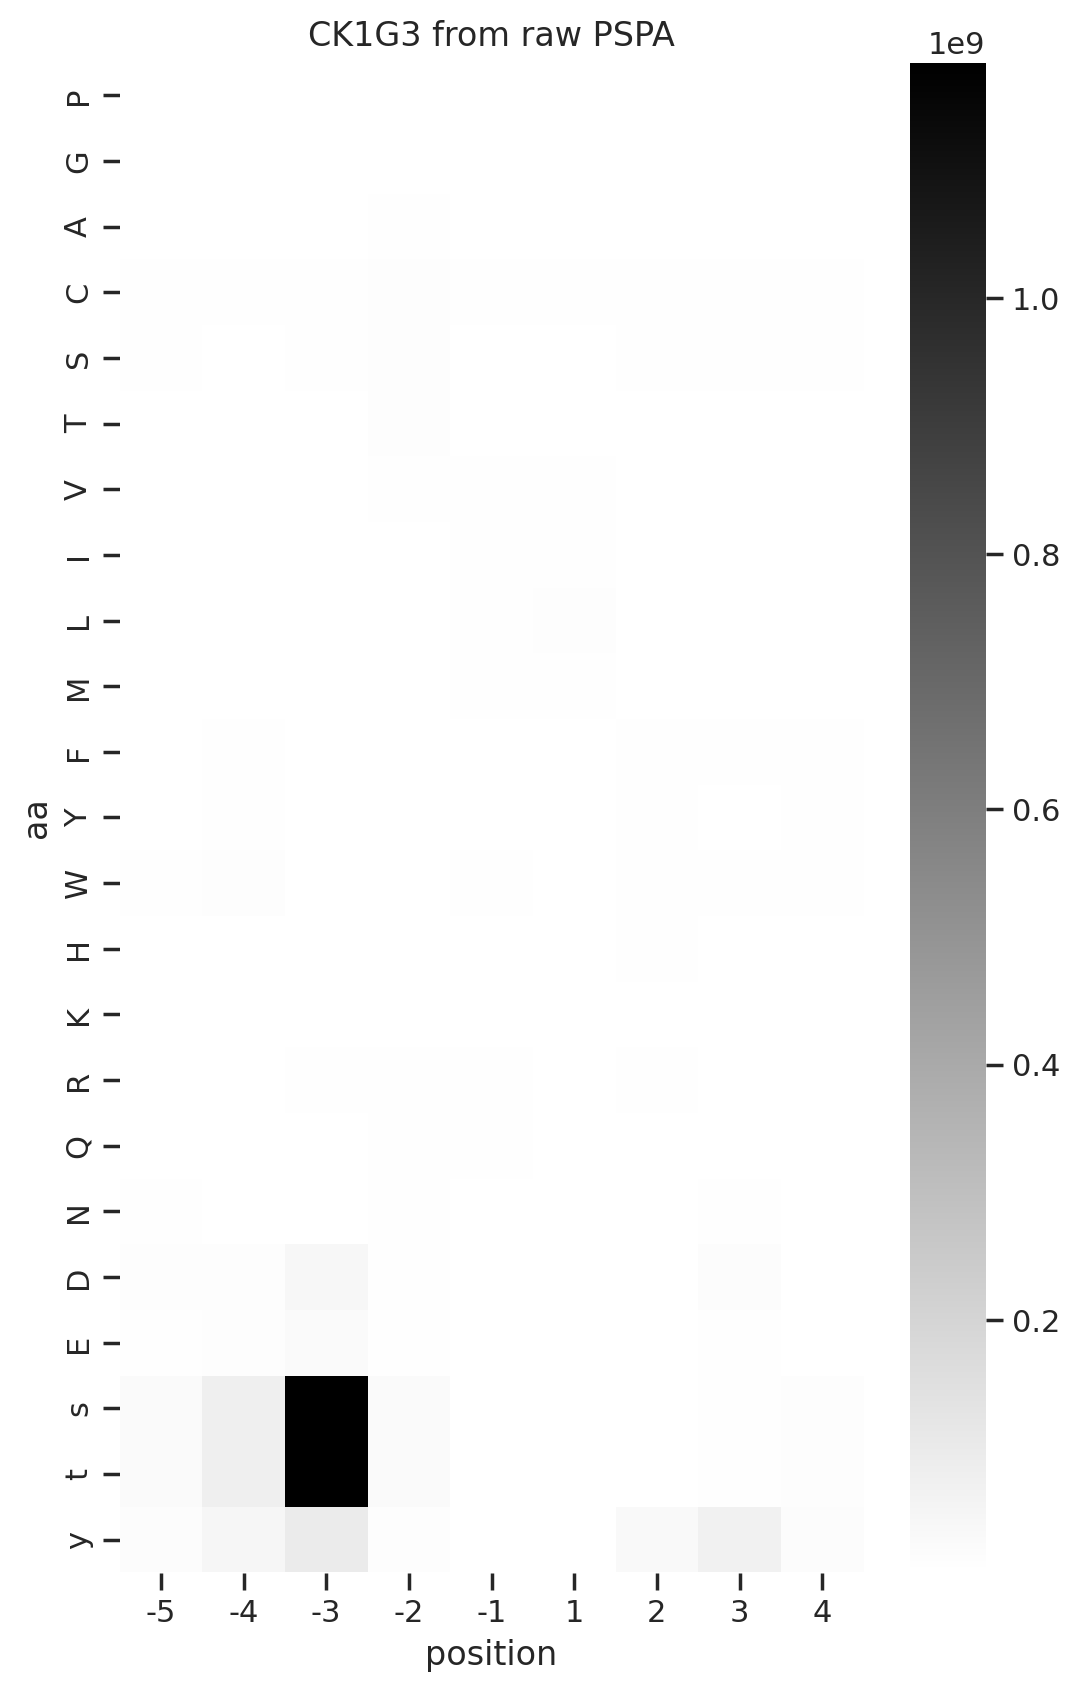

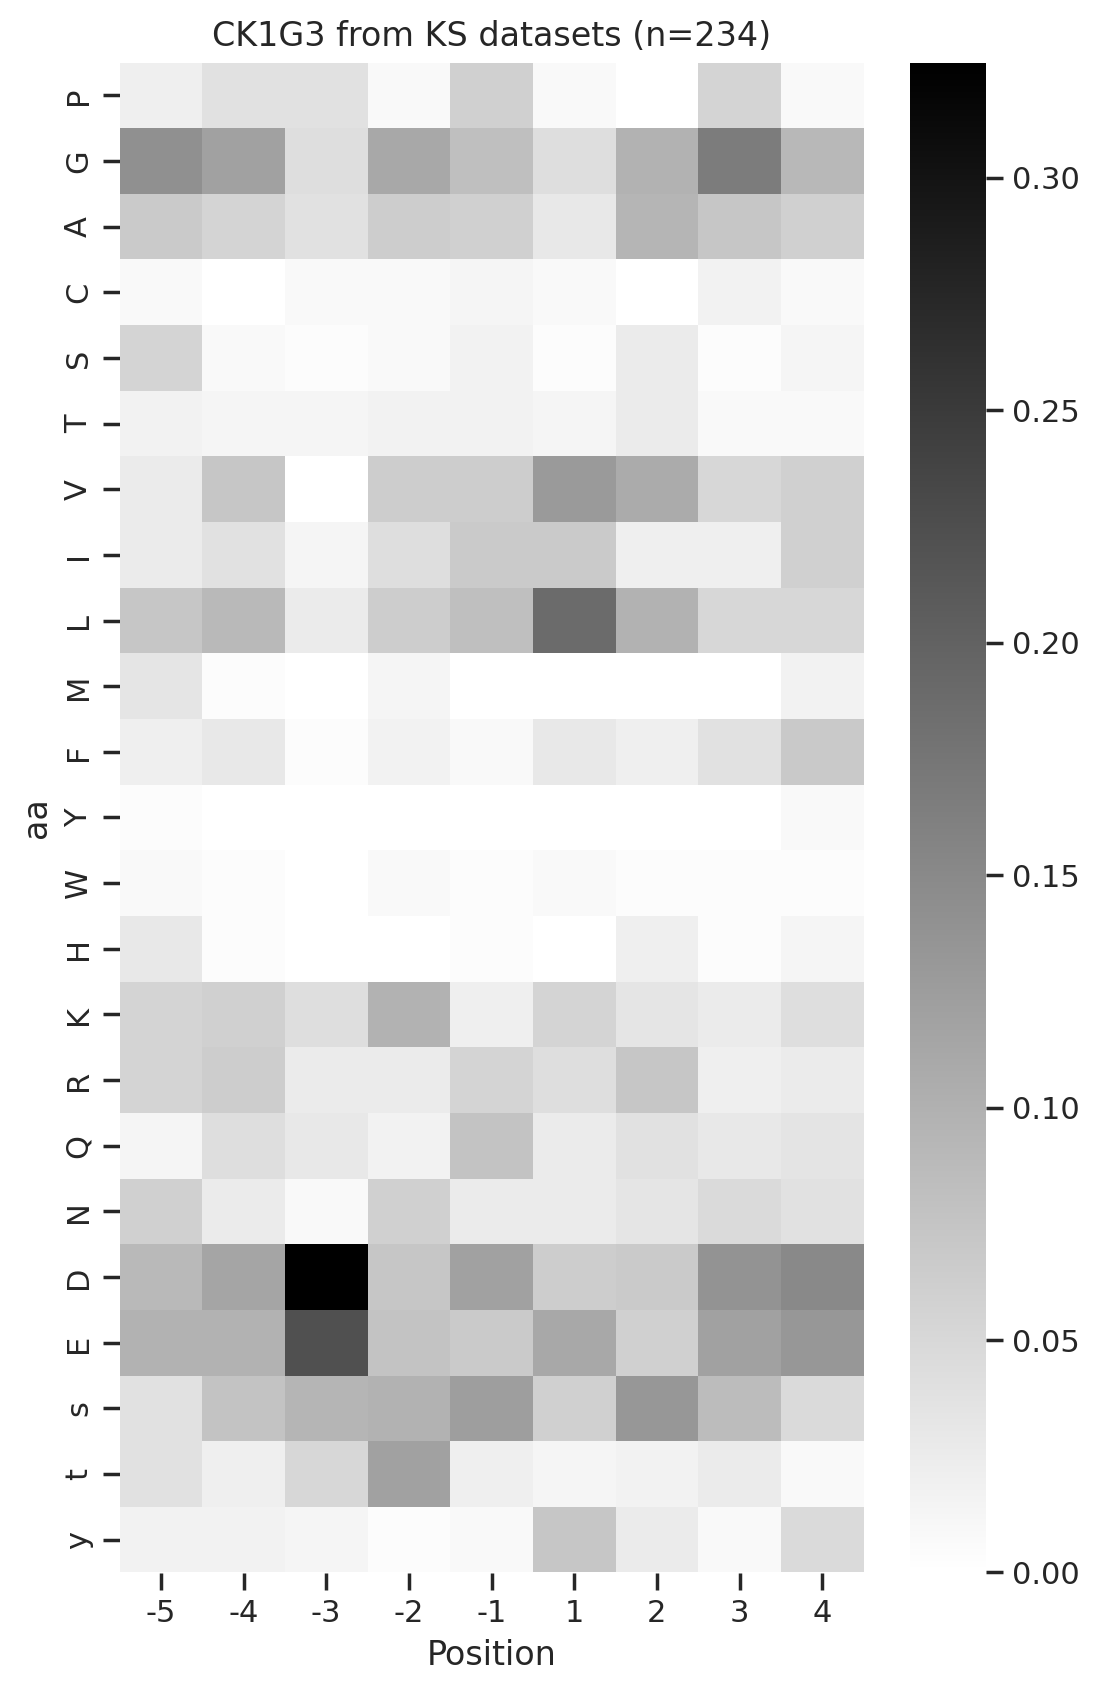

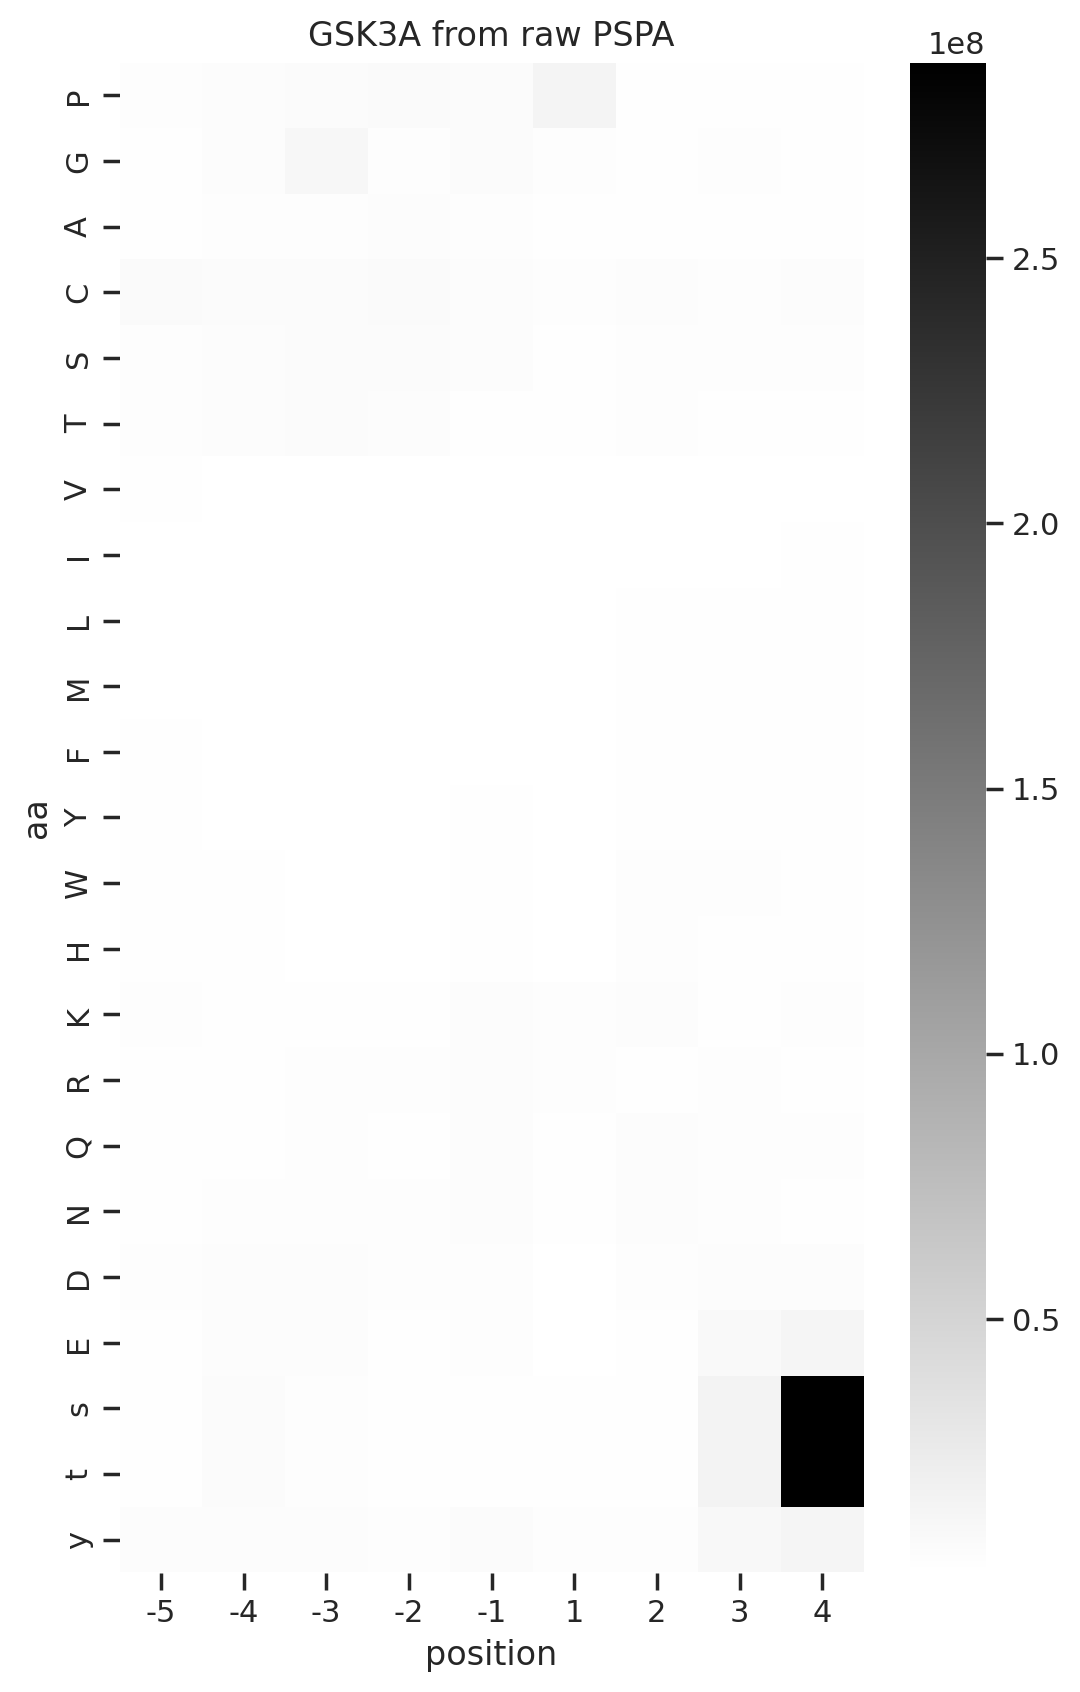

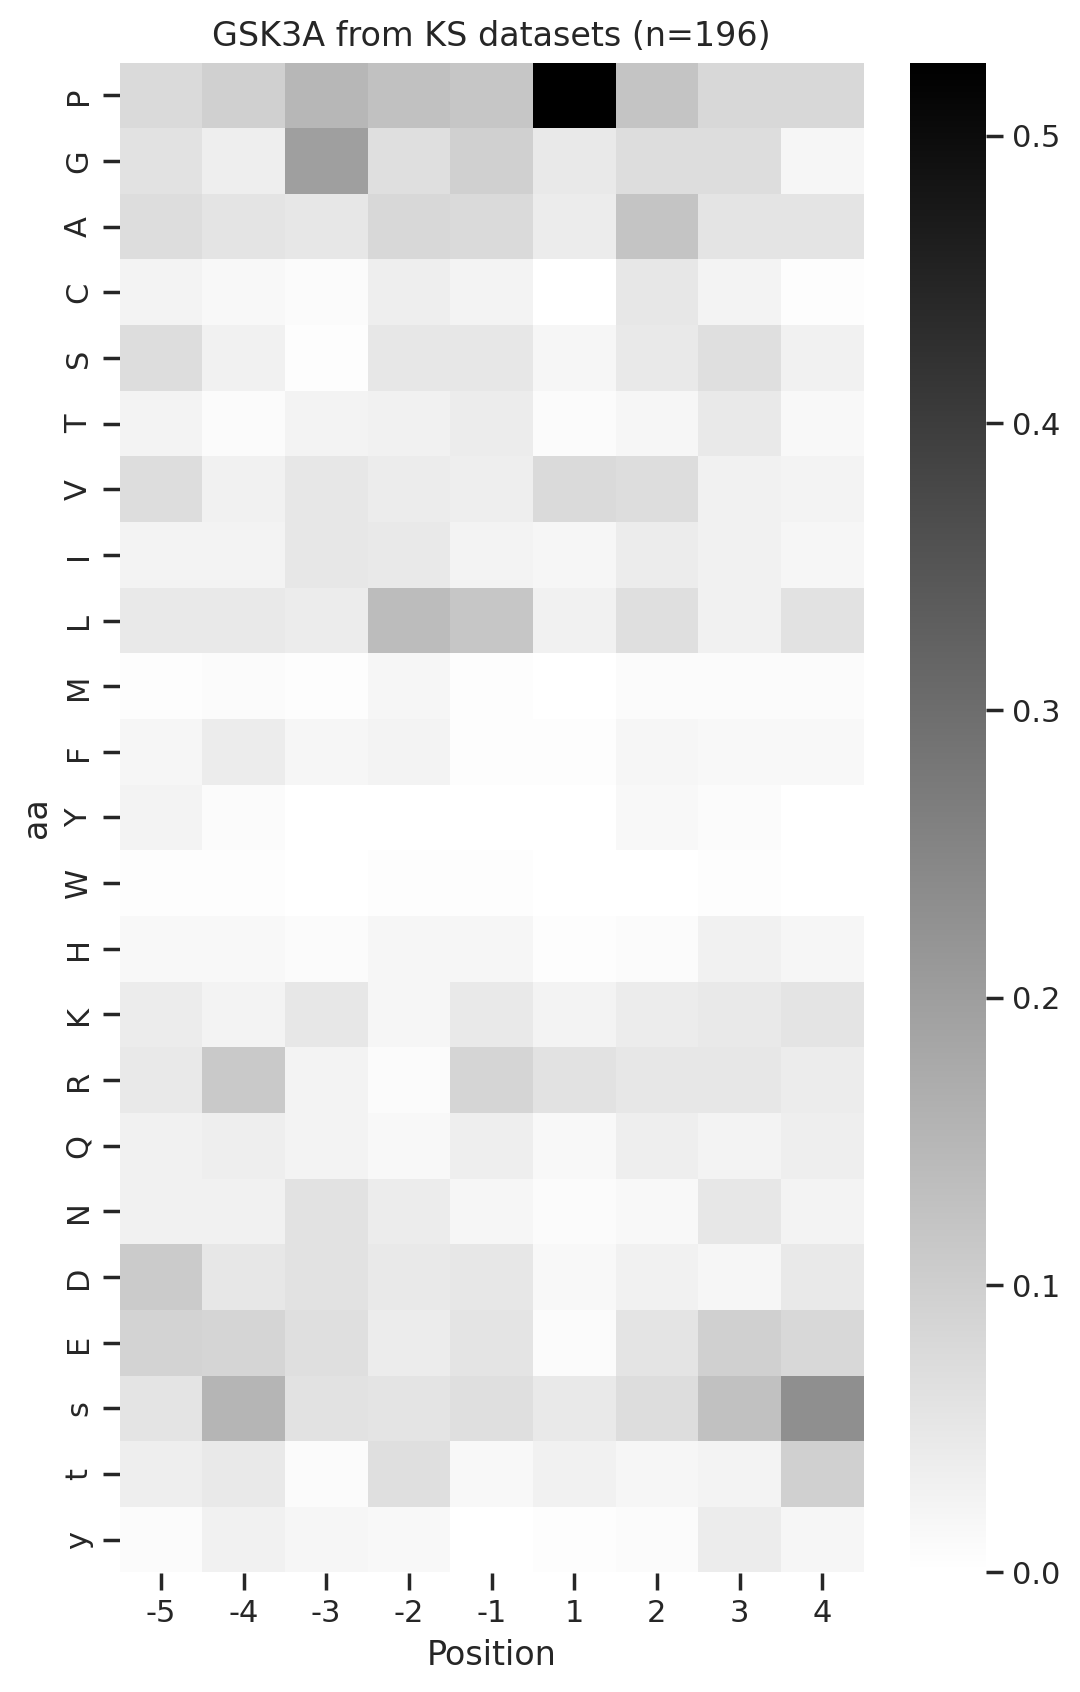

In [ ]:
# Examples of data
for k in corr.query('corr_with_raw<0.4 & specificity>0.6').kinase:
    
    df_k=df.query(f'kinase_paper == "{k}"')
    paper, full = get_freq(df_k)

    raw_k = get_one_kinase(raw,k,drop_s=False).T
    raw_k = raw_k.reindex(index=aa_order_paper)
    
    plot_heatmap(raw_k,f'{k} from raw PSPA')
    plot_heatmap(paper,f'{k} from KS datasets (n={len(df_k)})')

### Scoring of well-known site

In [ ]:
ref= Data.get_ks()

pspa=Data.get_pspa()

pspa_original = Data.get_pspa_original()

In [ ]:
site = "QQQsyLDsGIHsGAT" #CTNN1B S33

In [ ]:
site = "yLDsGIHsGATtTAP" #CTNN1B S37

In [ ]:
site = "GIHsGATtTAPsLsG" #CTNN1B T41

In [ ]:
site = "GATttAPsLsGkGNP" #CTNN1B S45 CK1A

In [ ]:
site = convert_string(site)
site

'GATttAPsLsGKGNP'

In [ ]:
predict_kinase(site,pspa_original,multiply)[:10]

100%|██████████| 303/303 [00:00<00:00, 9315.55it/s]

calculated string: ['-5T', '-4t', '-3t', '-2A', '-1P', '0s', '1L', '2s', '3G', '4K']


kinase
CK1A     11.343
CK1G3    10.001
CK1G2     9.771
CK1G1     9.412
CK1D      9.409
CK1A2     8.953
CK1E      8.500
YANK2     5.574
YANK3     5.127
GRK3      3.340
dtype: float64

In [ ]:
predict_kinase(site,pspa)[:10]

100%|██████████| 303/303 [00:00<00:00, 9974.13it/s]

calculated string: ['-5T', '-4t', '-3t', '-2A', '-1P', '0s', '1L', '2s', '3G', '4K']


kinase
CK1A     1.825
CK1G1    1.794
CK1E     1.627
CK1G3    1.573
CK1A2    1.560
CK1D     1.557
CK1G2    1.477
KIS      1.401
IKKB     1.342
NDR2     1.332
dtype: float64

In [ ]:
predict_kinase(site,ref)[:10]

100%|██████████| 289/289 [00:00<00:00, 7411.56it/s]

calculated string: ['-7G', '-6A', '-5T', '-4t', '-3t', '-2A', '-1P', '0s', '1L', '2s', '3G', '4K', '5G', '6N', '7P']


kinase
TBK1     2.079
IKKE     1.935
PAK6     1.903
MTOR     1.897
CK1A     1.889
PAK5     1.872
RSK2     1.861
PRKX     1.858
CK1G2    1.857
PKACB    1.849
dtype: float64

In [ ]:
predict_kinase(site,ref+0.000001,multiply)[:10]

100%|██████████| 289/289 [00:00<00:00, 7196.74it/s]

calculated string: ['-7y', '-6L', '-5D', '-4s', '-3G', '-2I', '-1H', '0s', '1G', '2A', '3T', '4t', '5T', '6A', '7P']


kinase
GSK3A    1.453
GSK3B   -1.789
ERK5    -4.341
ERK2    -4.954
ERK1    -5.244
P38A    -5.460
CLK1    -5.749
TBK1    -5.775
IKKB    -5.888
JNK1    -6.269
dtype: float64

### Pearson with raw vs. Pearson with norm

In [ ]:
melt = pd.melt(corr[['corr_with_raw','corr_with_norm']])

In [ ]:
melt['variable'] = melt.variable.replace({'corr_with_raw':'raw','corr_with_norm':'normalized'})

In [ ]:
def plot_box(data,x,y,dots=True):
    if dots:
        sns.stripplot(data=data,x=x,y=y)
    sns.boxplot(data=data, x=x, y=y, palette='pastel')

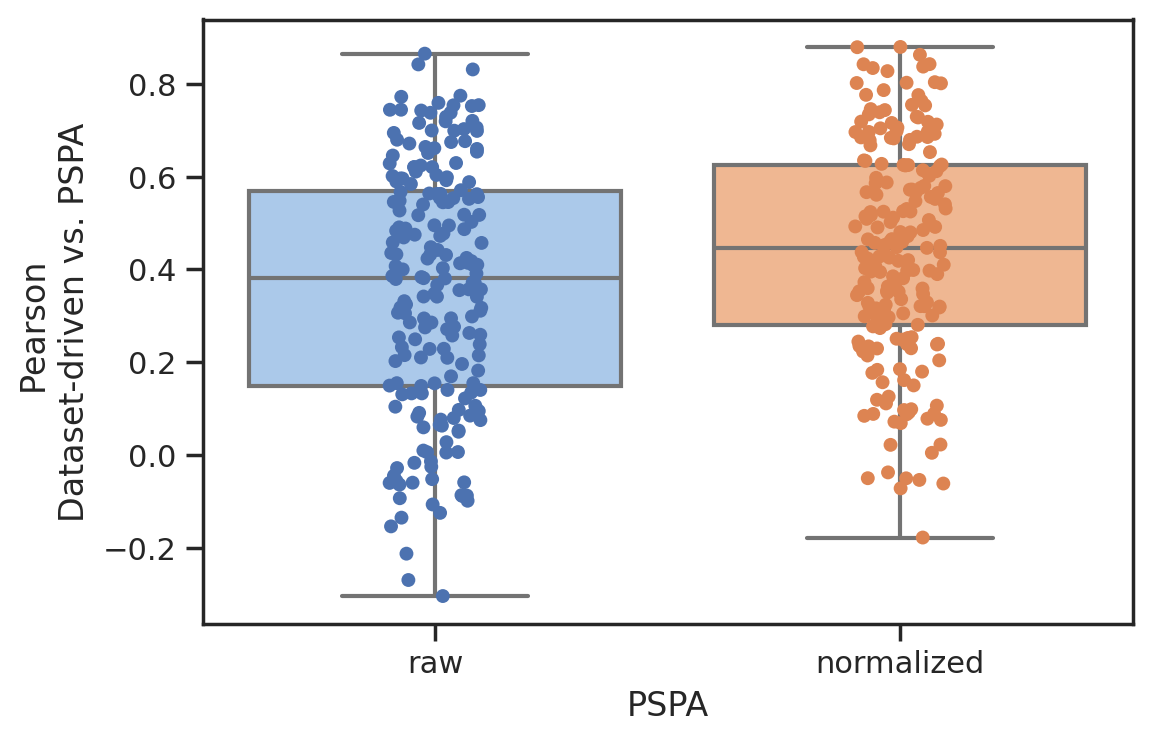

In [ ]:
plot_box(melt,'variable','value')
plt.ylabel('Pearson \nDataset-driven vs. PSPA')
plt.xlabel('PSPA');

### Plot

In [ ]:
corr

,kinase,corr_with_raw,count_combined,corr_with_norm,specificity,change_corr,S_ratio,T_ratio
0,PKACA,0.841689,1740,0.833835,0.476953,-0.007854,0.056639,0.033424
1,ERK2,0.751987,1380,0.827213,0.510499,0.075226,0.051646,0.051311
2,CDK1,0.864848,1325,0.879297,0.569784,0.014449,0.063222,0.048285
3,IKKB,0.149388,1297,0.280318,0.157279,0.130930,0.081216,0.040976
4,ERK1,0.830827,1160,0.878767,0.567533,0.047941,0.063722,0.053194
...,...,...,...,...,...,...,...,...
197,HIPK3,0.620166,110,0.679037,0.399684,0.058871,0.054908,0.049153
198,CDK8,0.305177,107,0.384925,0.542519,0.079748,0.073872,0.041969
199,BUB1,0.154635,106,0.179524,0.240232,0.024889,0.048003,0.042768
200,MEKK3,-0.093351,104,0.022305,0.127274,0.115656,0.051621,0.068361


### Check if changed pearson is correlated with specificity

In [ ]:
corr['change_corr'] = corr['corr_with_norm'] - corr['corr_with_raw']

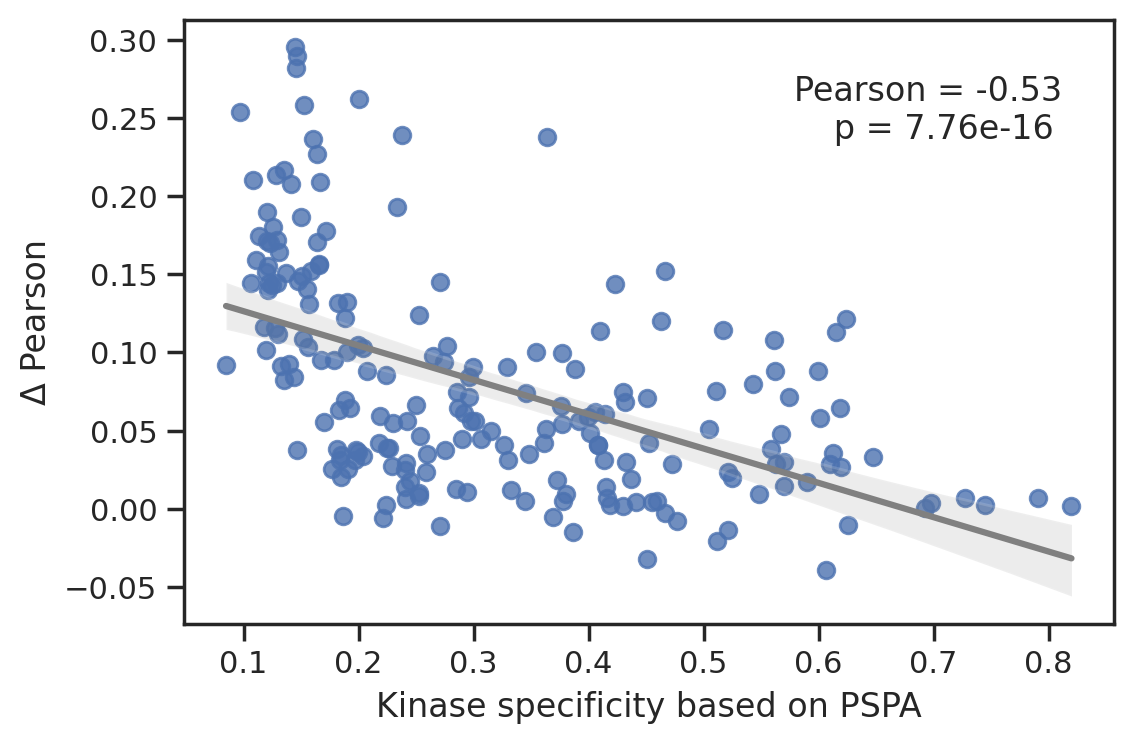

In [ ]:
plot_corr(y=corr.change_corr,x=corr.specificity,text_location=[0.8,0.85])
plt.xlabel('Kinase specificity based on PSPA')
plt.ylabel('Δ Pearson');

Text(0.5, 0, 'Kinase specificity')

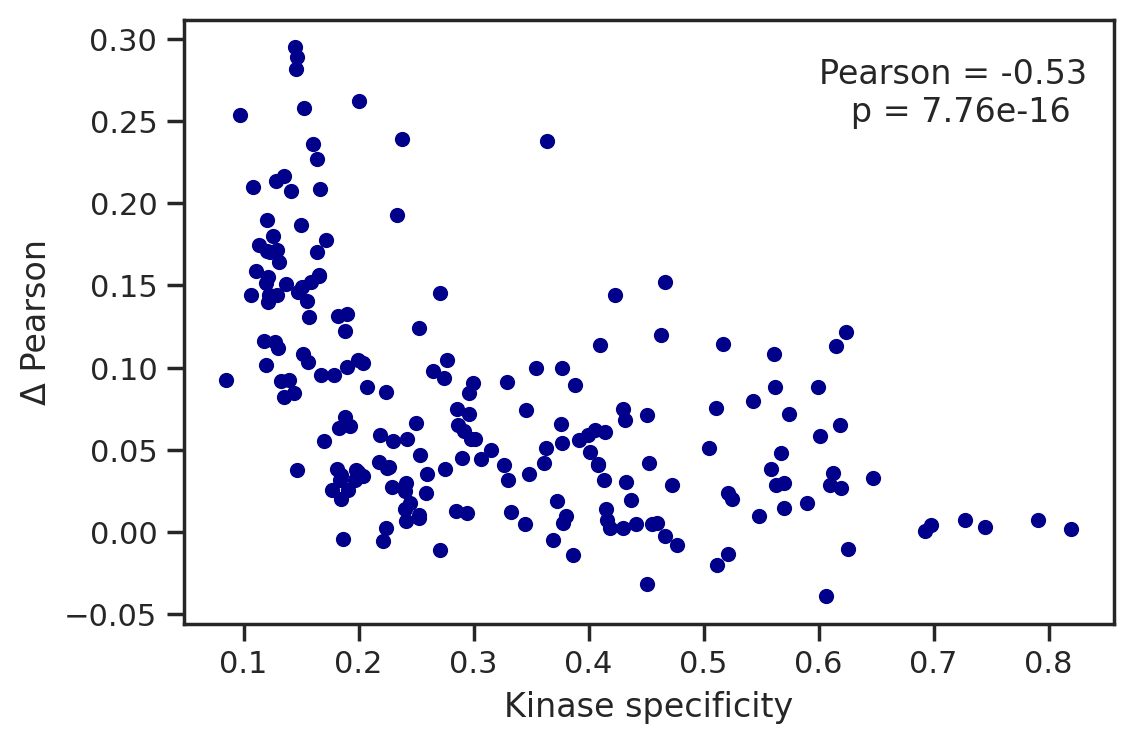

In [ ]:
corr.plot.scatter(y='change_corr',x='specificity',c='darkblue')
pear,pvalue = pearsonr(corr.change_corr,corr.specificity)
plt.text(s=f'Pearson = {round(pear,2)}\n   p = {"{:.2e}".format(pvalue)}',x=0.6,y=0.25)
plt.ylabel('Δ Pearson')
plt.xlabel('Kinase specificity')

In [ ]:
# corr.to_csv('PSSM_vs_dataset_summary.csv',index=False)

### Find out the factor that cause the biggest change in correlation

Plot the kinase with biggest change in pearson after normalization

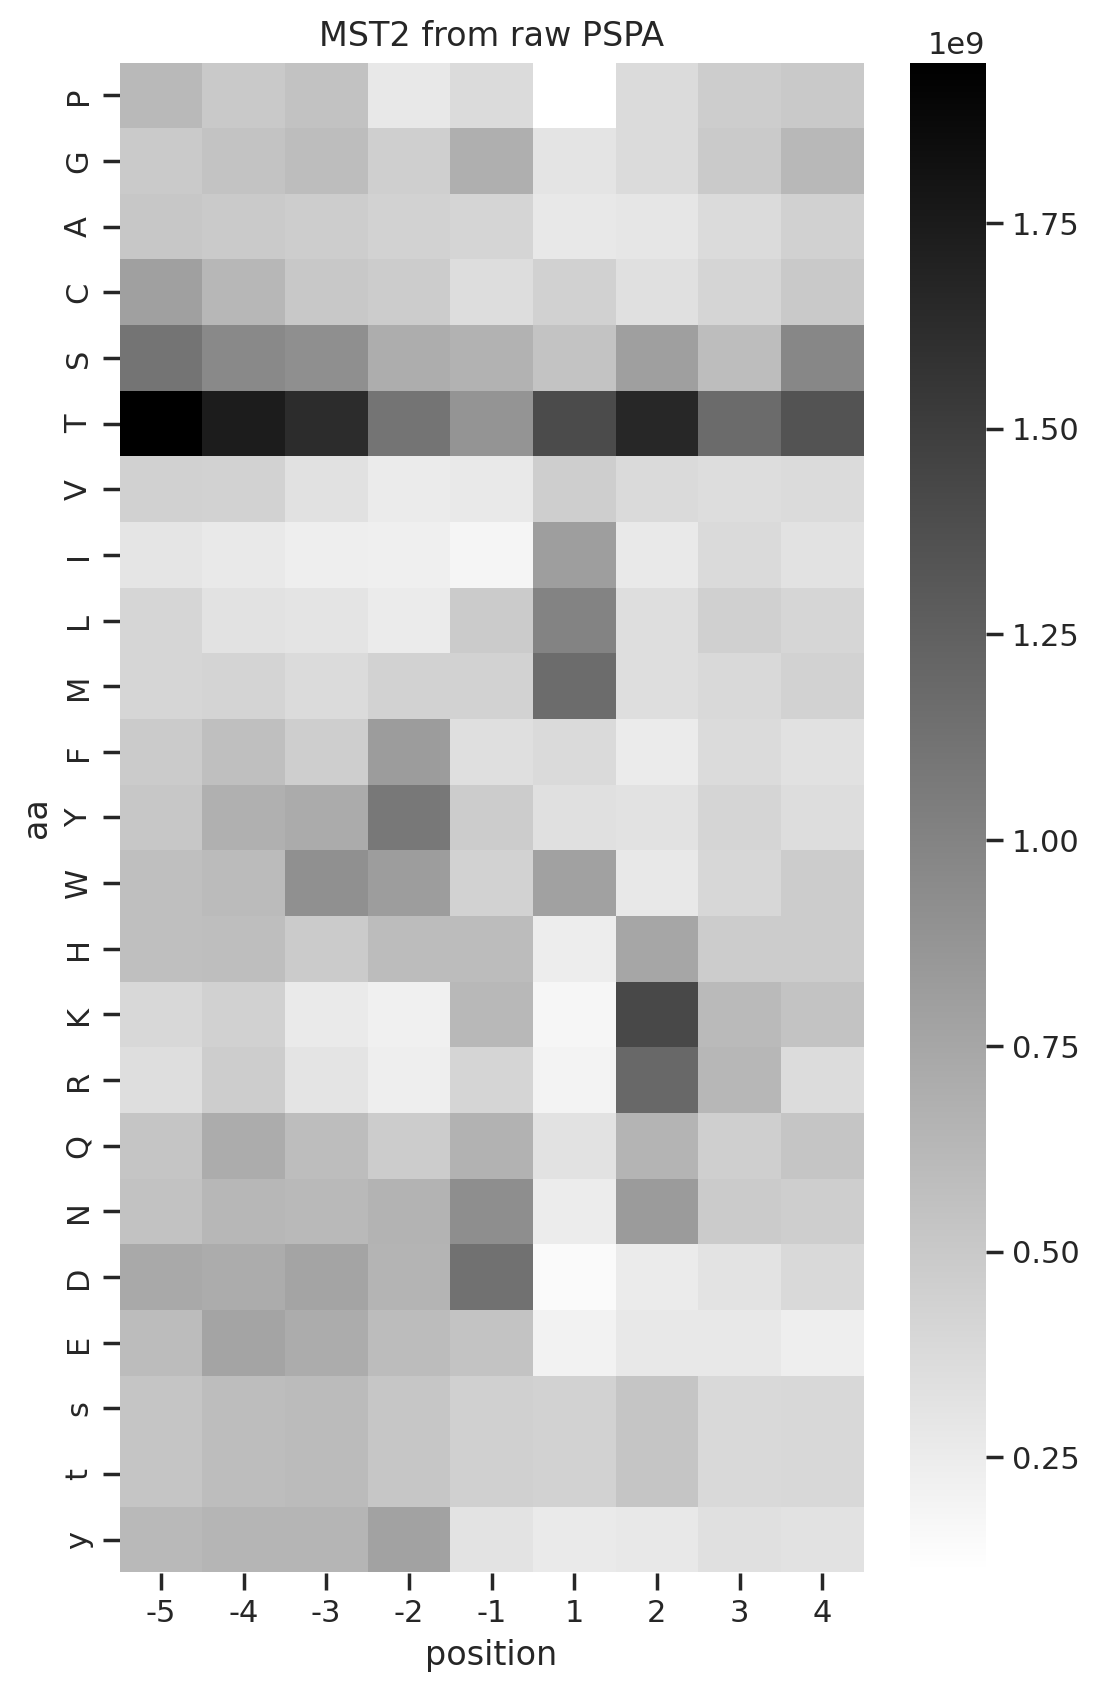

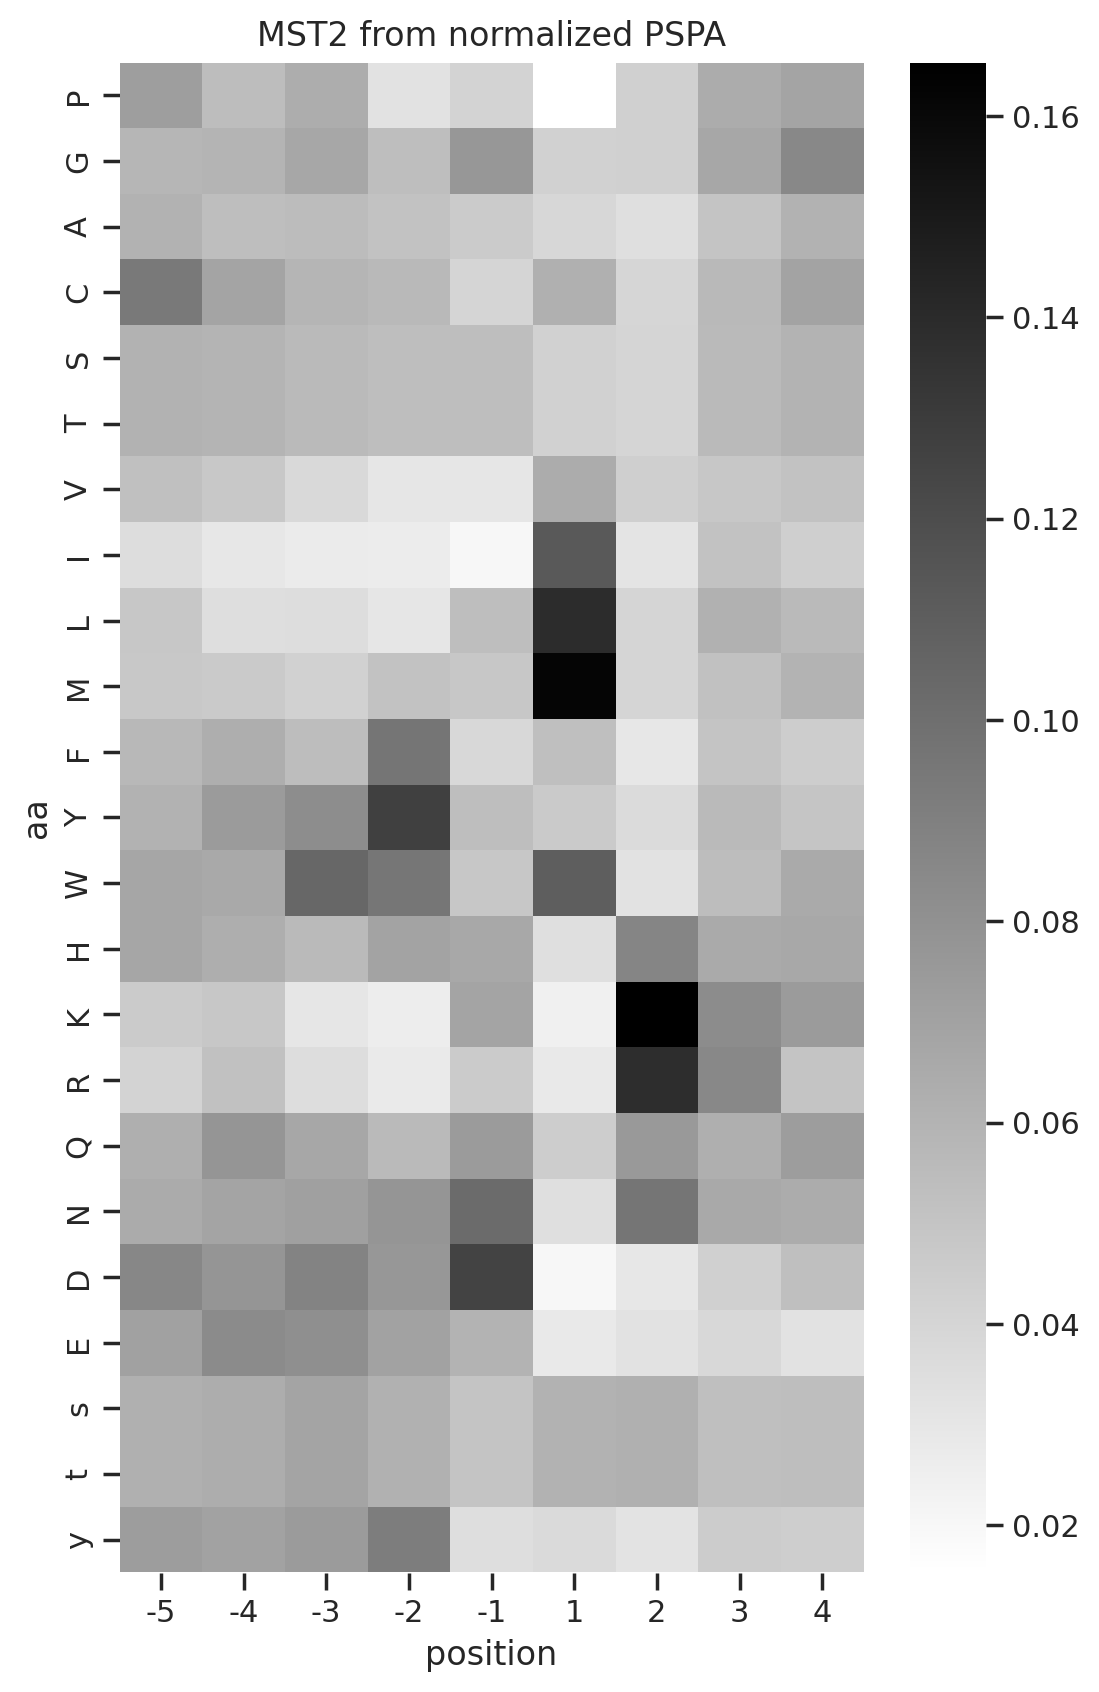

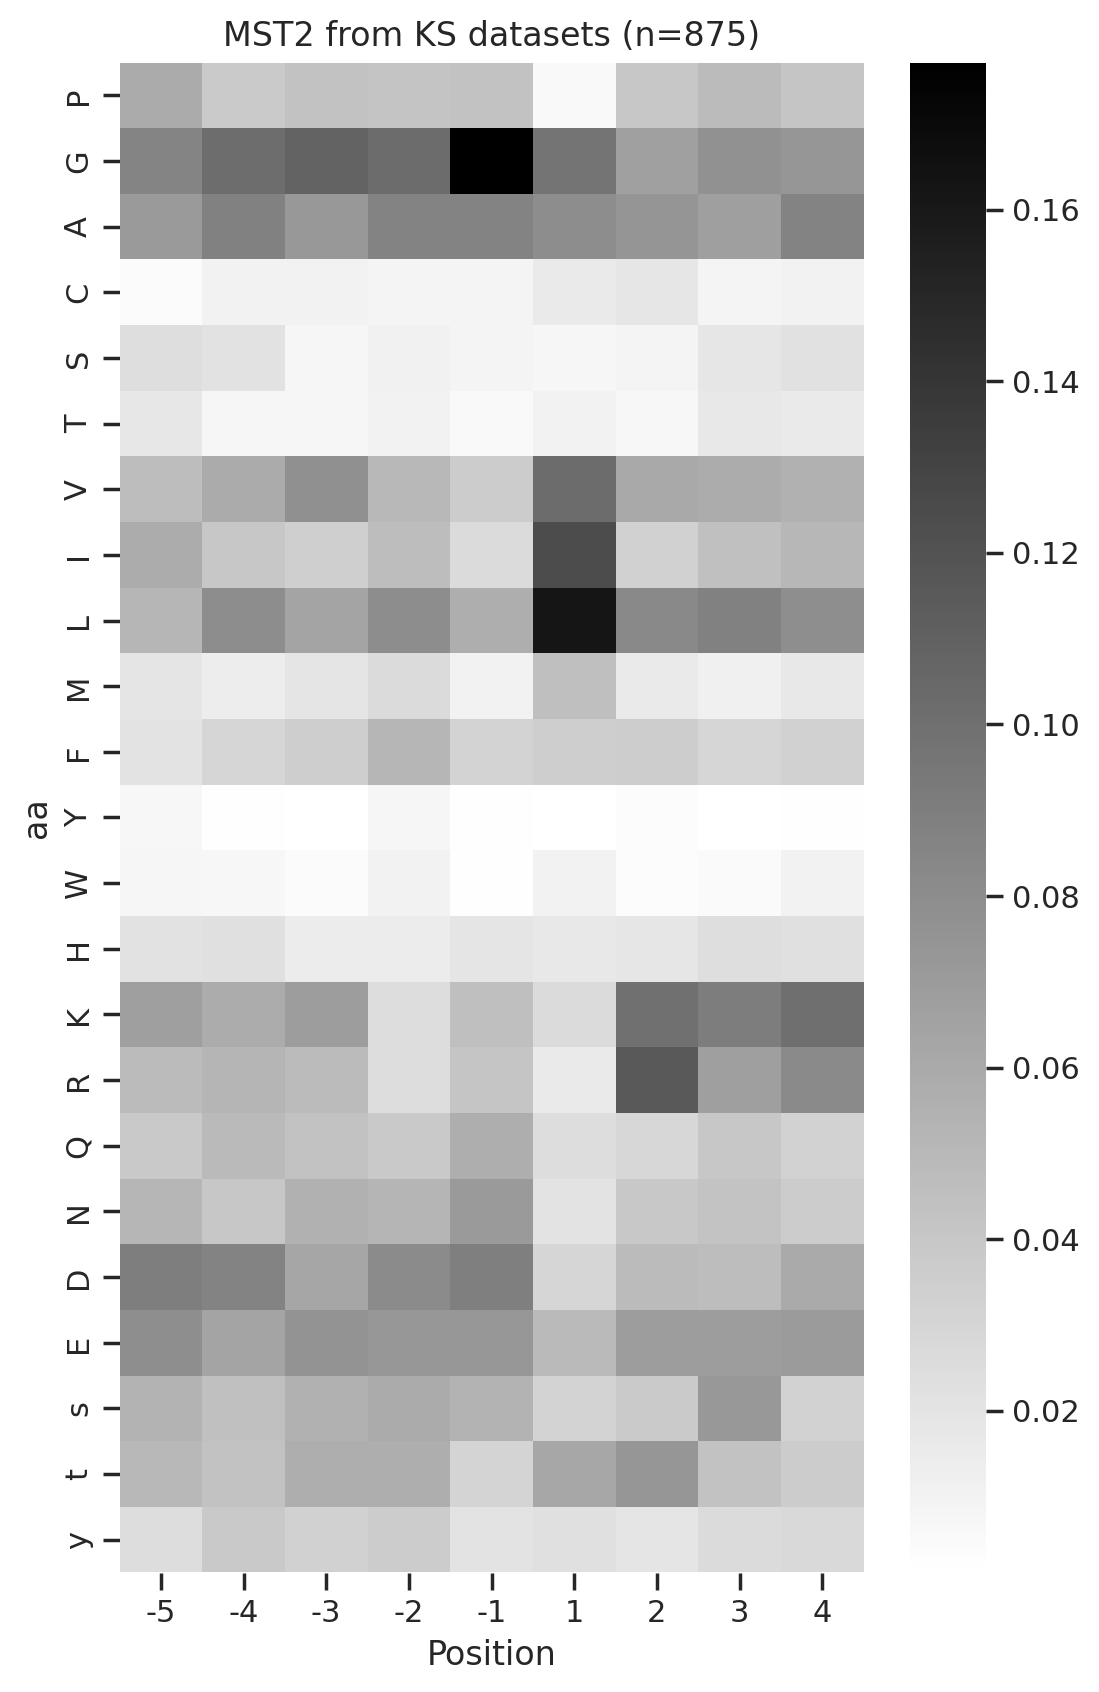

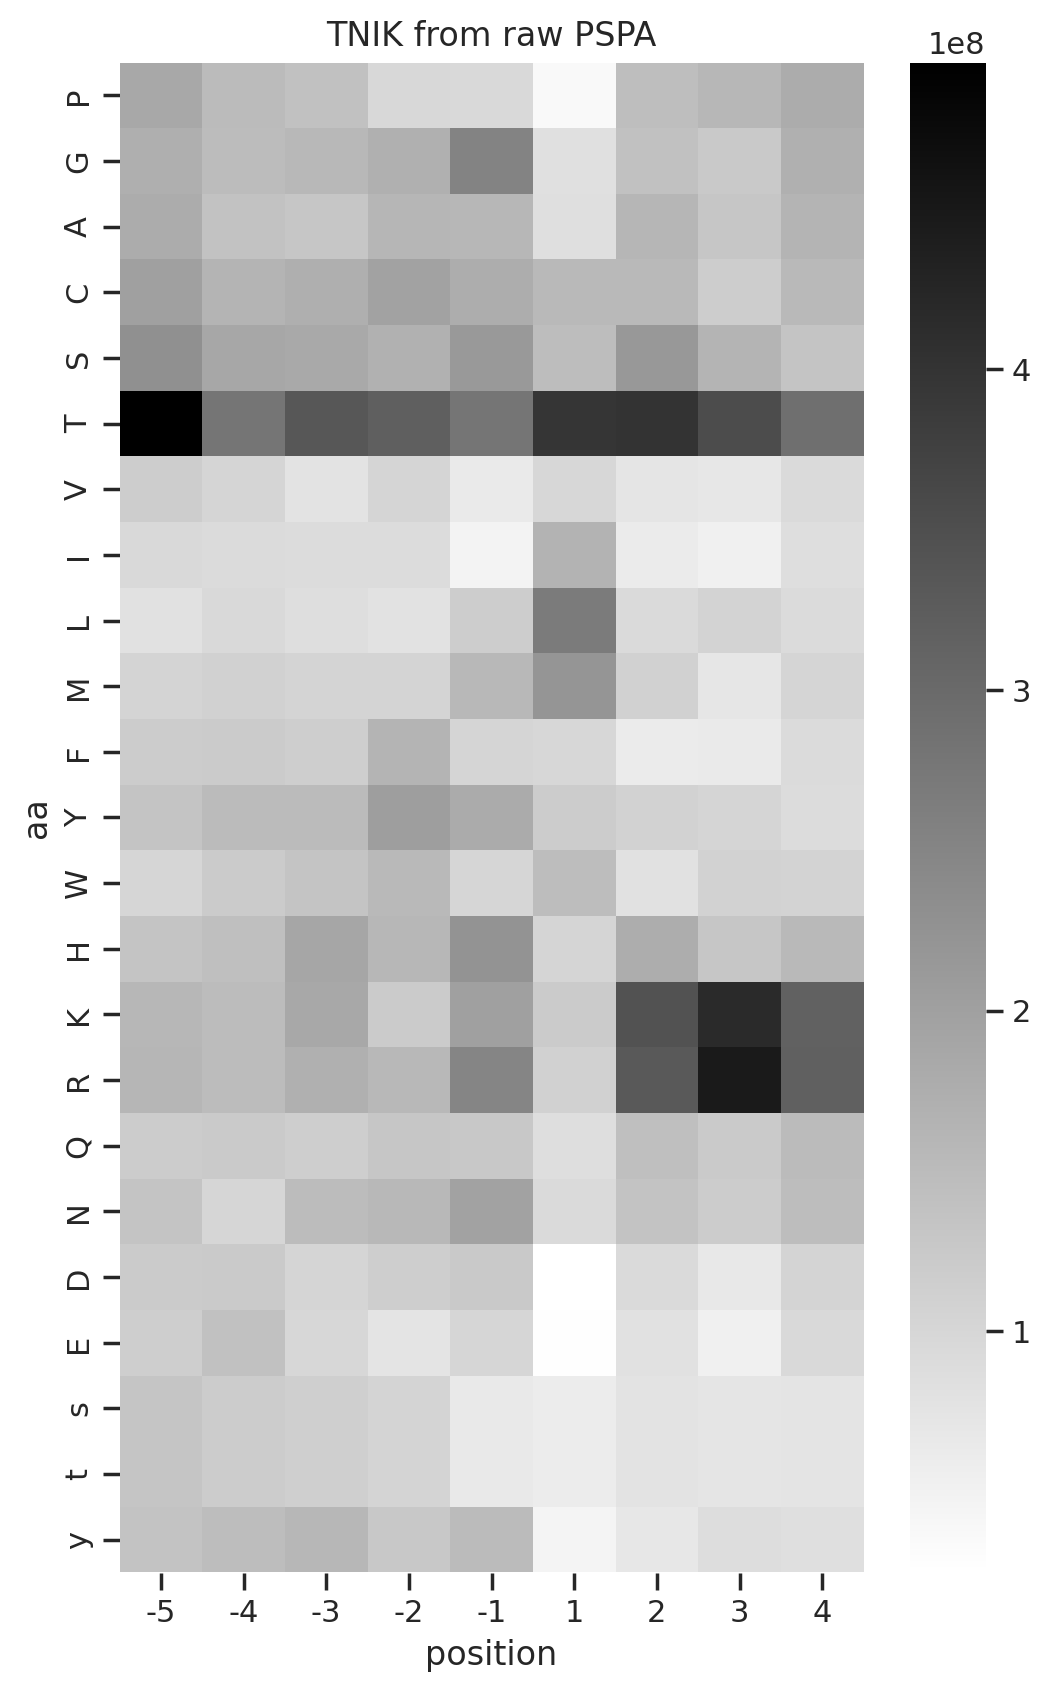

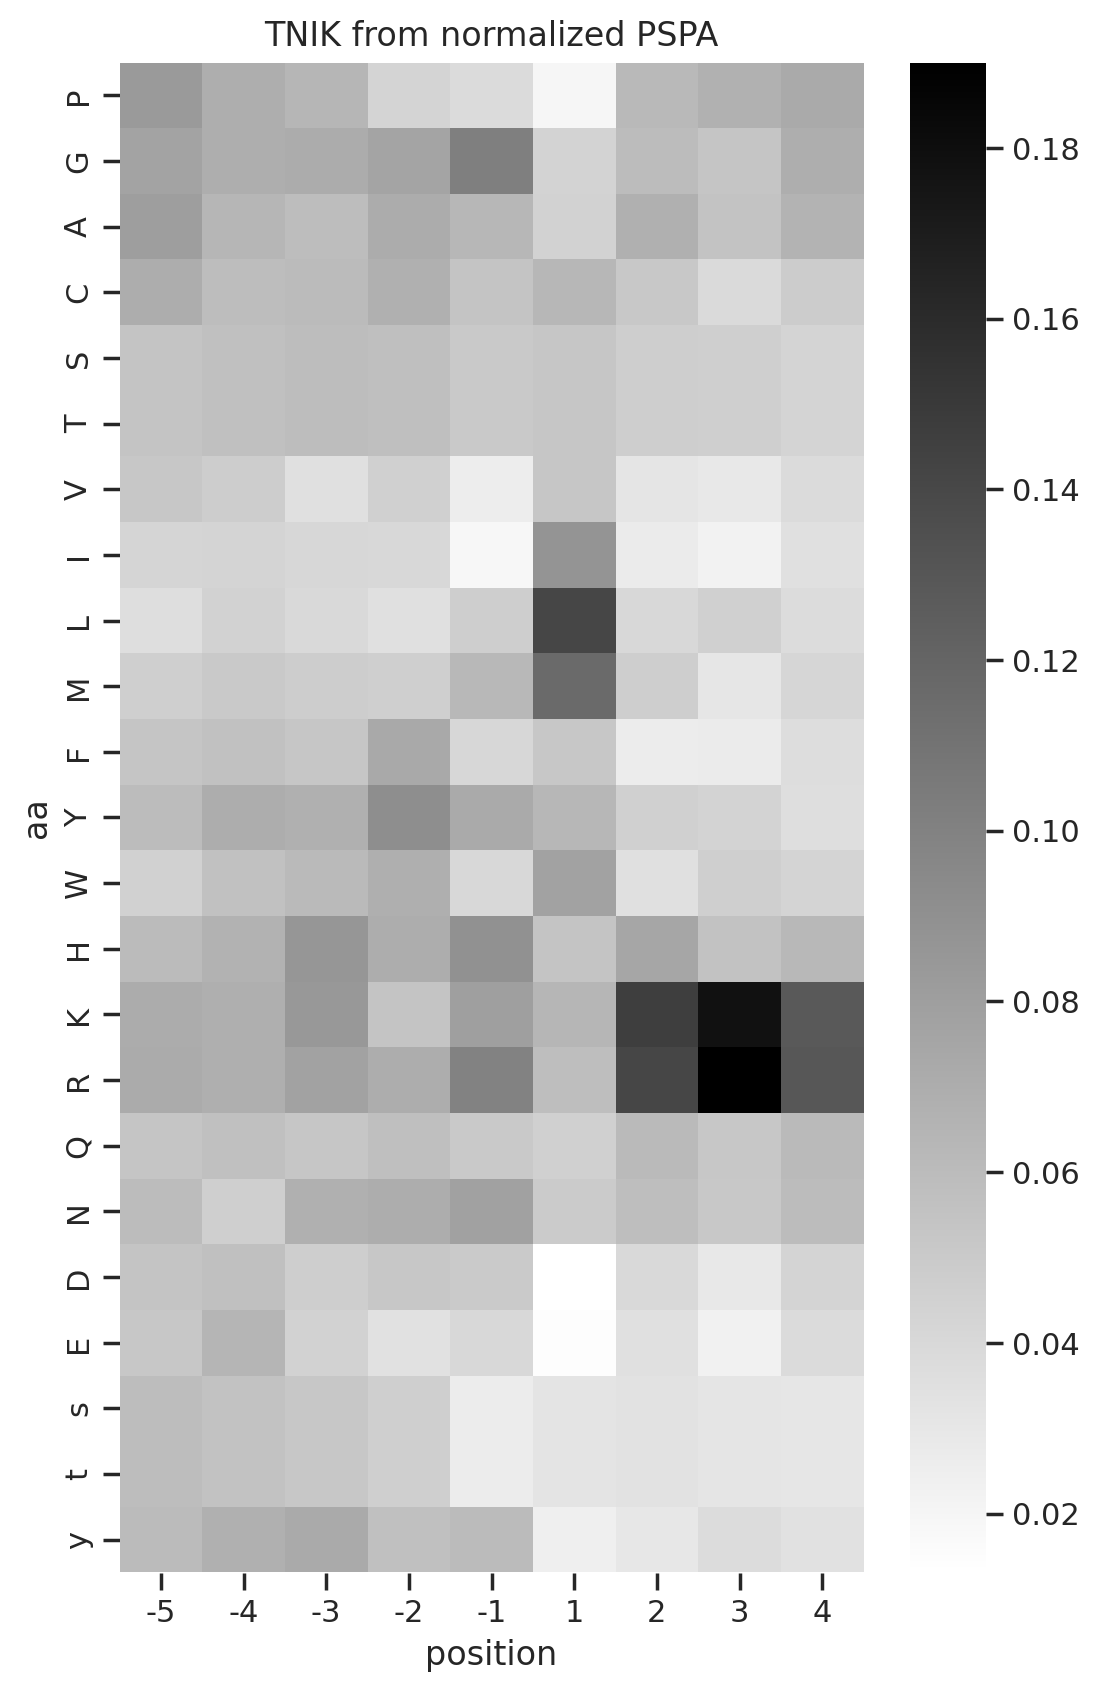

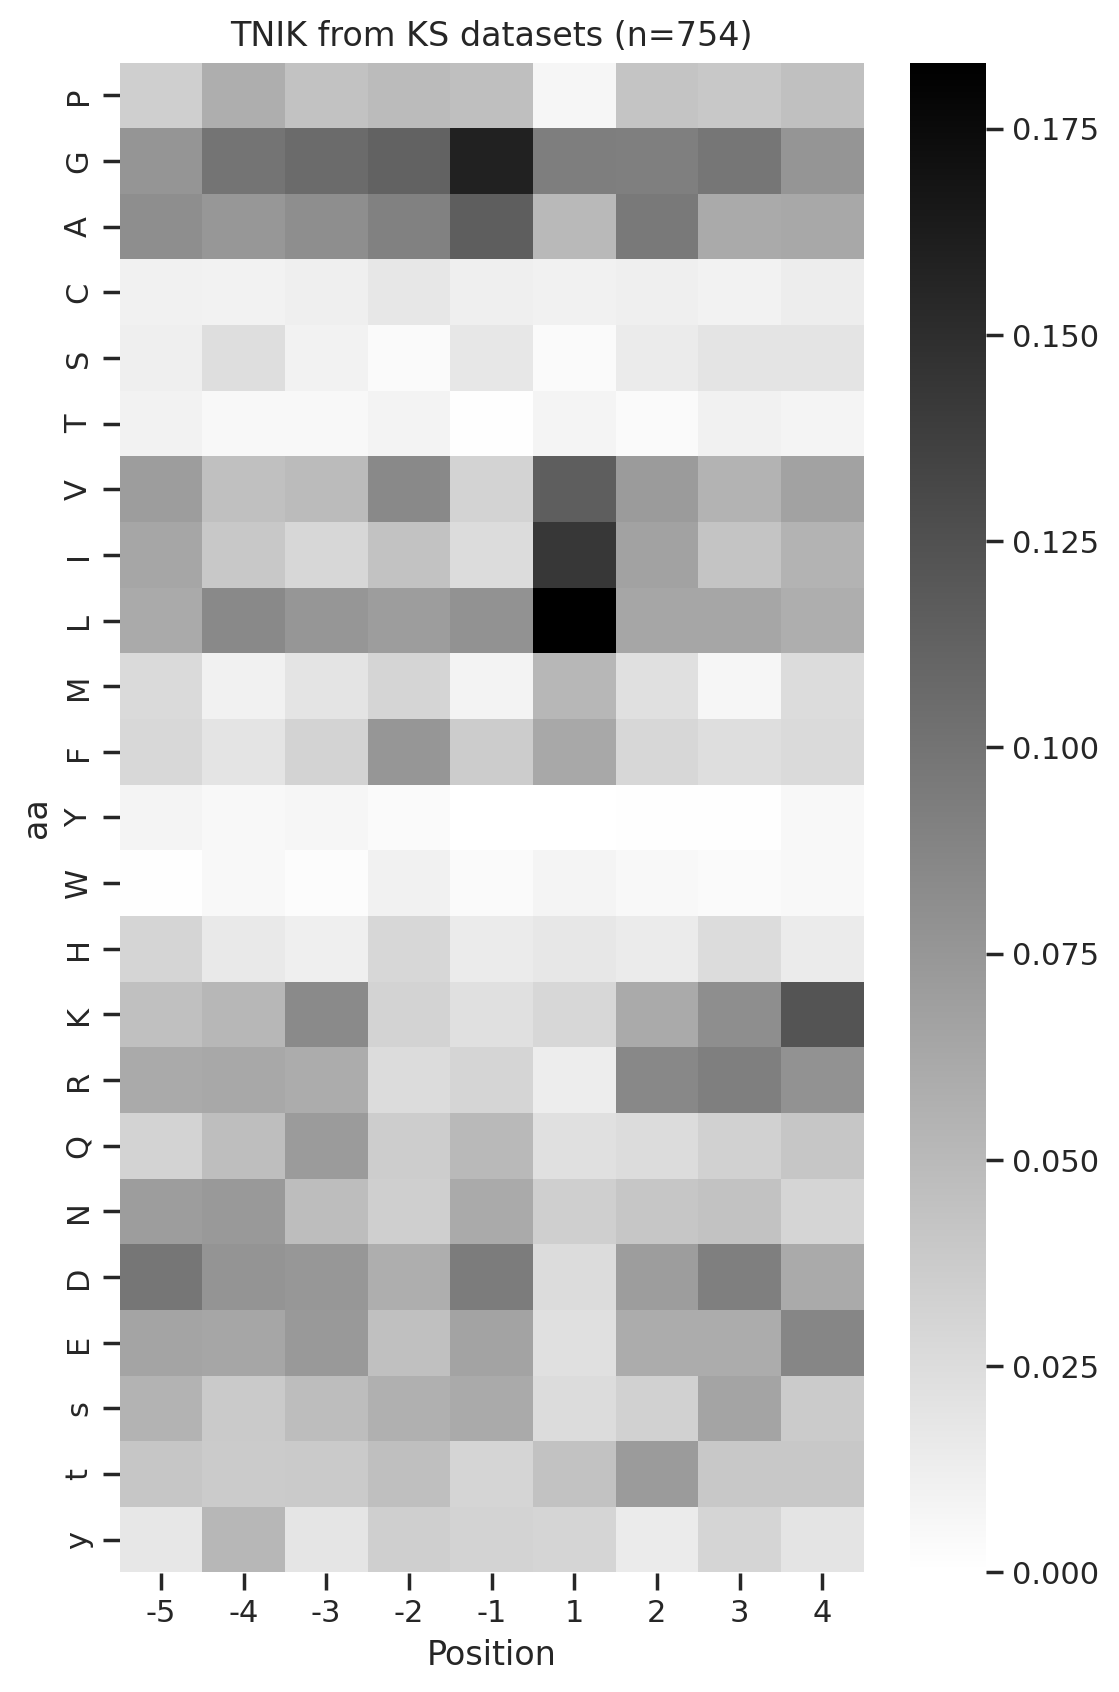

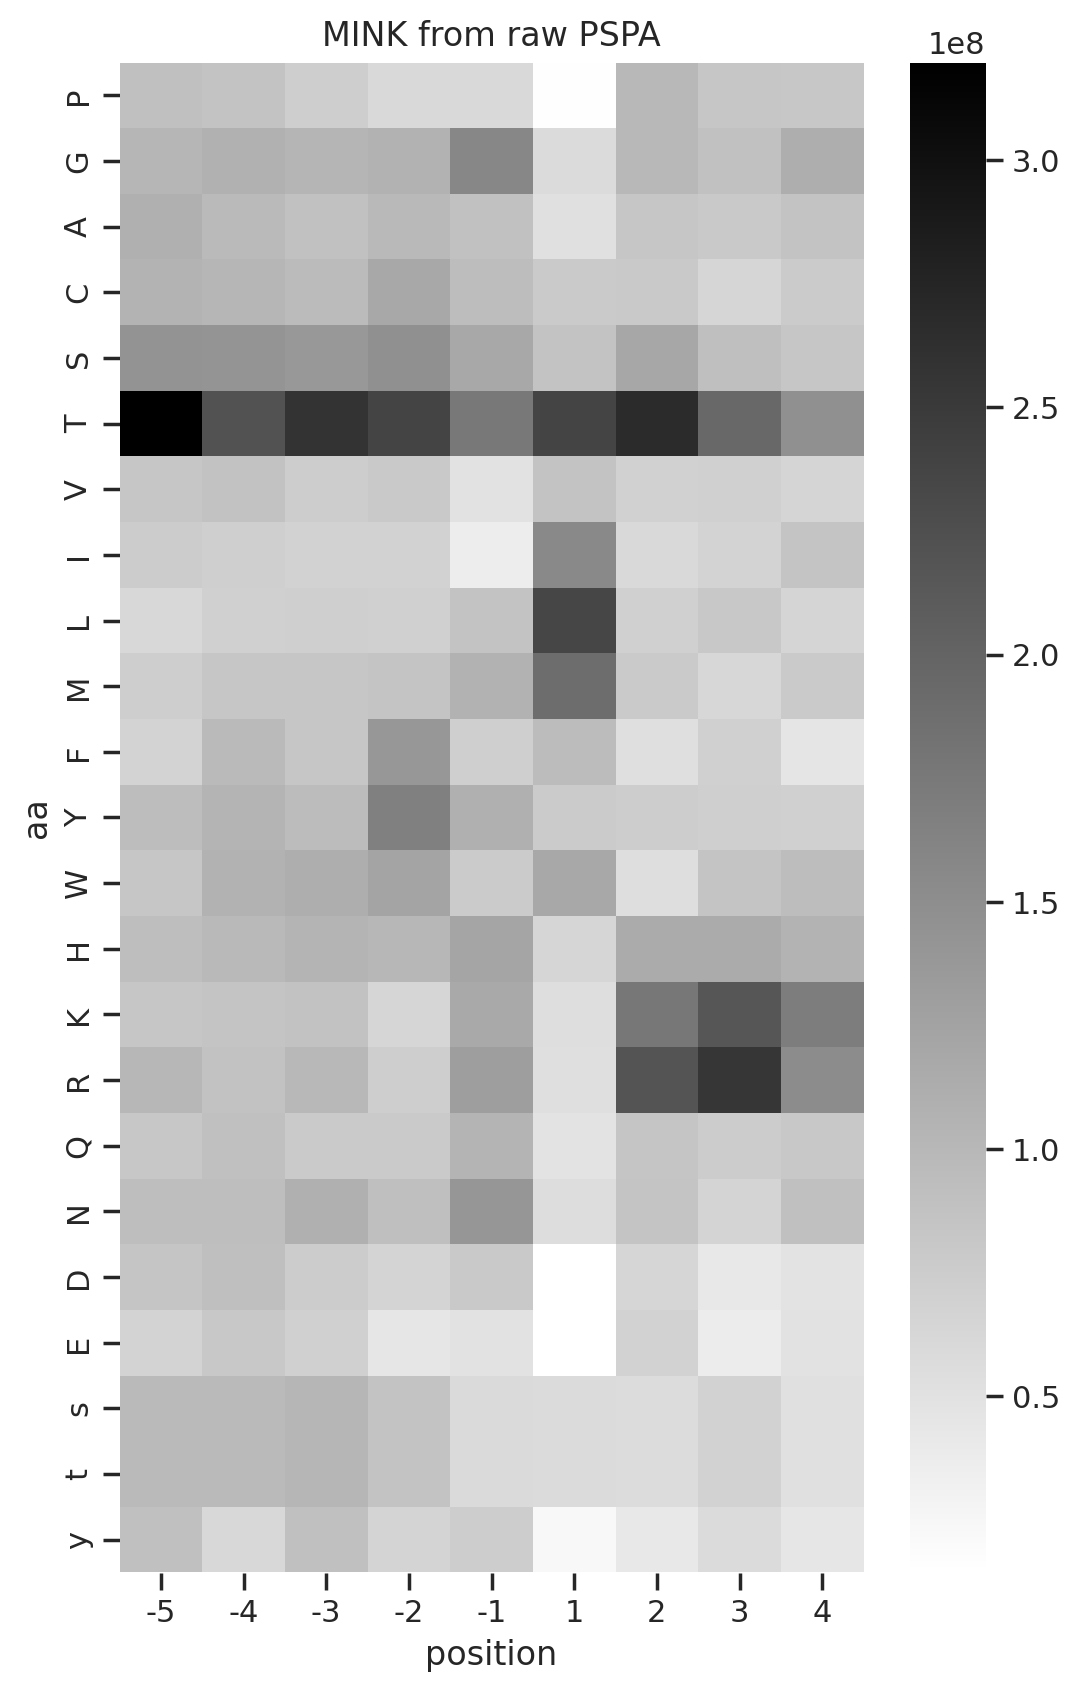

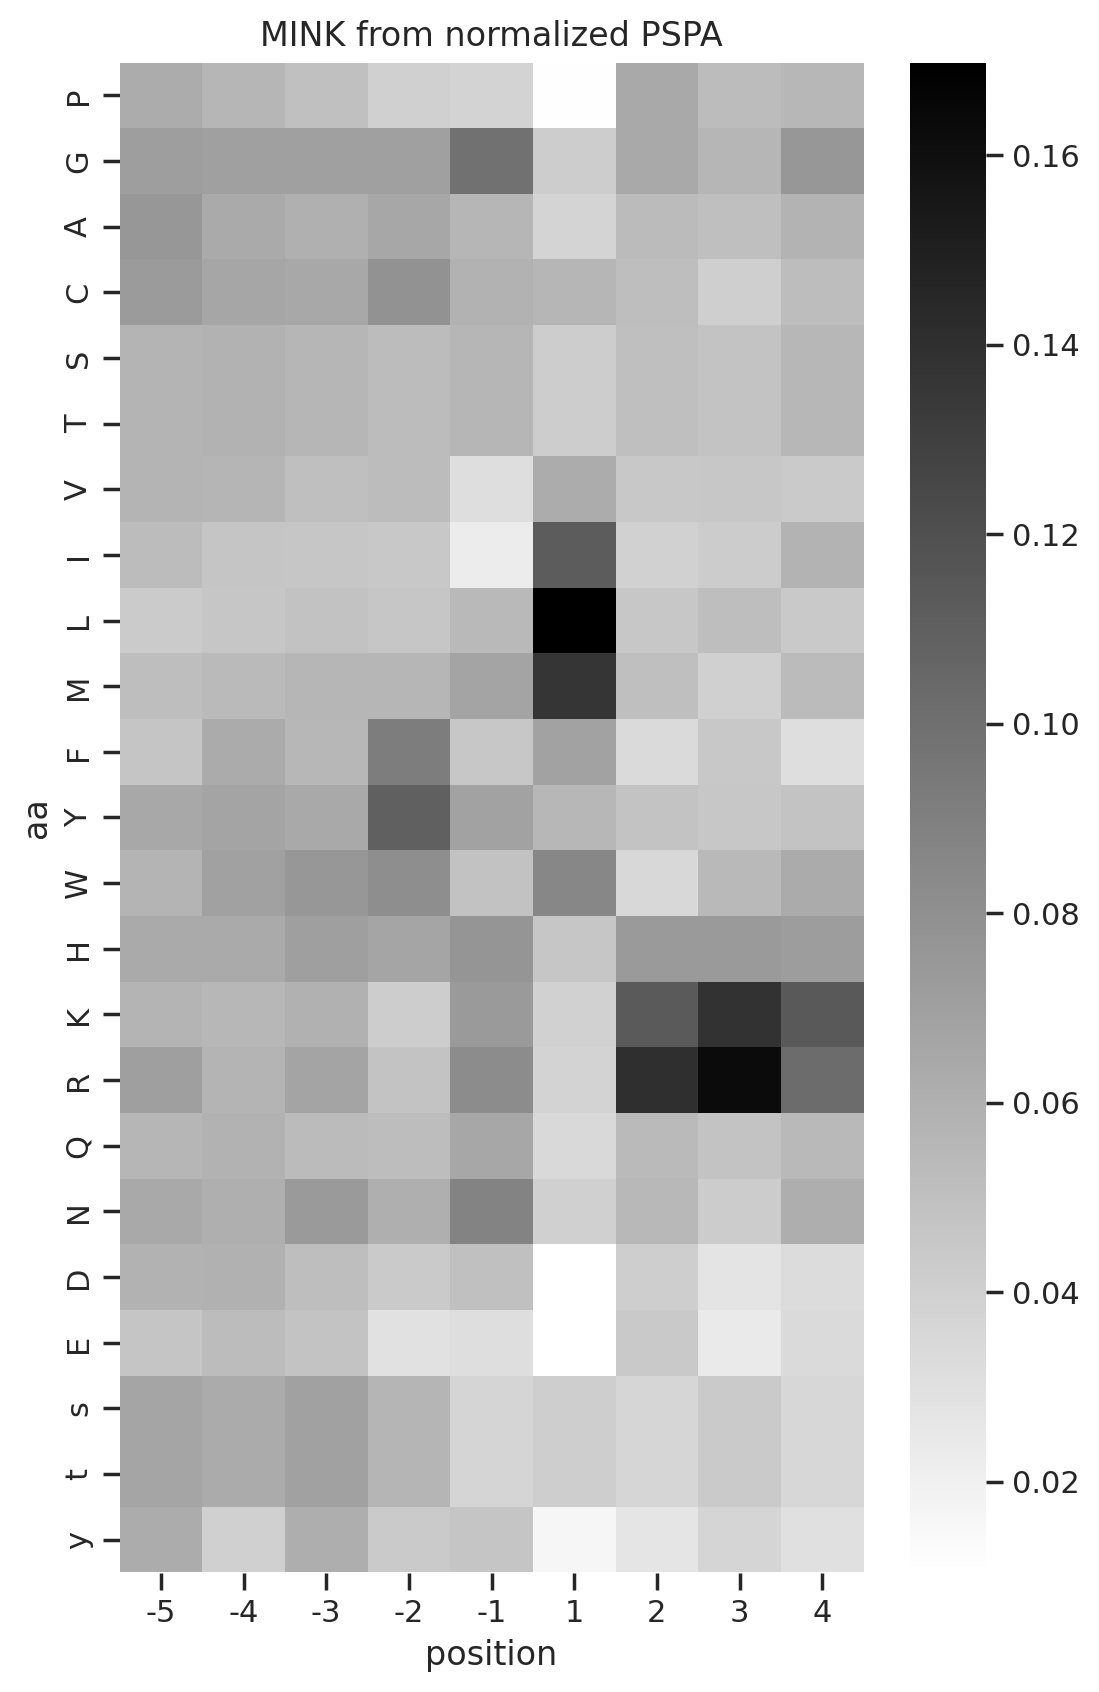

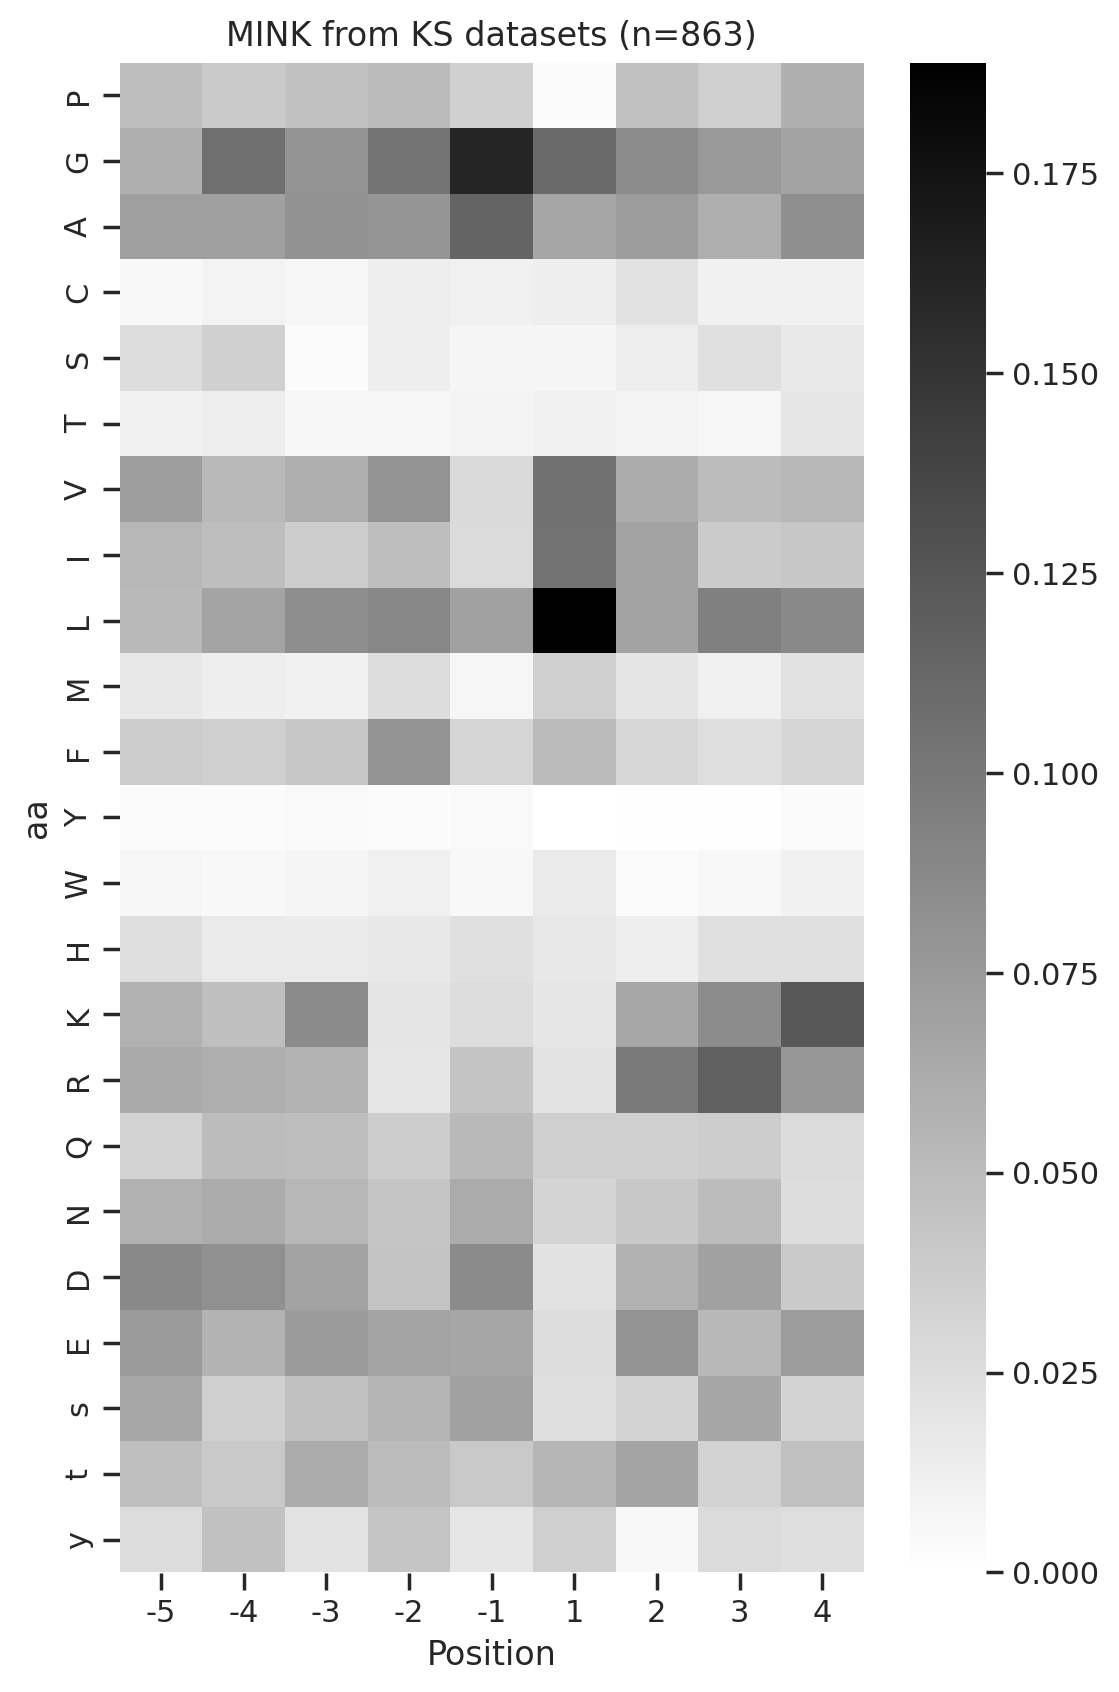

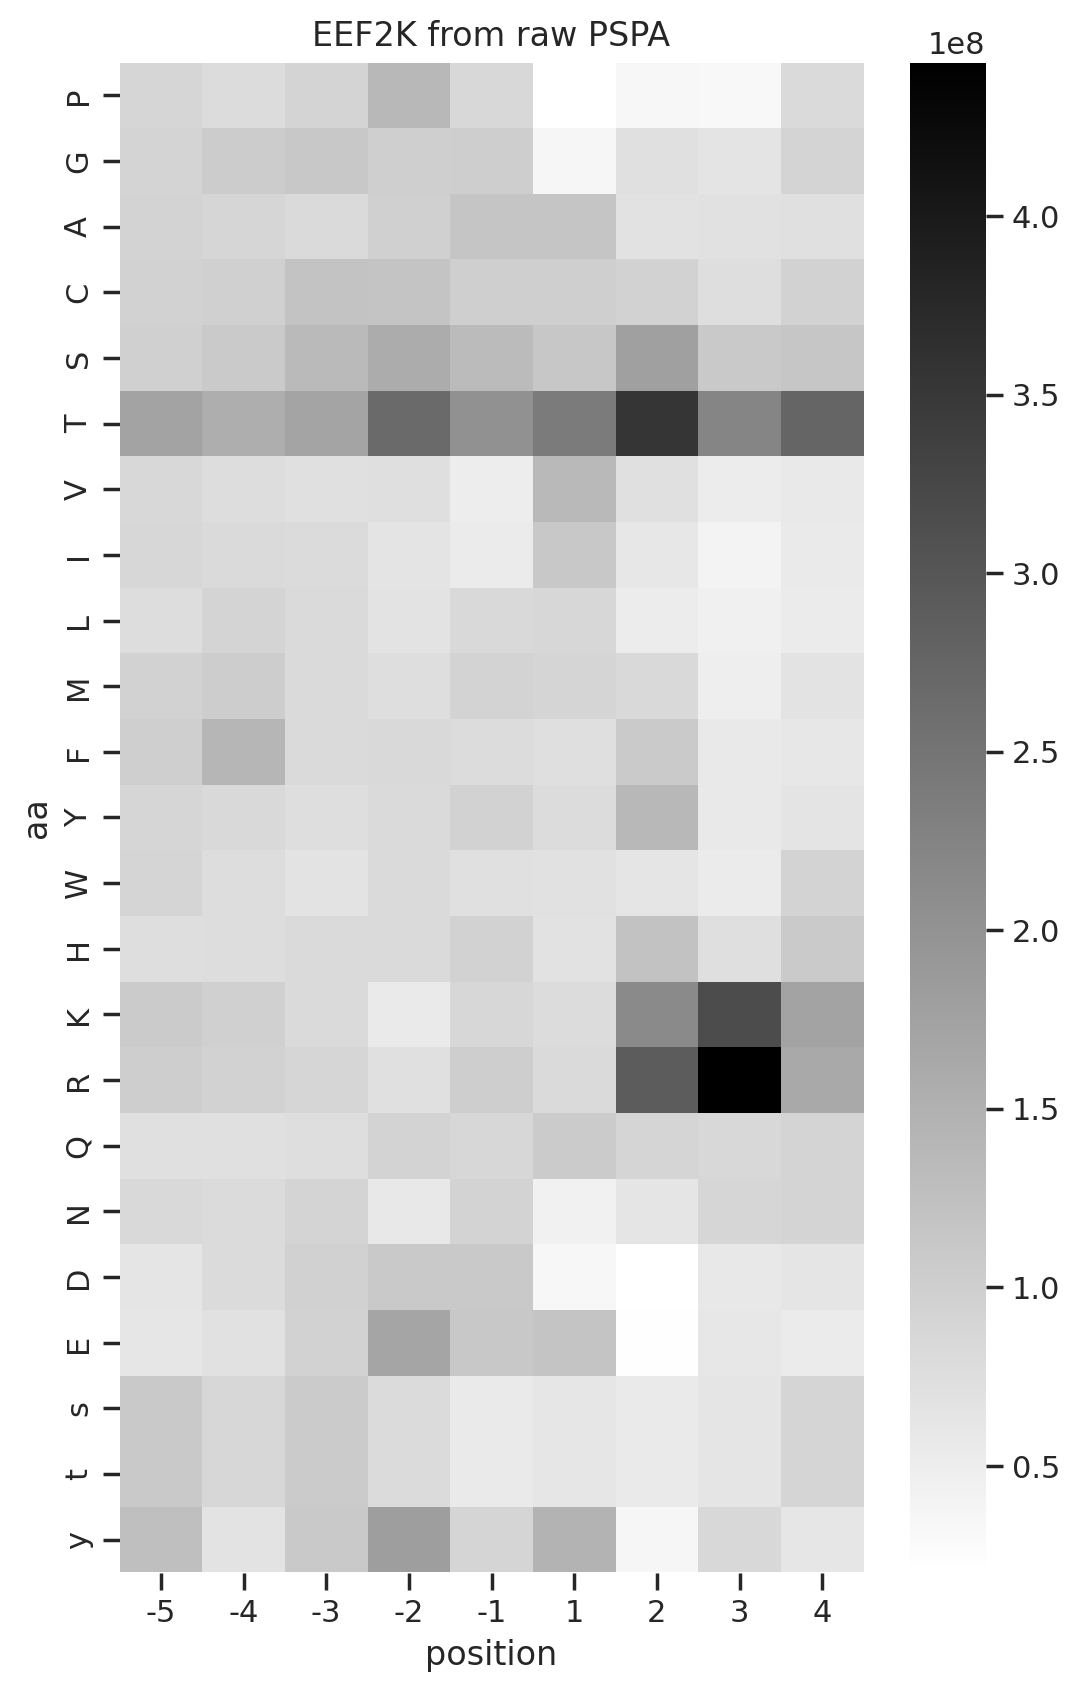

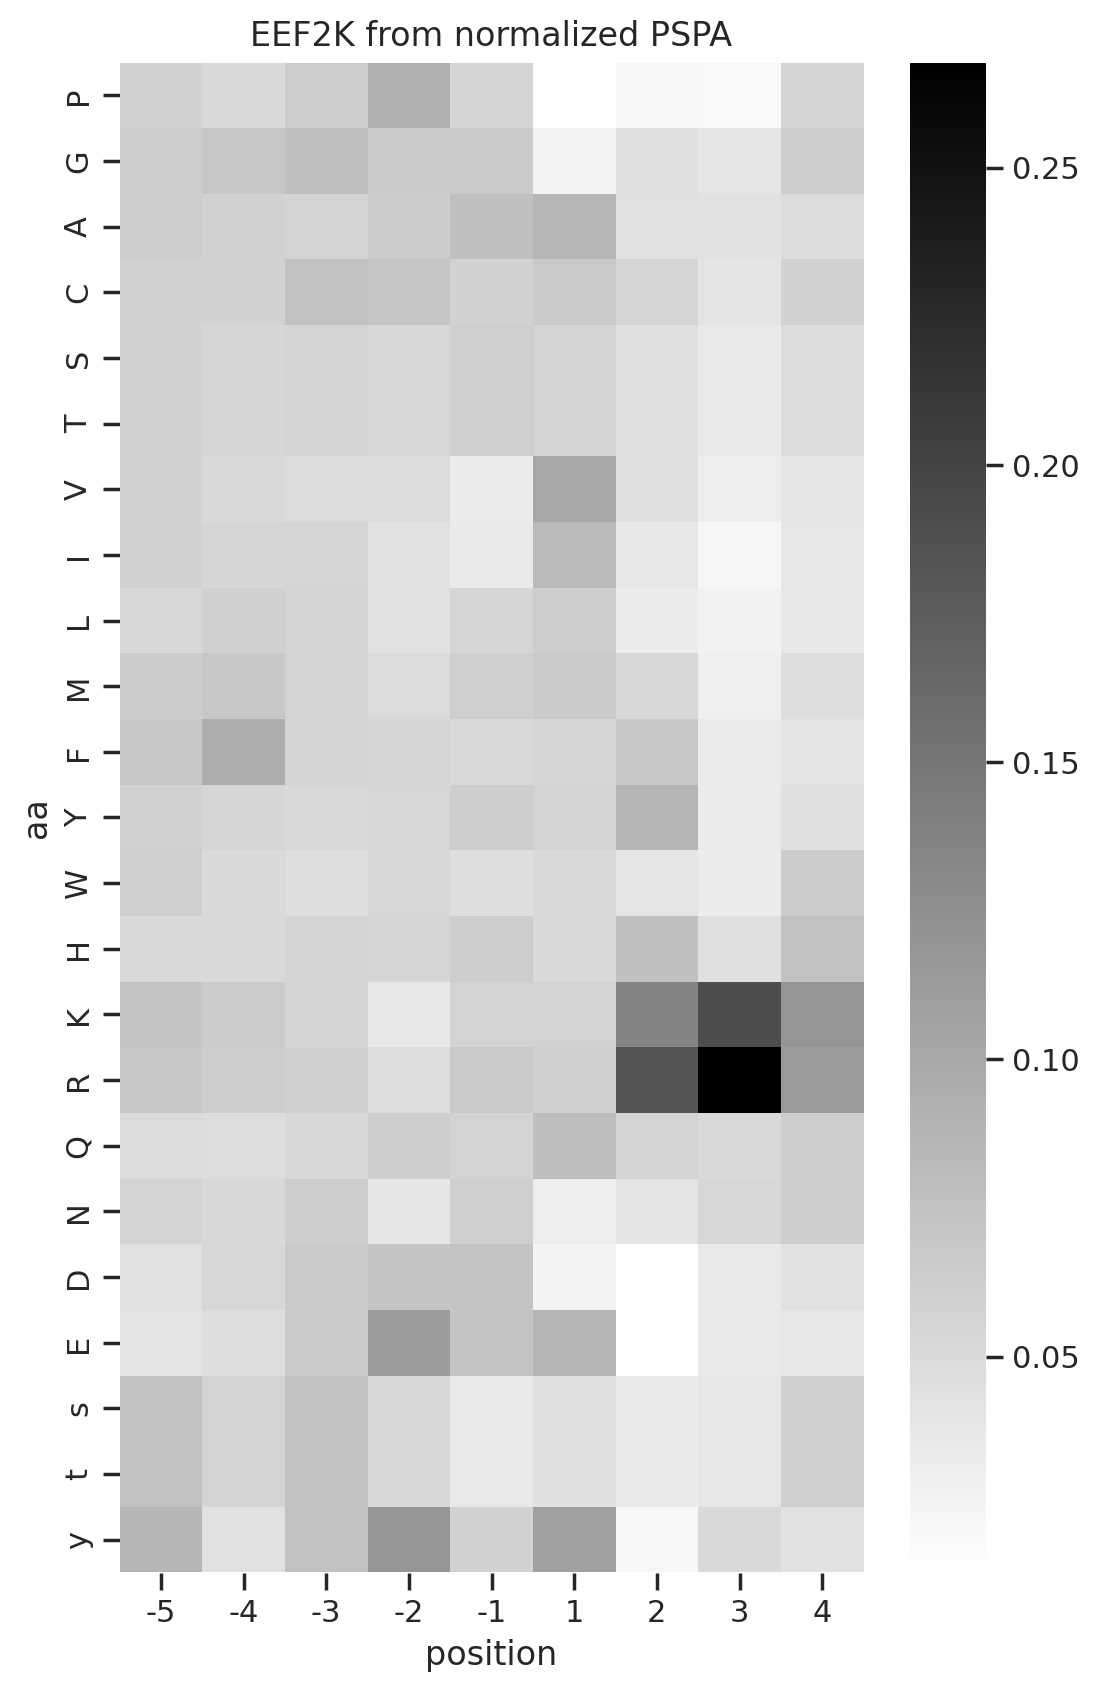

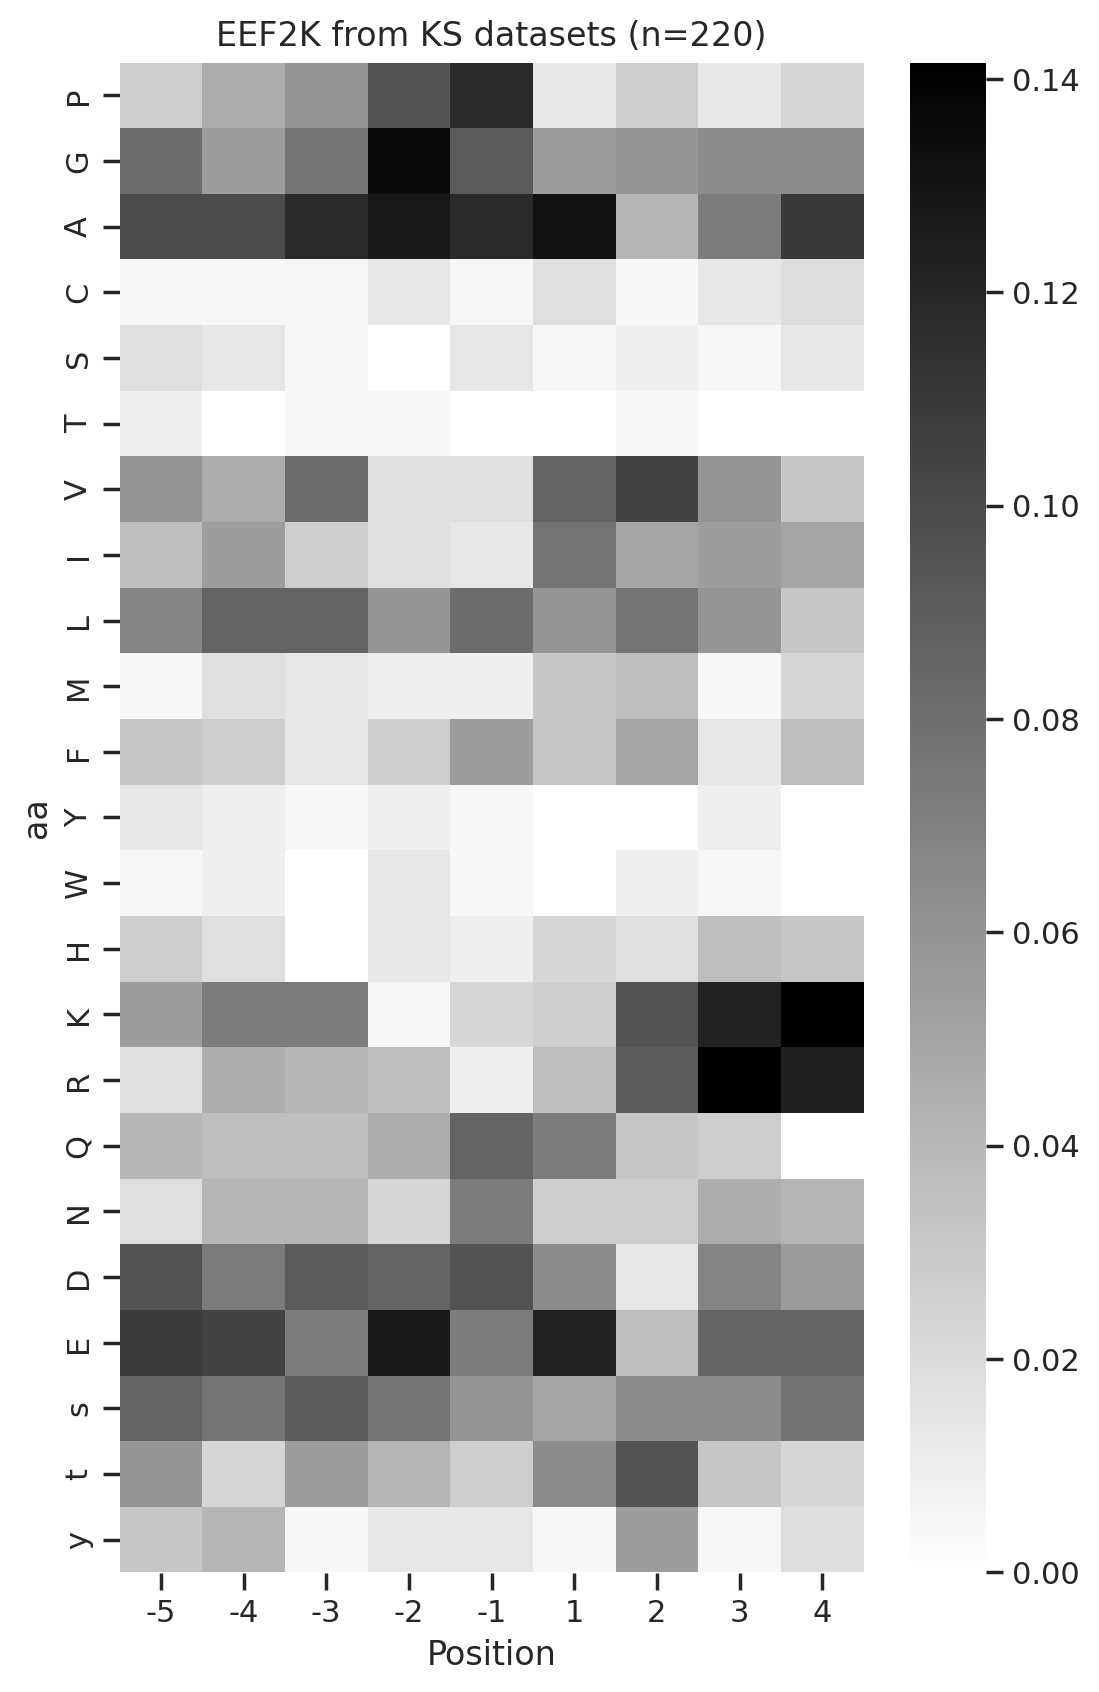

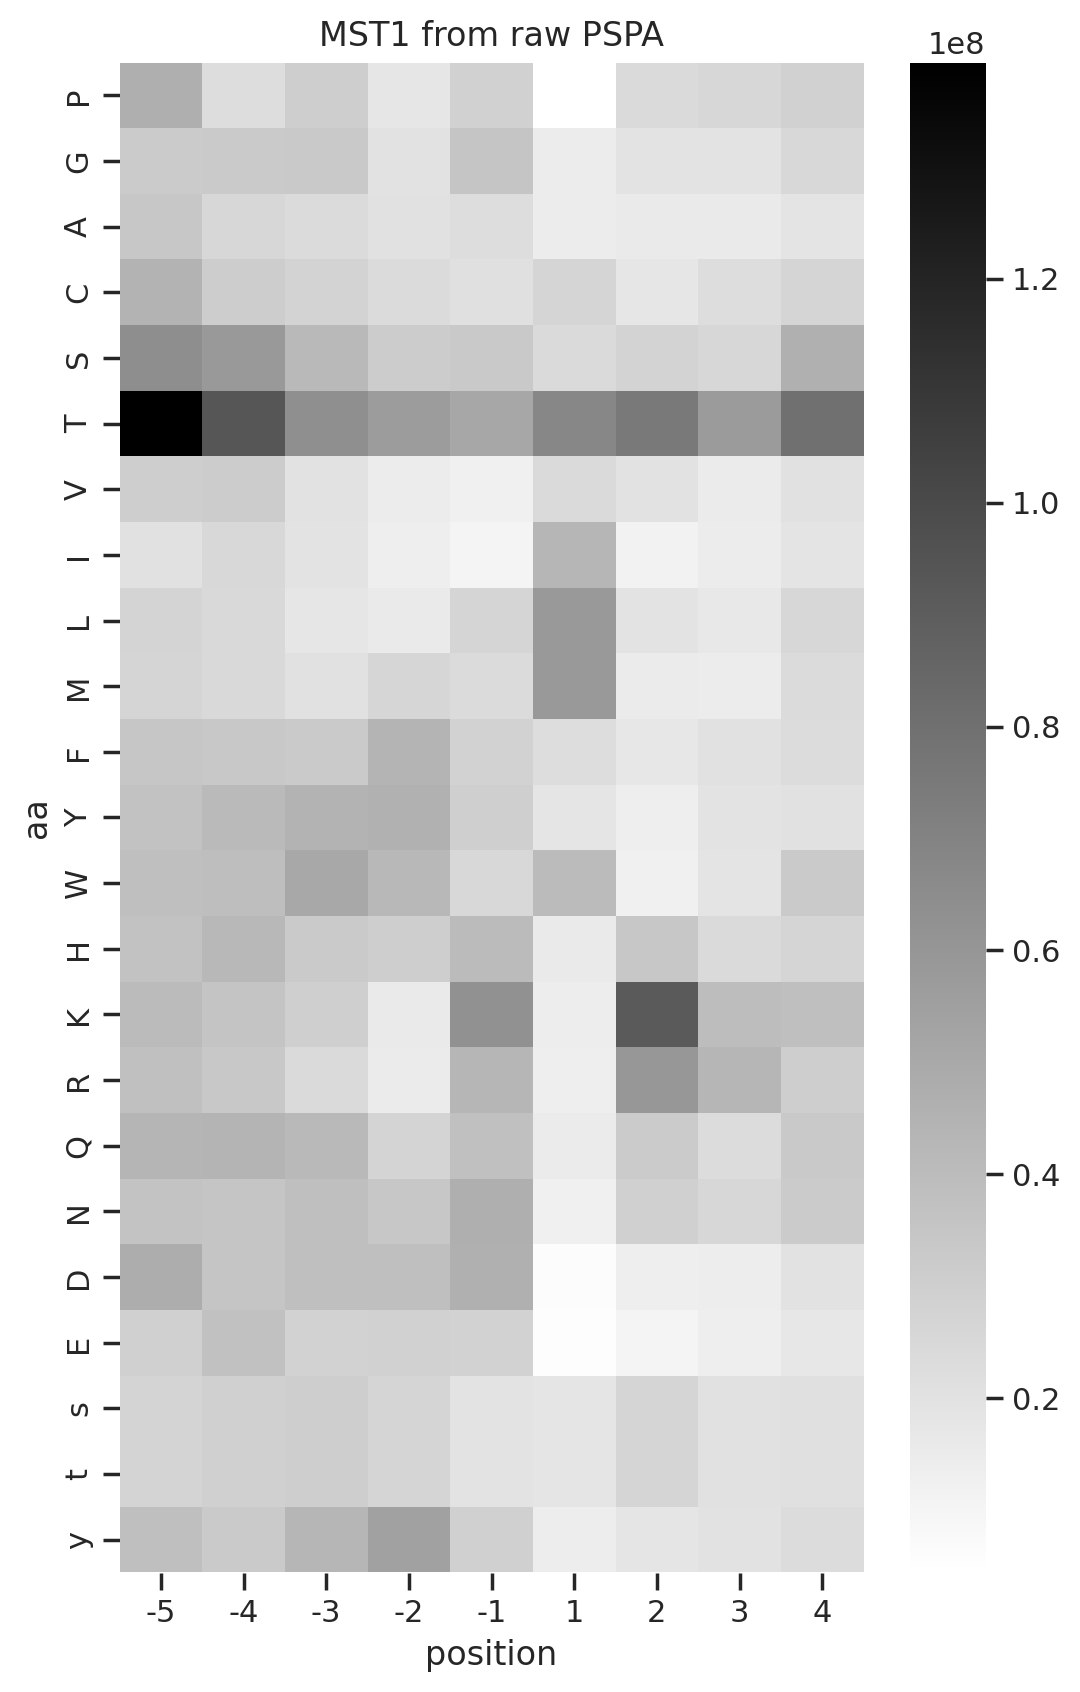

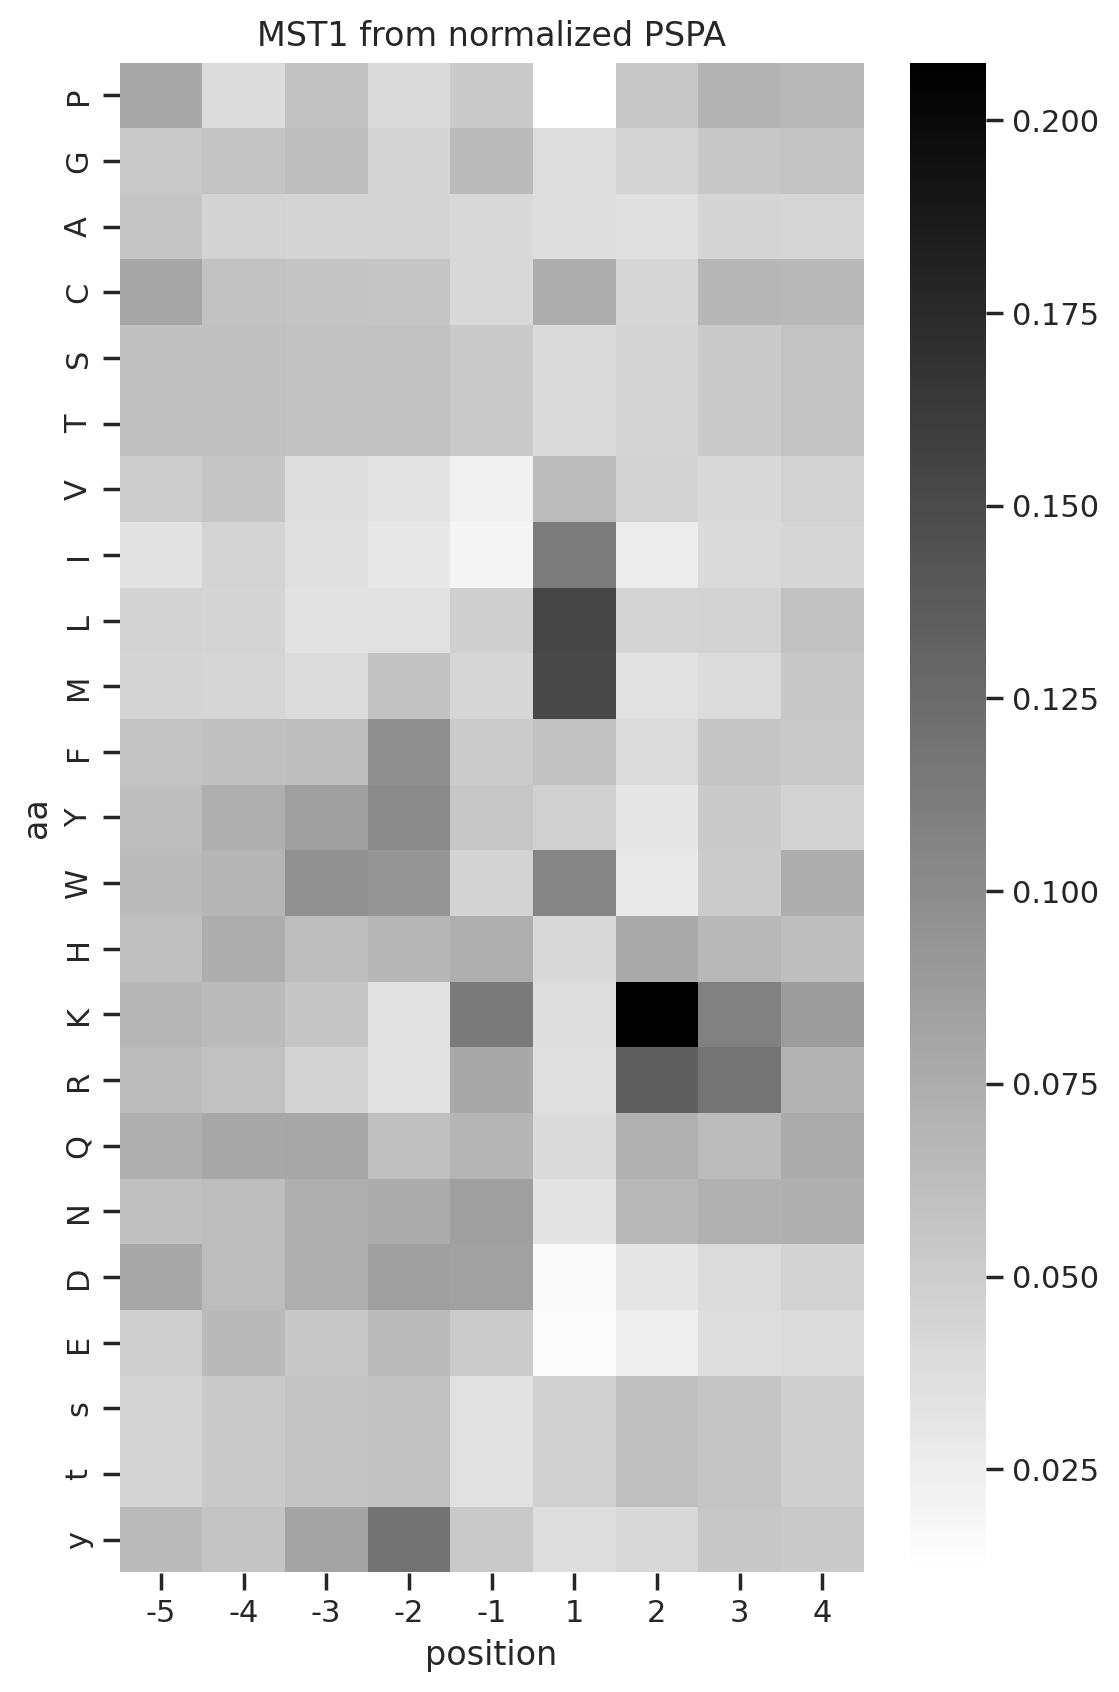

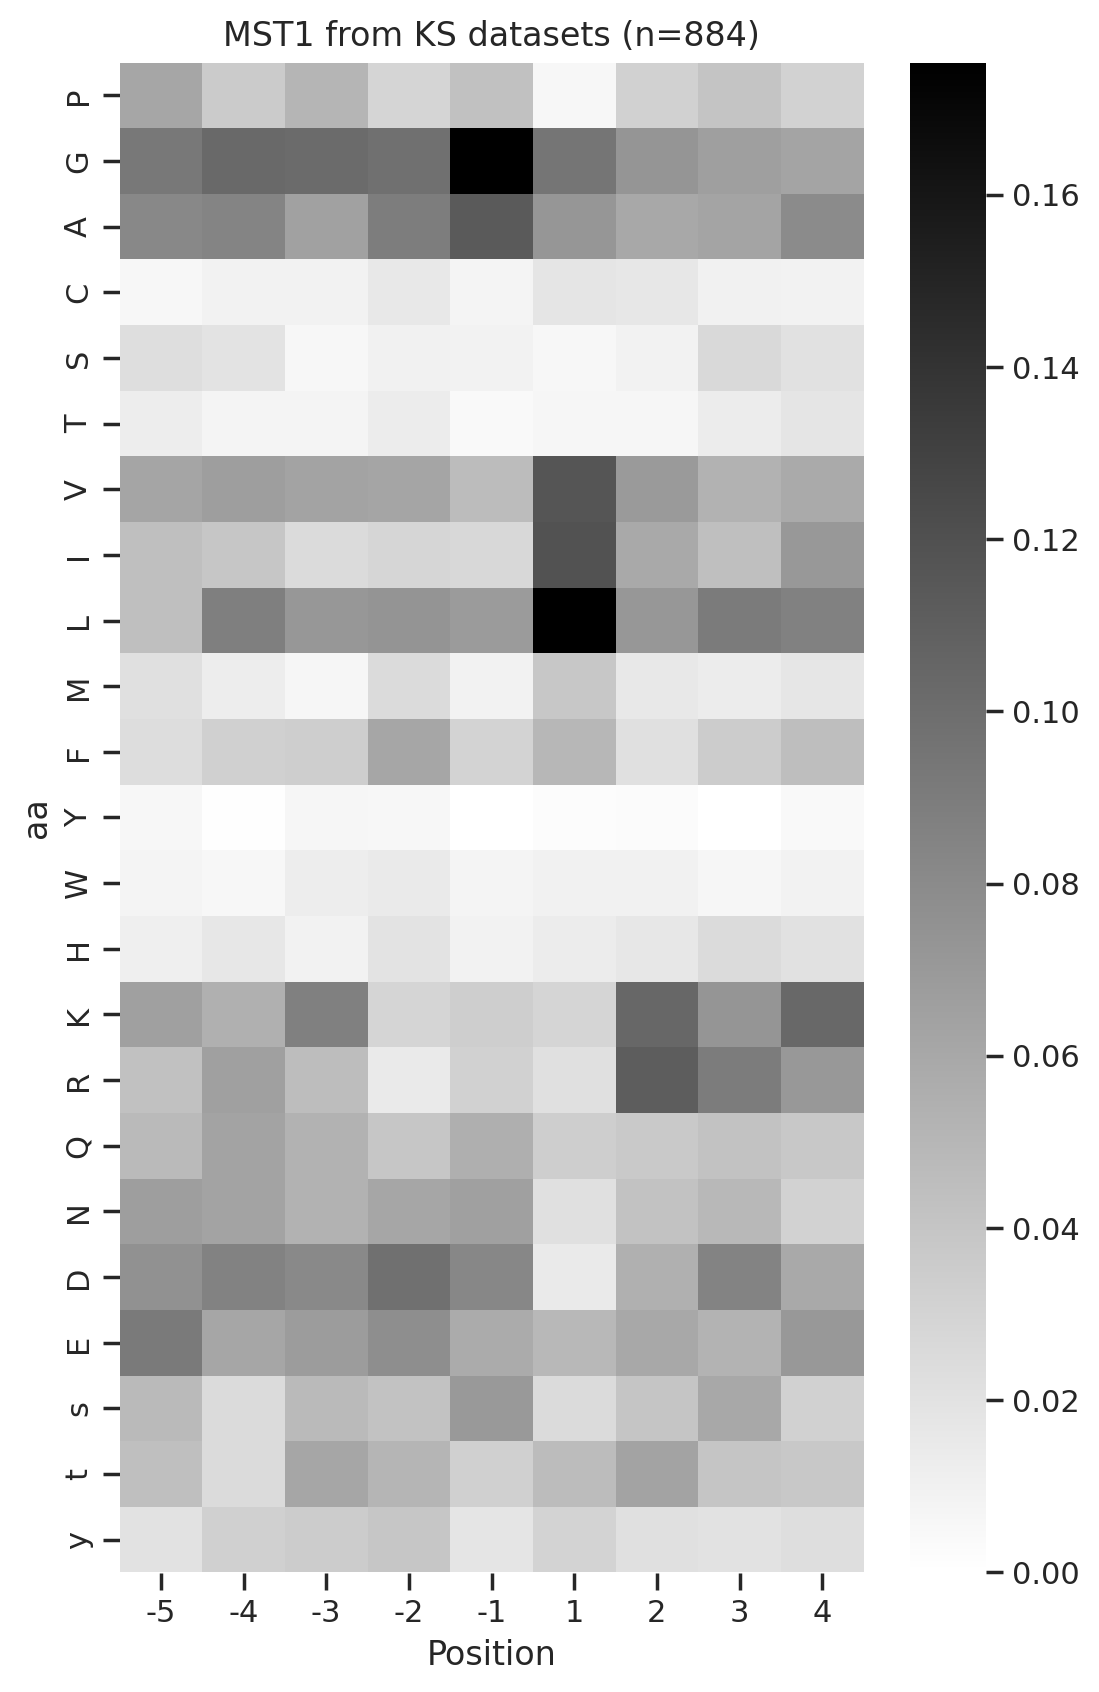

In [ ]:
for k in corr.sort_values('change_corr',ascending=False).kinase[:5]:
    
    df_k=df.query(f'kinase_paper == "{k}"')
    paper, full = get_freq(df_k)

    raw_k = get_one_kinase(raw,k,drop_s=False).T
    raw_k = raw_k.reindex(index=aa_order_paper)
    
    norm_k = get_one_kinase(norm,k,drop_s=False).T
    norm_k = norm_k.reindex(index=aa_order_paper)
    
    plot_heatmap(raw_k,f'{k} from raw PSPA')
    plot_heatmap(norm_k,f'{k} from normalized PSPA')
    plot_heatmap(paper,f'{k} from KS datasets (n={len(df_k)})')

Calculate S and T ratio

In [ ]:
data = []
for k in overlap_cnt.index:

    # paper, full = get_freq(df,k)

    raw_k = get_one_kinase(raw,k,drop_s=False).T
    raw_k = raw_k.reindex(index=aa_order_paper)
    
    s_ratio = (raw_k.loc['S']/raw_k.sum()).median() #use median because it can better reflect the distribution of the data than the average
    t_ratio = (raw_k.loc['T']/raw_k.sum()).median()
    data.append([k,s_ratio,t_ratio])

In [ ]:
ST_ratio = pd.DataFrame(data,columns=['kinase','S_ratio','T_ratio'])

In [ ]:
corr = corr.merge(ST_ratio)

In [ ]:
corr.corr()

,corr_with_raw,count_combined,corr_with_norm,specificity,change_corr,S_ratio,T_ratio
corr_with_raw,1.000000,0.108369,0.968074,0.602114,-0.552490,0.162549,-0.443531
count_combined,0.108369,1.000000,0.179595,0.012038,0.188476,0.154574,0.040498
corr_with_norm,0.968074,0.179595,1.000000,0.524429,-0.325919,0.249216,-0.303725
specificity,0.602114,0.012038,0.524429,1.000000,-0.527063,-0.001163,-0.295673
change_corr,-0.552490,0.188476,-0.325919,-0.527063,1.000000,0.215636,0.662853
S_ratio,0.162549,0.154574,0.249216,-0.001163,0.215636,1.000000,-0.074444
T_ratio,-0.443531,0.040498,-0.303725,-0.295673,0.662853,-0.074444,1.000000


Check change_corr column in the correlation plot, it seems T ratio is highly correlated with change_corr

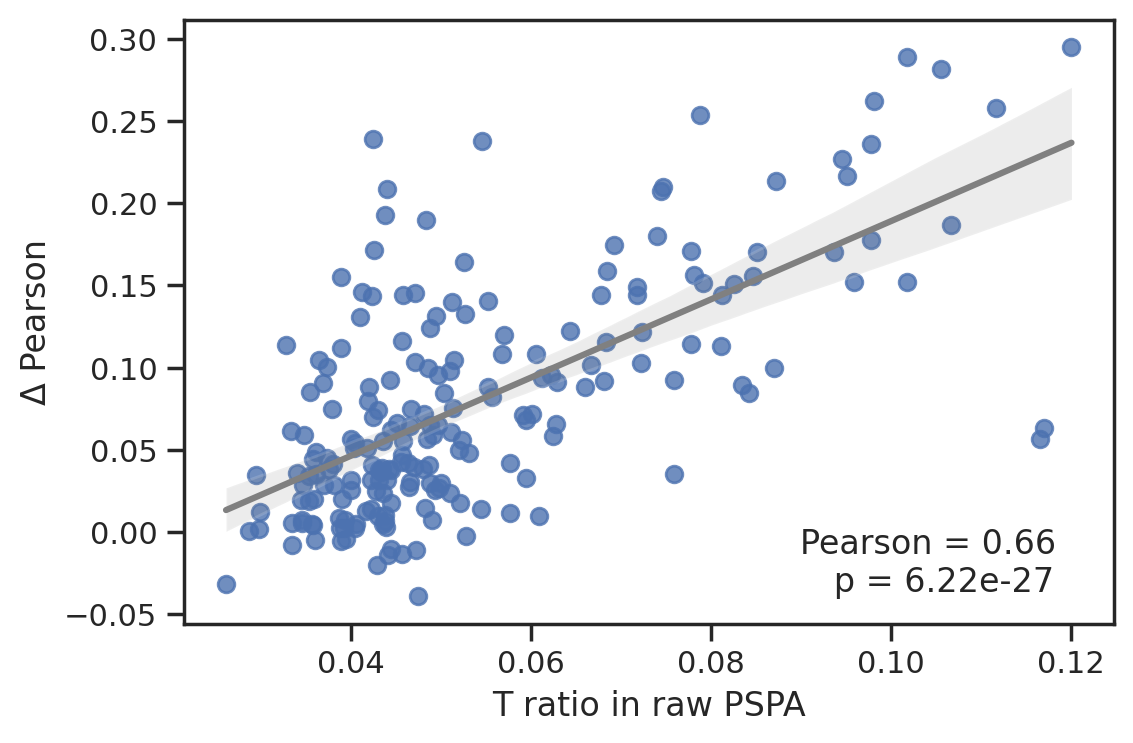

In [ ]:
plot_corr(y=corr.change_corr,x=corr.T_ratio)
plt.xlabel('T ratio in raw PSPA')
plt.ylabel('Δ Pearson');